#  Case Studies in Data Science Final Project
## Jeopardy!

### Team Members:
* Emre Okcular
* Suren Gunturu
* Anawat Putwanphen
* Efrem Ghebreab

Jeopardy! is an American television game show created by Merv Griffin. The show features a quiz competition in which contestants are presented with general knowledge clues in the form of answers, and must phrase their responses in the form of questions. The original daytime version debuted on NBC on March 30, 1964, and aired until January 3, 1975. A weekly nighttime syndicated edition aired from September 1974 to September 1975, and a revival, The All-New Jeopardy!, ran on NBC from October 1978 to March 1979. The version airing as of 2021

### Dataset Description

According to j-archive, the total number of Jeopardy! questions over the show's span (as of this post) is 252,583 - so this is approximately 83% of them. In particular, around the last two years of game play are missing.

The json file is an unordered list of questions where each question has

* `category` : the question category, e.g. "HISTORY"

* `value` : \\$ value of the question as string, e.g. "$200"

Note: This is "None" for Final Jeopardy! and Tiebreaker questions

* `question` : text of question

Note: This sometimes contains hyperlinks and other things messy text such as when there's a picture or video question

* `answer` : text of answer

* `round` : one of "Jeopardy!","Double Jeopardy!","Final Jeopardy!" or "Tiebreaker"

Note: Tiebreaker questions do happen but they're very rare (like once every 20 years)

* `show_number` : string of show number, e.g '4680'

* `air_date` : the show air date in format YYYY-MM-DD

In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn  as sns


plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
from nltk.corpus import stopwords
import string
from statistics import mean
%config InlineBackend.figure_format = 'retina'   # retina for sharper images

from sklearn import set_config # For visualizing pipelines
set_config(display='diagram')

In [15]:
# Add blank space before Answer and concatenante Question with Answer
df = pd.read_csv("JEOPARDY_CSV.csv", parse_dates=[' Air Date'])
df.columns = [name.strip() for name in df.columns ]
df['Answer'] = df['Answer'].fillna(' ')
df['Answer'] =  pd.Series([' ']*len(df)) + df['Answer'] 
df['docs'] = df['Question'] + df['Answer']
df = df.drop(['Question', 'Answer'], axis=1)
df['year'] = df['Air Date'].dt.year

In [16]:
df.head()

Show Number   Air Date      Round                         Category Value  \
0         4680 2004-12-31  Jeopardy!                          HISTORY  $200   
1         4680 2004-12-31  Jeopardy!  ESPN's TOP 10 ALL-TIME ATHLETES  $200   
2         4680 2004-12-31  Jeopardy!      EVERYBODY TALKS ABOUT IT...  $200   
3         4680 2004-12-31  Jeopardy!                 THE COMPANY LINE  $200   
4         4680 2004-12-31  Jeopardy!              EPITAPHS & TRIBUTES  $200   

                                                docs  year  
0  For the last 8 years of his life, Galileo was ...  2004  
1  No. 2: 1912 Olympian; football star at Carlisl...  2004  
2  The city of Yuma in this state has a record av...  2004  
3  In 1963, live on "The Art Linkletter Show", th...  2004  
4  Signer of the Dec. of Indep., framer of the Co...  2004

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Show Number  216930 non-null  int64         
 1   Air Date     216930 non-null  datetime64[ns]
 2   Round        216930 non-null  object        
 3   Category     216930 non-null  object        
 4   Value        216930 non-null  object        
 5   docs         216930 non-null  object        
 6   year         216930 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 11.6+ MB


In [18]:
df.Round.value_counts()

Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name: Round, dtype: int64

In [19]:
print("Minimum Date : " ,str(df["Air Date"].min()),"Maximum Date",str(df["Air Date"].max()))

Minimum Date :  1984-09-10 00:00:00 Maximum Date 2012-01-27 00:00:00


In [20]:
import datetime as dt

dfs = {}
for year in range(df["Air Date"].min().year,df["Air Date"].max().year+1):
    dfs[year] = df[df['Air Date'].dt.year == year]

In [21]:
year_by_cat = {}
for year in dfs:
    year_by_cat[year] = len(dfs[year].Category.unique())

In [22]:
print("Average number of Categories :",int(mean(year_by_cat.values())))

Average number of Categories : 1410


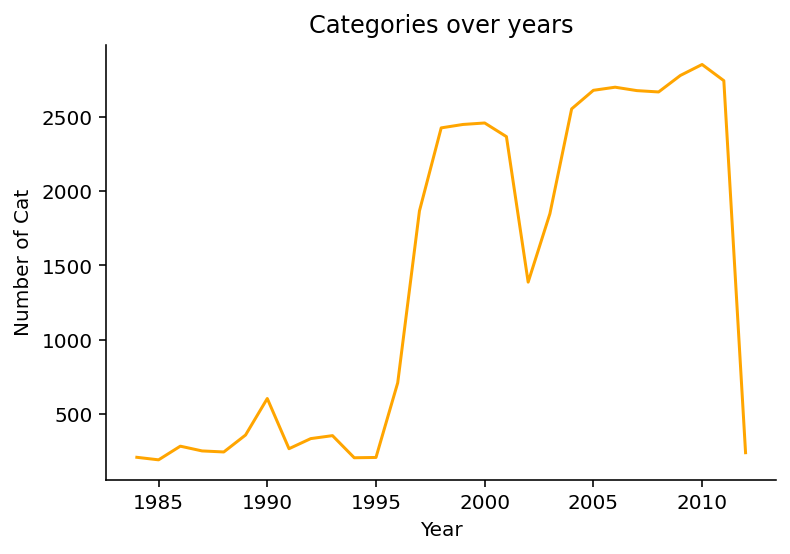

In [23]:
years_by_cat_df = pd.DataFrame(year_by_cat.items(),columns=["Year","Number of Category"])


plt.plot(years_by_cat_df.Year,years_by_cat_df["Number of Category"],color="orange")
plt.xlabel("Year")
plt.ylabel("Number of Cat")
plt.title("Categories over years")
plt.show()

In the below chart, you can see that number of categories increased over years

# Question 1 - Game Dynamics

## Analyzing the **Annual Themes** of the questions asked in each year and round
In the first part, we will analyze the overall themes of all questions asked (we treat every questions asked in that year as a one big document) in each year and round.

1. text pre-processing

In [24]:
# remove href
pat = r'(<a.*">|</a>)'
df['docs'] = df['docs'].str.replace(pat, ' ')
# remove number
pat = r'\d+'
df['docs'] = df['docs'].str.replace(pat, '%number')
# remove some punctuation
pat = r'[' + string.punctuation+ ']'
df['docs'] = df['docs'].str.replace(pat, ' ')

In [25]:
# Concatenate Q&A in the same year and round together
annual_df = df.groupby(['Round', 'year'])['docs'].apply(lambda x: ' '.join(x)).reset_index()
annual_df = annual_df[~(annual_df['Round'] == 'Tiebreaker')]
annual_df.sort_values(by=['Round', 'year'], inplace=True)

2. Generate tf-idf of term x document and train NMF model 

In [26]:
# generate tf-idf
corpus = annual_df['docs'].values
# preprocessing (remove stopwords)
stop = stopwords.words('english')
stop += ['www', 'com', 'http', 'mp3']
tfidf_vectorizer = TfidfVectorizer(max_df=0.50,
                                   min_df=0.025,
                                   #max_features=20,
                                   stop_words=stop)
X = tfidf_vectorizer.fit_transform(corpus)
feature_names = tfidf_vectorizer.get_feature_names()

3. Analyze Frobenius error/distance of each # of topics k <br>

We want to have a low number of k that could capture the recurring theme among 3 rounds of Jeopardy! across years, but <br>
we also don't want to have too much k that assign theme to every specific round-year.
Here we set an arbritary max number of k to 12.

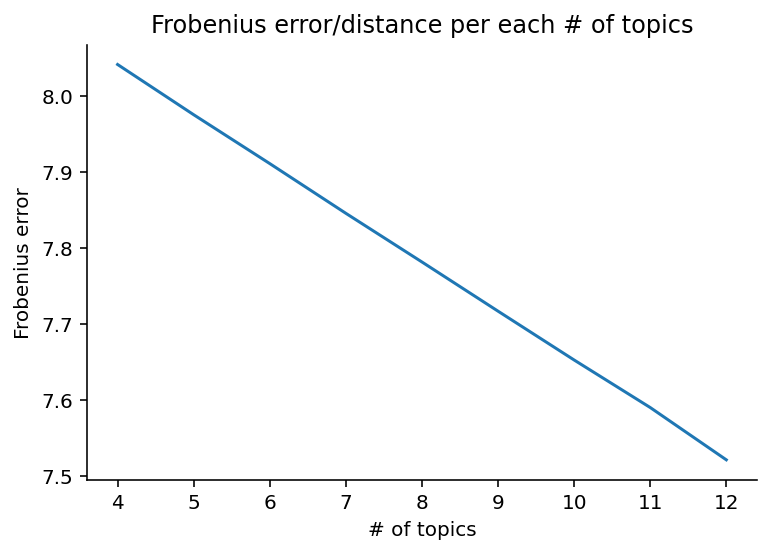

In [27]:
errs = []
max_n = 12
for i in range(4,max_n+1):
    model = NMF(n_components=i, init='nndsvd', random_state=63, max_iter=1000)
    model.fit(X)
    errs.append(model.reconstruction_err_)
plt.plot([i for i in range(4,max_n+1)],errs)
plt.ylabel('Frobenius error')
plt.xlabel('# of topics')
plt.title('Frobenius error/distance per each # of topics')
plt.show()

**Observation**: There is no "elbow" point, we will select # of topics that's given the lowest error that is k=12

In [28]:
# generate 12 topics
model = NMF(n_components=12, init='nndsvd', random_state=1001, max_iter=1500)
W = model.fit_transform(X)

When can we use this approach?
* NMF by default produces sparse representations. This mean that most of the entries are close to zero and only very few parameters have significant values. This can be used when we strictly require fewer topics.
* NMF produces more coherent topics compared to LDA.

In [29]:
def plot_top_words(model, feature_names, n_top_words, title):
    '''
    Taken from sklearn's example.
    credit: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
    '''
    n_row = 3
    n_col = 4
    if len(model.components_) <= 8:
        n_row = 2
    fig, axes = plt.subplots(n_row, n_col, figsize=(20, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.5)
        ax.set_title(f'Theme {topic_idx }',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=16)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40, verticalalignment='top')

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

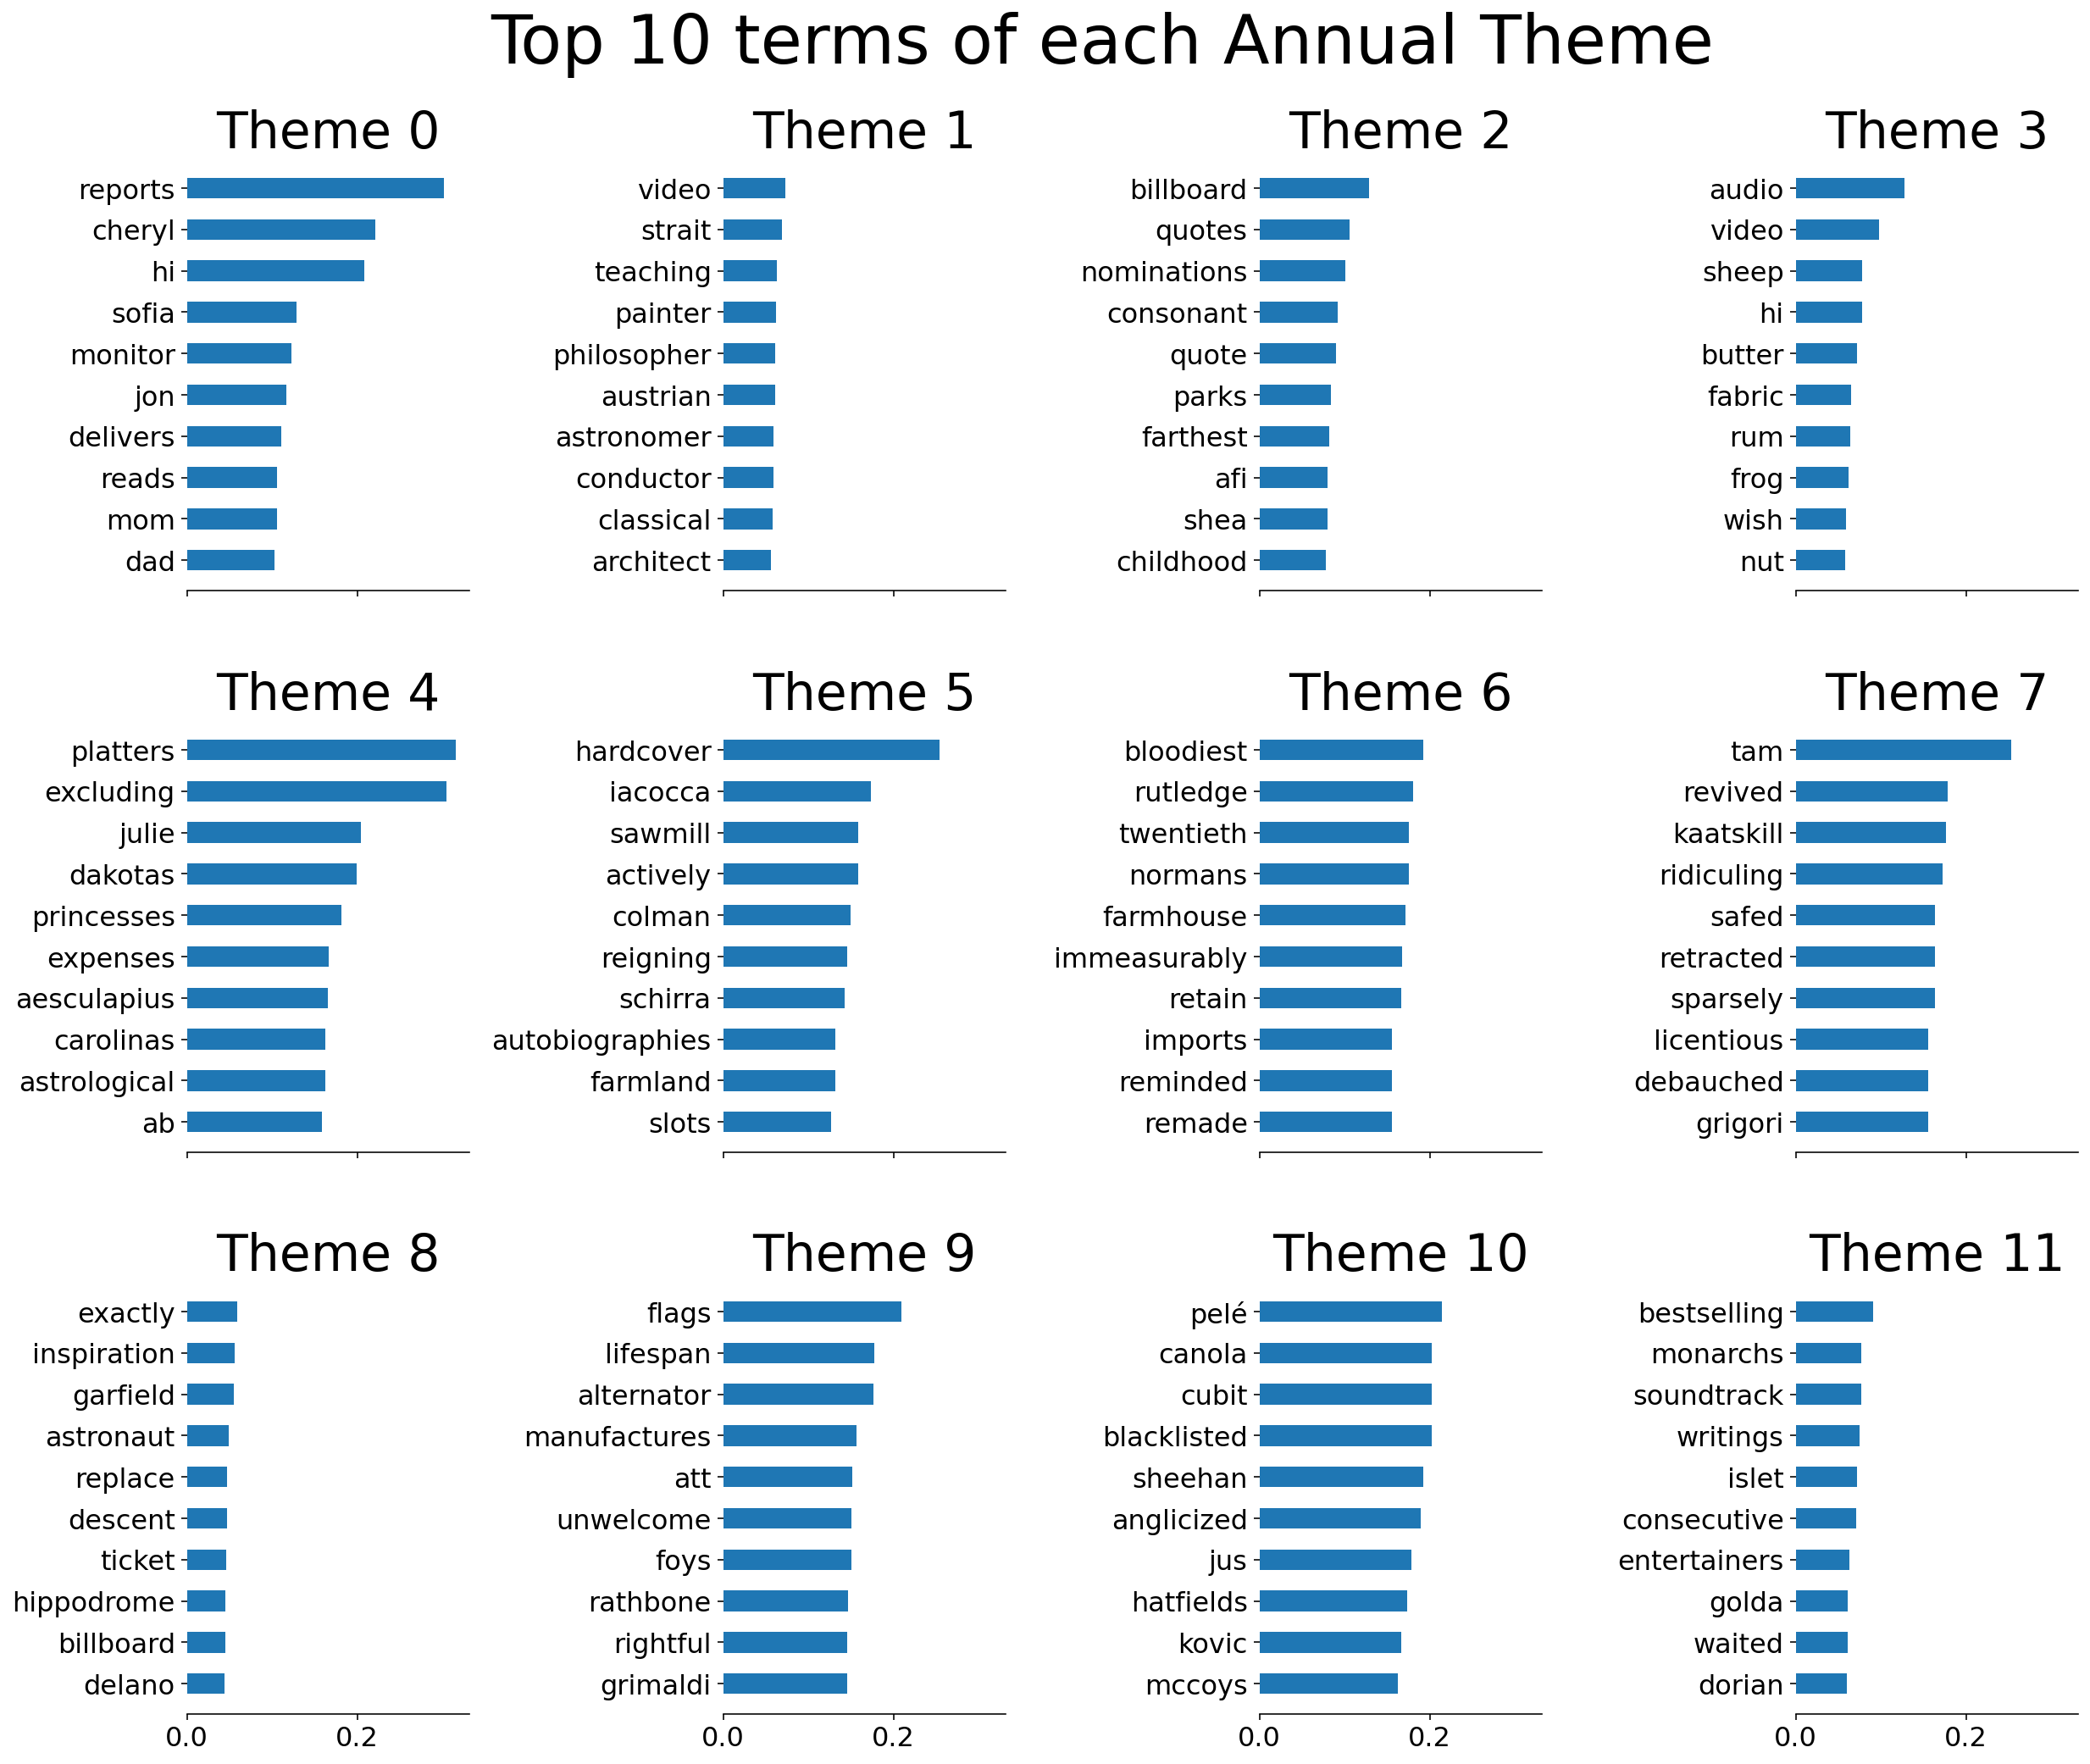

In [30]:
# history and current events, the sciences, the arts, popular culture, literature, and languages.
plot_top_words(model, feature_names, 10, 'Top 10 terms of each Annual Theme')

In [31]:
annual_summary = annual_df.copy()
annual_summary['dominant_topic'] = W.argmax(axis=1)
annual_summary['topic_relavance'] = W.max(axis=1)

In [32]:
data_jeo = []
data_double = []
data_final = []
years = annual_df.year.unique()
for i in range(12):
    data_jeo.append(list((annual_summary[annual_summary.Round == 'Jeopardy!']['dominant_topic'] == i)*1))
    data_double.append(list((annual_summary[annual_summary.Round == 'Double Jeopardy!']['dominant_topic'] == i)*1))
    data_final.append(list((annual_summary[annual_summary.Round == 'Final Jeopardy!']['dominant_topic'] == i)*1))
    
def plot_annual_theme(data_jeo, round_name):
    fig, ax = plt.subplots(figsize=(20,7)) 
    text_grey = '#6D6766'
    light_grey = '#F0F2F4'
    left_most_pos = -1
    bars=[]
    for i in range(12):
        step = 0
        for num in data_jeo[i]:
            ax.text(left_most_pos, i, f'Theme {i}',horizontalalignment='right', verticalalignment='center',
                   fontsize=16, fontweight='bold', color=text_grey)
            ax.plot([-1,30], [i-.33,i-.33], clip_on=False, color=light_grey)
            if num >=1:    color = 'green'
            else:          color =  'white'
            bars += ax.barh(i, 1 , color= color, left = step,  height = 0.7, 
                            align= 'center', edgecolor='white')
            step+=1
    # decorations
    ax.tick_params(axis = 'y', which = 'both', width = 0,labelleft=False)
    ax.set_xbound(0, 30)
    # Remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color("black")
    # xticks
    ax.tick_params(axis = 'x', which = 'both', width = 1, length = 1)
    ax.set_xticks(np.arange(0, len(years)+1, 1))
    ax.set_title(f'The Annual Theme of \'{round_name}\' Round (1984-2012)', size=26, pad=20)
    ax.set_xticklabels(years, size = 14, color=text_grey, weight='semibold',rotation=45)
    plt.show()

## The 'Jeopardy' round Annual Theme
The Jeopardy round is the first round in Jeopardy! The round begins when the returning champion selects any position on the game board <br> (for games  when there is no returning champion, the starting player is chosen by a random draw) In additionn, The first two rounds contain five clues per category<br>
[1] https://en.wikipedia.org/wiki/Jeopardy!#First_two_rounds <br> 
<br>
We are going to explore how did the annual theme of  the 'Jeopardy' round changed over time from 1984 to 2012 <br>


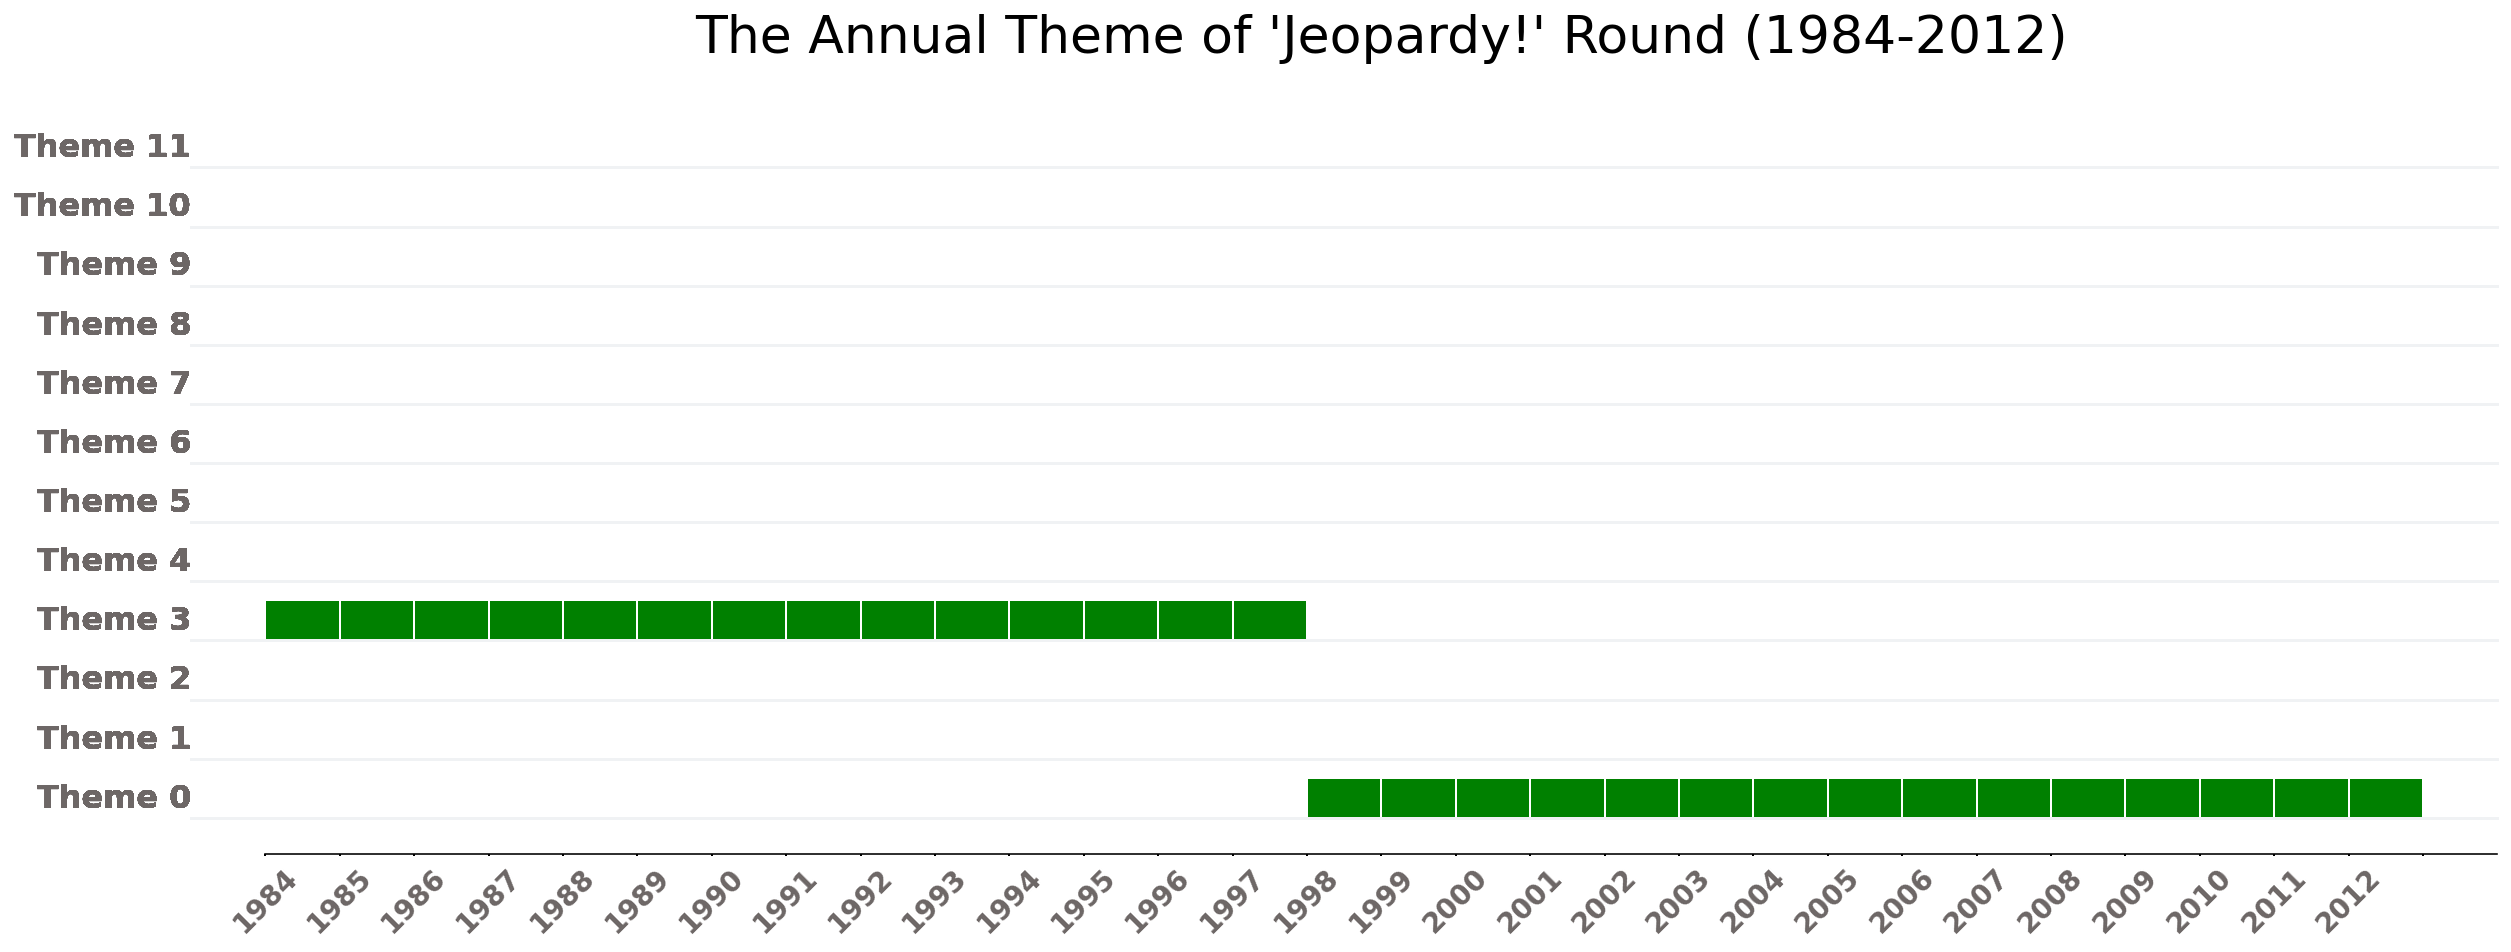

In [33]:
plot_annual_theme(data_jeo, 'Jeopardy!')

The annual theme of the 'Jeopardy!' Portion of the show was consistently at **Theme 3** for 13 years (1984-1997), 
then <br>the theme had changed to **Theme 0** and it stayed consistenyly up until 2012. Overall, the annual themes of 'Jeopardy!' are relatively constant

<br>

## The 'Double Jeopardy' Round Annual Theme

The 'Double Jeopardy!' begins after the 'Jeopardy!' round is finish. The rule of the game stays pretty much the same as the first round. Let's see how 
<br>Annual Theme of the 'Double Jeopardy' changed over time (1984-2012)

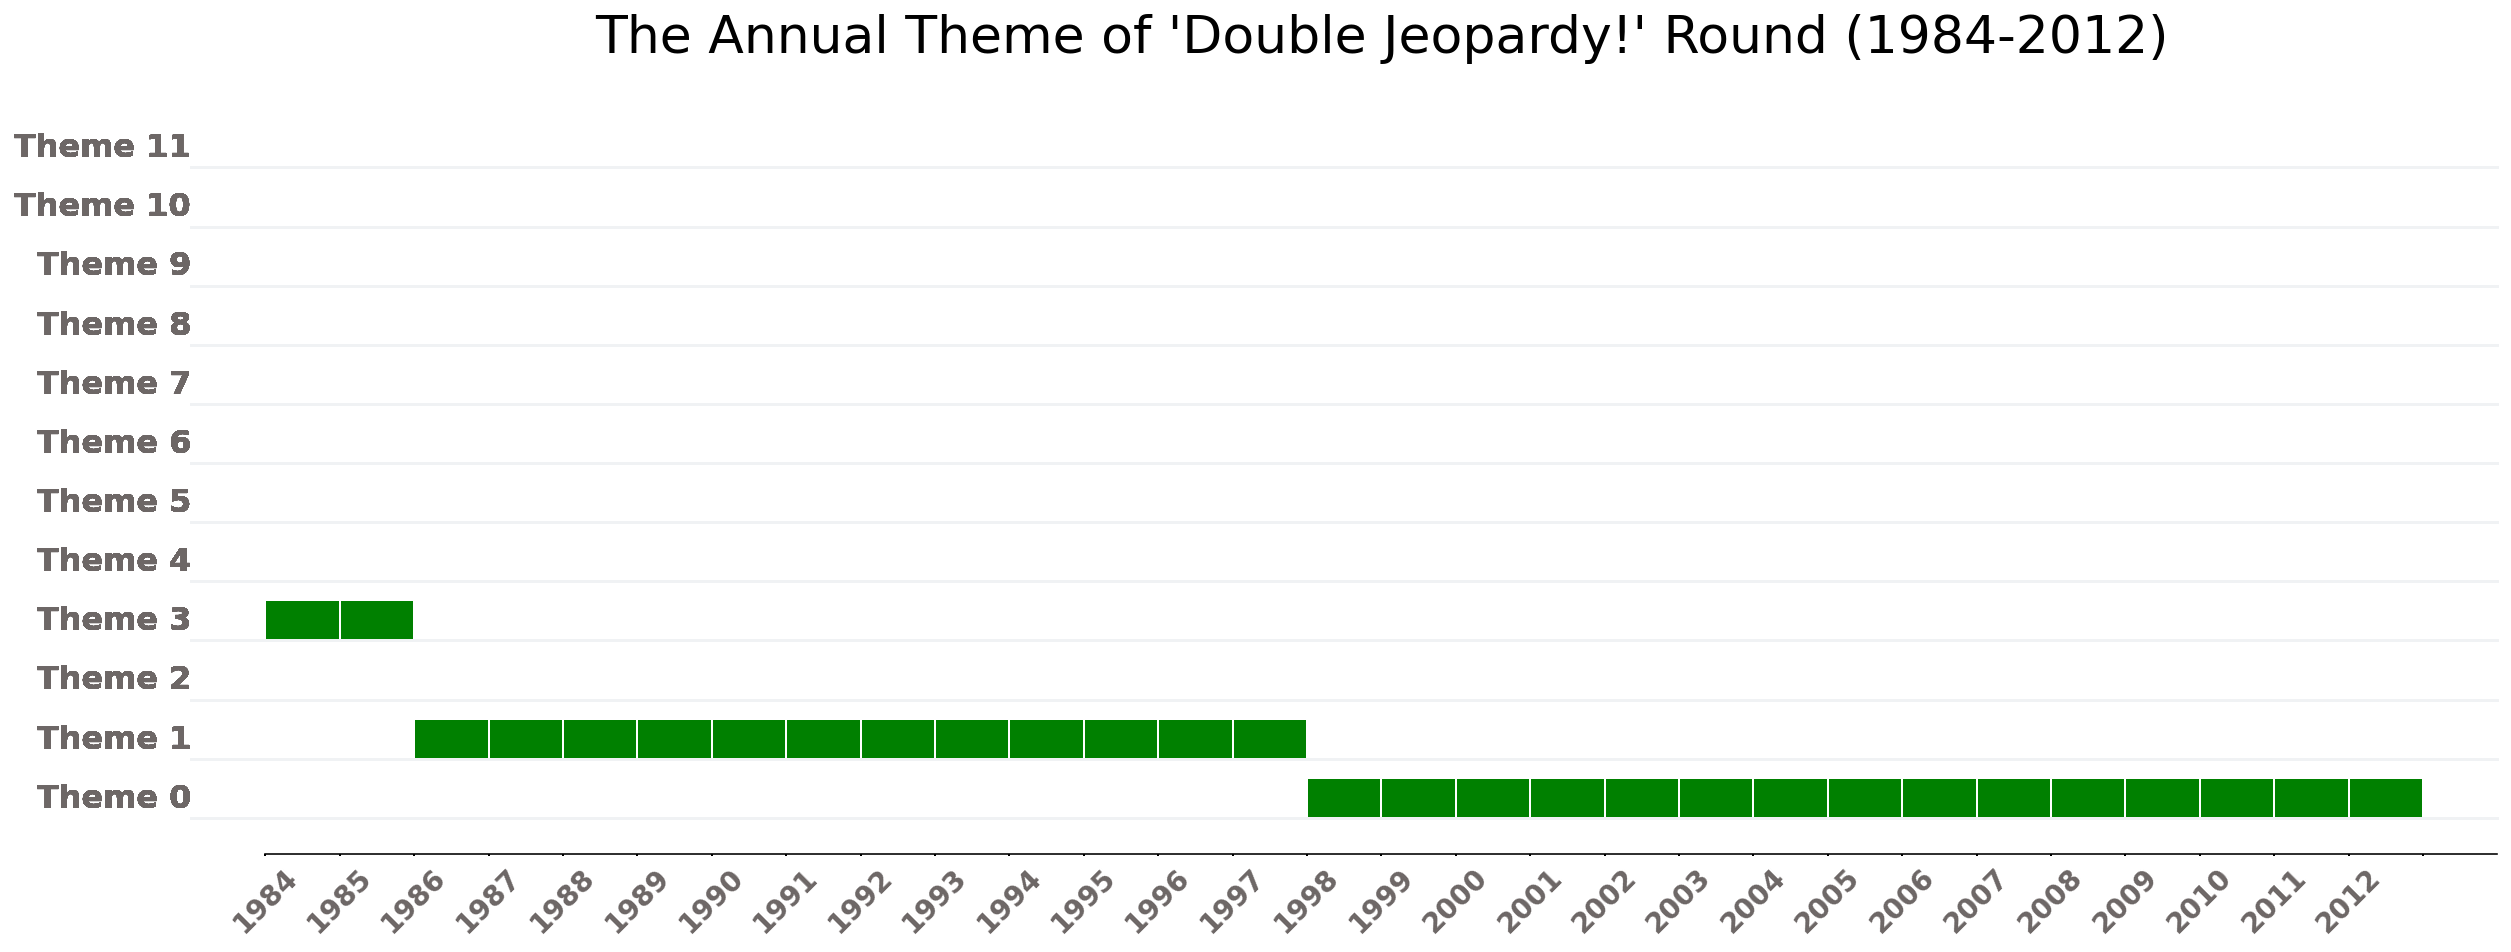

In [34]:
plot_annual_theme(data_double, 'Double Jeopardy!')

The annual theme of the 'Double Jeopardy! Round in 1984-1985 was **Theme 3** which was also the same annual theme as the 'Jeopardy!' round in 1984-1985. Then the annual theme changed-<br>to **Theme 1** and stayed like that for 11 years. Then, **from year 1998 up until 2012, both the 'Double Jeopardy!' and 'Jeopardy!' share the same theme ! which is Theme 0**

<br>

## The 'Final Jeopardy!' Round Annual Theme
In constrast to the first two rounds, The 'Final Jeopardy!' contains only one clue per category. It is considered as the hardest round because this round is going to decide that day winner.<br>
Let's take a look at how The annual theme of 'Final Jeopardy!' changed over the years (1984-2012)

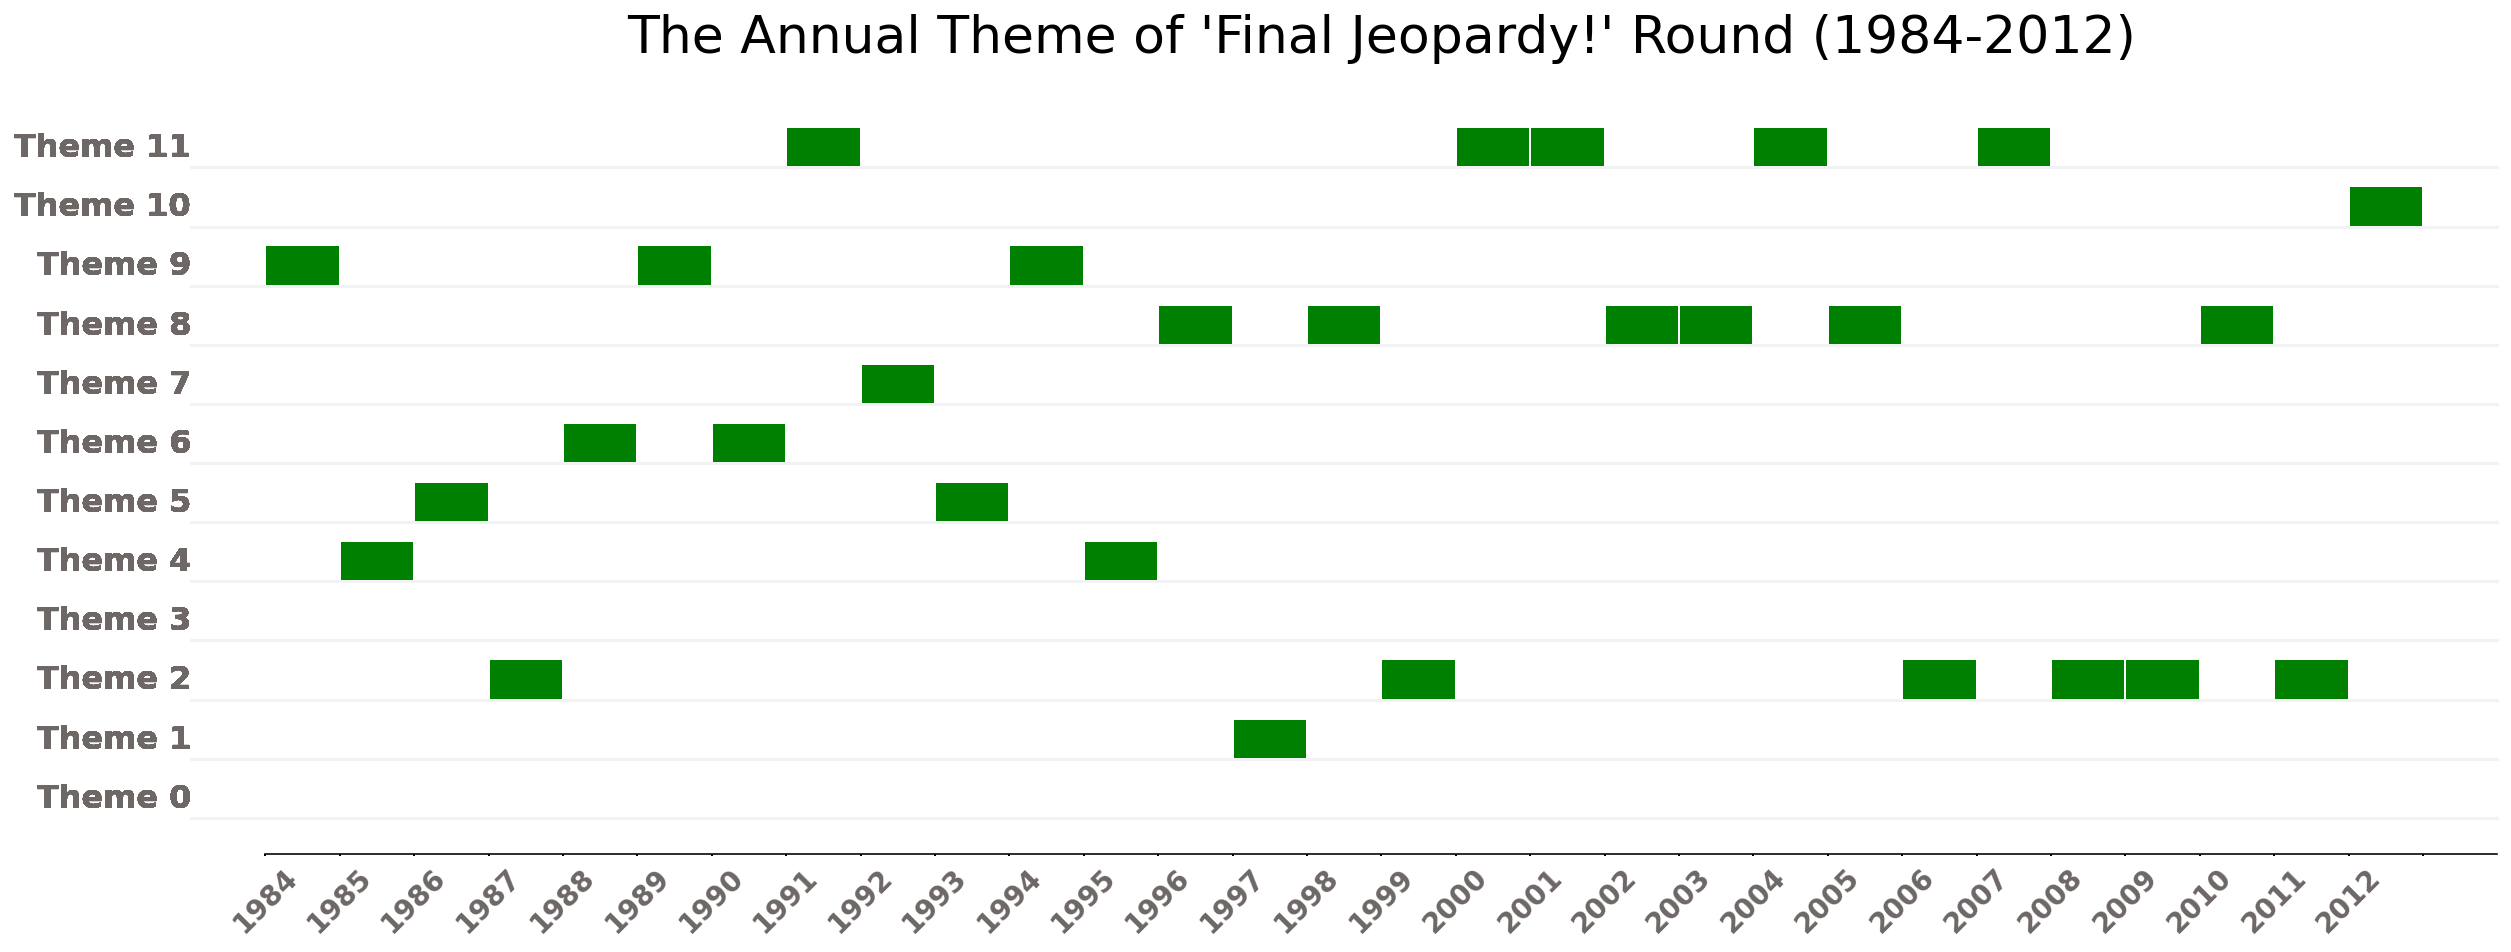

In [35]:
plot_annual_theme(data_final, 'Final Jeopardy!')

We can see that the annual theme of the 'Final Jeopardy!' Round changed almost every year ! That shows why the 'Final Jeopardy!' Round is the hardest round <br>
as the show keeps changing its theme all the time and It also shows that the ranges of the topics that got asked in this round was very wide !

<br>

## Analyzing **themes proportion** of the questions asked in each year and round

In this section Latent Dirichlet Allocation is used to identify themes proportion in each year.

In [36]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.50,
                                   min_df=0.025,
                                   #max_features=20,
                                   stop_words=stop)
X = tfidf_vectorizer.fit_transform(df.docs.values)
feature_names = tfidf_vectorizer.get_feature_names()

In [37]:
lda_model = LatentDirichletAllocation(n_components=12,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(X)

In [38]:
lda_model

LatentDirichletAllocation(n_components=12, n_jobs=-1)

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [39]:
print("Log Likelihood: ", lda_model.score(X))

Log Likelihood:  -391366.7427074403


In [40]:
print("Perplexity: ", lda_model.perplexity(X))

Perplexity:  22.225970226611352


In [41]:
# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Q" + str(i) for i in range(len(df.docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic


In [42]:
df_document_topic

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
Q0         0.04    0.04    0.04    0.60    0.04    0.04    0.04    0.04   
Q1         0.04    0.04    0.04    0.04    0.04    0.04    0.29    0.29   
Q2         0.03    0.62    0.03    0.03    0.03    0.03    0.03    0.03   
Q3         0.04    0.04    0.04    0.04    0.04    0.04    0.29    0.29   
Q4         0.08    0.08    0.08    0.08    0.08    0.08    0.08    0.08   
...         ...     ...     ...     ...     ...     ...     ...     ...   
Q216925    0.04    0.04    0.04    0.04    0.04    0.04    0.29    0.29   
Q216926    0.04    0.04    0.04    0.04    0.04    0.04    0.29    0.29   
Q216927    0.08    0.08    0.08    0.08    0.08    0.08    0.08    0.08   
Q216928    0.08    0.08    0.08    0.08    0.08    0.08    0.08    0.08   
Q216929    0.04    0.04    0.04    0.04    0.04    0.04    0.04    0.04   

         Topic8  Topic9  Topic10  Topic11  dominant_topic  
Q0         0.04    0.04     0.04     0.04               3  
Q1         0.04    0.04     0.04     0.04               6  
Q2         0.03    0.03     0.03     0.03               1  
Q3         0.04    0.04     0.04     0.04               6  
Q4         0.08    0.08     0.08     0.08               0  
...         ...     ...      ...      ...             ...  
Q216925    0.04    0.04     0.04     0.04               6  
Q216926    0.04    0.04     0.04     0.04               6  
Q216927    0.08    0.08     0.08     0.08               0  
Q216928    0.08    0.08     0.08     0.08               0  
Q216929    0.54    0.04     0.04     0.04               8  

[216930 rows x 13 columns]

In [43]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

Topic Num  Num Documents
0           0         101893
1           6          58491
2          11          10760
3           8           9035
4           4           7603
5           1           6149
6           3           5804
7           9           5788
8           2           5373
9          10           5319
10          5            715

Above you can see the topic number distribution for whole dataset.

Lets take a look for years 1985, 1995, 2005 and 2010.

In [44]:
dist_dfs = {}
for year in [1985, 1995, 2005, 2010]:

    mask = df["Air Date"].dt.year==year
    # column names
    topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

    # index names
    docnames = ["Q" + str(i) for i in range(len(df[mask].docs))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output[mask], 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    dist_dfs[year] = df_topic_distribution

In [45]:
colors = ["orange","maroon","darkgreen","gray"]
years = [1985, 1995, 2005, 2010]

Average number of topics for year 1985 : 80
Average number of topics for year 1995 : 103
Average number of topics for year 2005 : 1232
Average number of topics for year 2010 : 1250


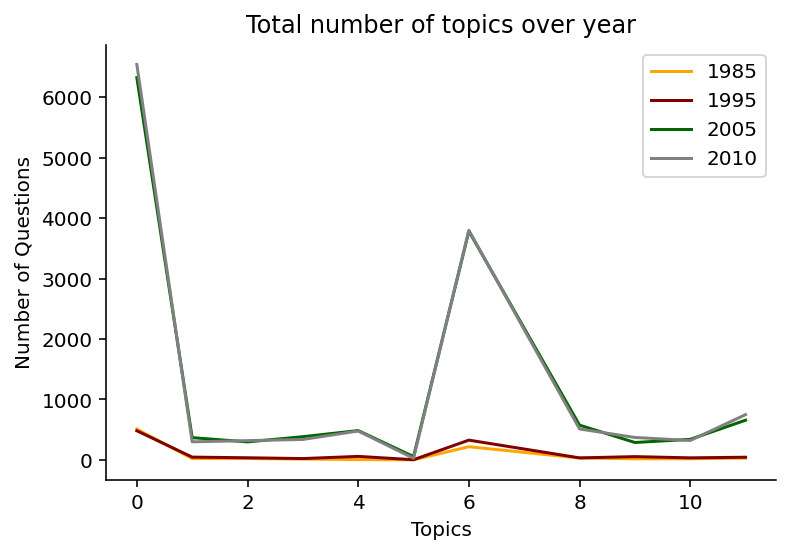

In [46]:
for year,color in zip(years,colors):
    data = dist_dfs[year].sort_values(by="Topic Num")
    plt.plot( data["Topic Num"],data["Num Documents"],color=color,label=str(year))
    print("Average number of topics for year", year,":",int(mean(data["Num Documents"].to_list())))
plt.title("Total number of topics over year")
plt.xlabel("Topics")
plt.ylabel("Number of Questions")
plt.legend()
plt.show()


LDA is applied for topic modelling by using TF-IDF. The number of questions in topic 6 and topic 0 are same for years 2005 and 2010. In addition, 1985 and 1995 have very similar question numbers for each topic.

### Number questions for each round

To see how the topics are changed by year we selected 1995 and 2005 to compare.

#### 1995

In [47]:
rounds = ['Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!']

In [48]:
YEAR = 1995
dist_dfs_r = {}
for r in rounds:

    mask = ((df["Air Date"].dt.year==YEAR) & (df["Round"]==r))
    # column names
    topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

    # index names
    docnames = ["Q" + str(i) for i in range(len(df[mask].docs))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output[mask], 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    dist_dfs_r[r] = df_topic_distribution

Average number of topics for round Jeopardy! : 50
Average number of topics for round Double Jeopardy! : 56
Average number of topics for round Final Jeopardy! : 3


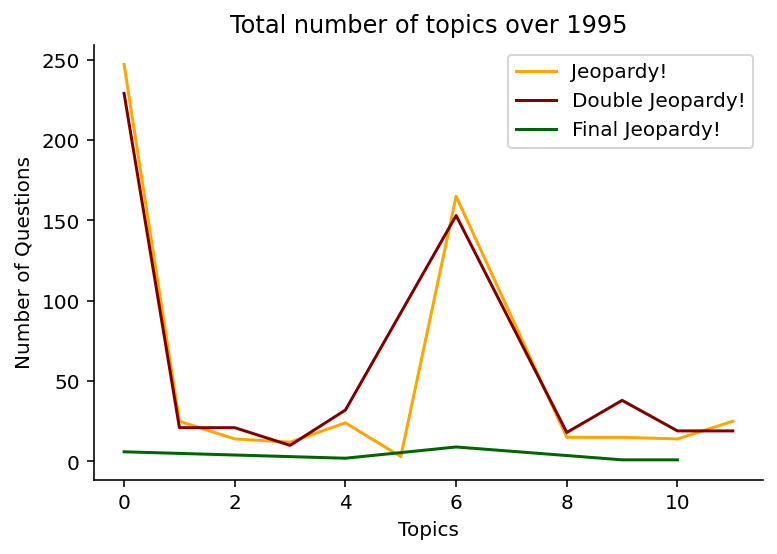

In [49]:
for r,color in zip(rounds,colors):
    data = dist_dfs_r[r].sort_values(by="Topic Num")
    plt.plot( data["Topic Num"],data["Num Documents"],color=color,label=r)
    print("Average number of topics for round", r,":",int(mean(data["Num Documents"].to_list())))

plt.title("Total number of topics over "+str(YEAR))
plt.xlabel("Topics")
plt.ylabel("Number of Questions")

plt.legend()
plt.show()


For year 1995, there is no significant difference between rounds except Topic 6,5 and 0. Jeopardy and Double Jeopardy rounds have higher number of topic 6 and 0 questions in 1995.

#### 2005

In [50]:
YEAR = 2005
dist_dfs_r = {}
for r in rounds:

    mask = ((df["Air Date"].dt.year==YEAR) & (df["Round"]==r))
    # column names
    topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

    # index names
    docnames = ["Q" + str(i) for i in range(len(df[mask].docs))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output[mask], 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    dist_dfs_r[r] = df_topic_distribution

Average number of topics for round Jeopardy! : 610
Average number of topics for round Double Jeopardy! : 601
Average number of topics for round Final Jeopardy! : 20


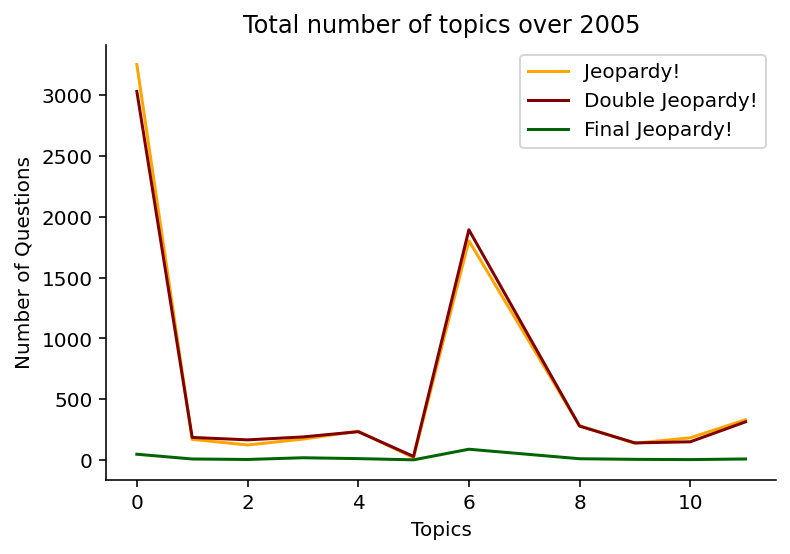

In [51]:
for r,color in zip(rounds,colors):
    data = dist_dfs_r[r].sort_values(by="Topic Num")
    plt.plot( data["Topic Num"],data["Num Documents"],color=color,label=r)
    print("Average number of topics for round", r,":",int(mean(data["Num Documents"].to_list())))

plt.title("Total number of topics over "+str(YEAR))
plt.xlabel("Topics")
plt.ylabel("Number of Questions")
plt.legend()
plt.show()


For year 2005, there is no significant difference between rounds except Topic 6 and Topic 0. Jeopardy and Double Jeopardy rounds have higher number of topic6 and toic 0 questions in 2005. If we compare 1995 and 2005, it can be seen that number of overall questions for each topics are increased by looking y-axis. For example maximum number of questions is 250 for 1995, on the other hand, maximum number of questions is around 3000 for 2005. Finally Final Jeopardy round has the lowest number of questions.

---

## Question 2 - Question Difficulty

In [52]:
df['Value_nums'] = df.Value.str.replace("$","").str.replace(',', '').str.replace('None', "0").astype(int)

In [53]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
jeopardy = df[df['Round'] == "Jeopardy!"]
dub_jeopardy = df[df['Round'] == "Double Jeopardy!"]

#### Distribution of Value Counts

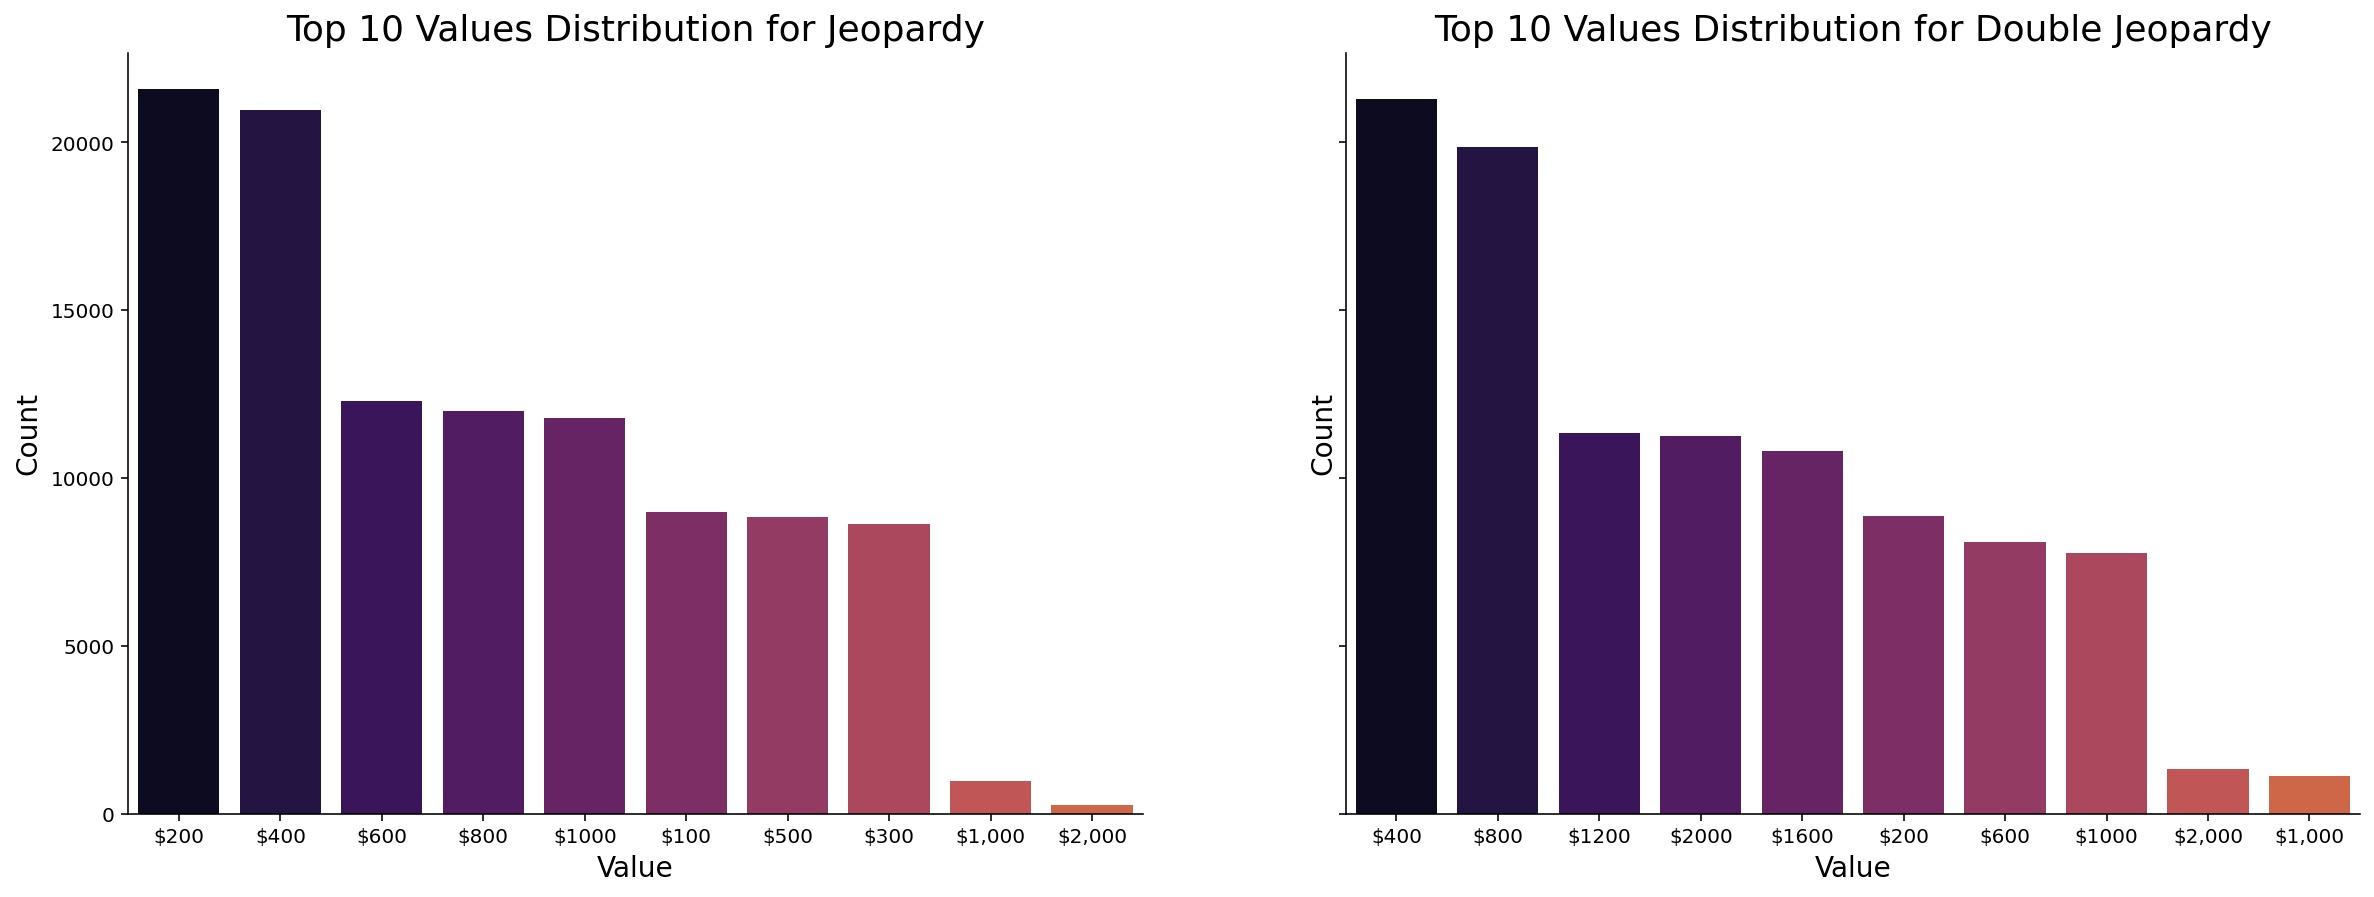

In [55]:
most_jeopardy_values = jeopardy['Value'].value_counts()[:10]
mask = jeopardy['Value'].map(lambda x: x in most_jeopardy_values.index.tolist())

most_dub_jeopardy_values = dub_jeopardy['Value'].value_counts()[:10]
dub_mask = dub_jeopardy['Value'].map(lambda x: x in most_dub_jeopardy_values.index.tolist())

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.countplot(x='Value', data=jeopardy[mask], palette=sns.color_palette('inferno',15),order=most_jeopardy_values.index.tolist(), ax=ax1)
ax1.set_title("Top 10 Values Distribution for Jeopardy", fontsize=18)
ax1.set_xlabel("Value", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
sns.countplot(x='Value', data=dub_jeopardy[dub_mask], palette=sns.color_palette('inferno',15),order=most_dub_jeopardy_values.index.tolist(), ax=ax2)
ax2.set_title("Top 10 Values Distribution for Double Jeopardy", fontsize=18)
ax2.set_xlabel("Value", fontsize=14)
ax2.set_ylabel("Count", fontsize=14)
plt.gcf().set_size_inches(20,7)

plt.show()


### Separate Questions into Monetary Value - Jeopardy

In [56]:
corpus = jeopardy['docs'].values
# Question
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                   #max_features=20,
                                   stop_words='english')
X_question = tfidf_vectorizer.fit_transform(corpus)
feature_names_question = tfidf_vectorizer.get_feature_names()

In [57]:
# Get Topics
num_topics = 12
model = NMF(n_components=num_topics, init='random', random_state=0)
model.fit(X_question)

NMF(init='random', n_components=12, random_state=0)

In [58]:
def add_topics(df_arg, model, tfidf_vectorizer): 
    tot = {}
    for i in df_arg['Value'].unique(): 
        val = df_arg[df_arg["Value"] == i]
        corpus = val['docs'].values
        X = tfidf_vectorizer.transform(corpus)
        W = model.transform(X)
        tot[str(i)] = np.argmax(W, axis=1)
    topics = np.zeros(len(df_arg)).astype(int)
    df_arg['topics'] = topics
    for i in df_arg['Value'].unique(): 
        val = df_arg[df_arg['Value'] == i]
        df_arg.loc[val.index, "topics"] = tot[str(i)]

In [59]:
add_topics(jeopardy, model, tfidf_vectorizer)

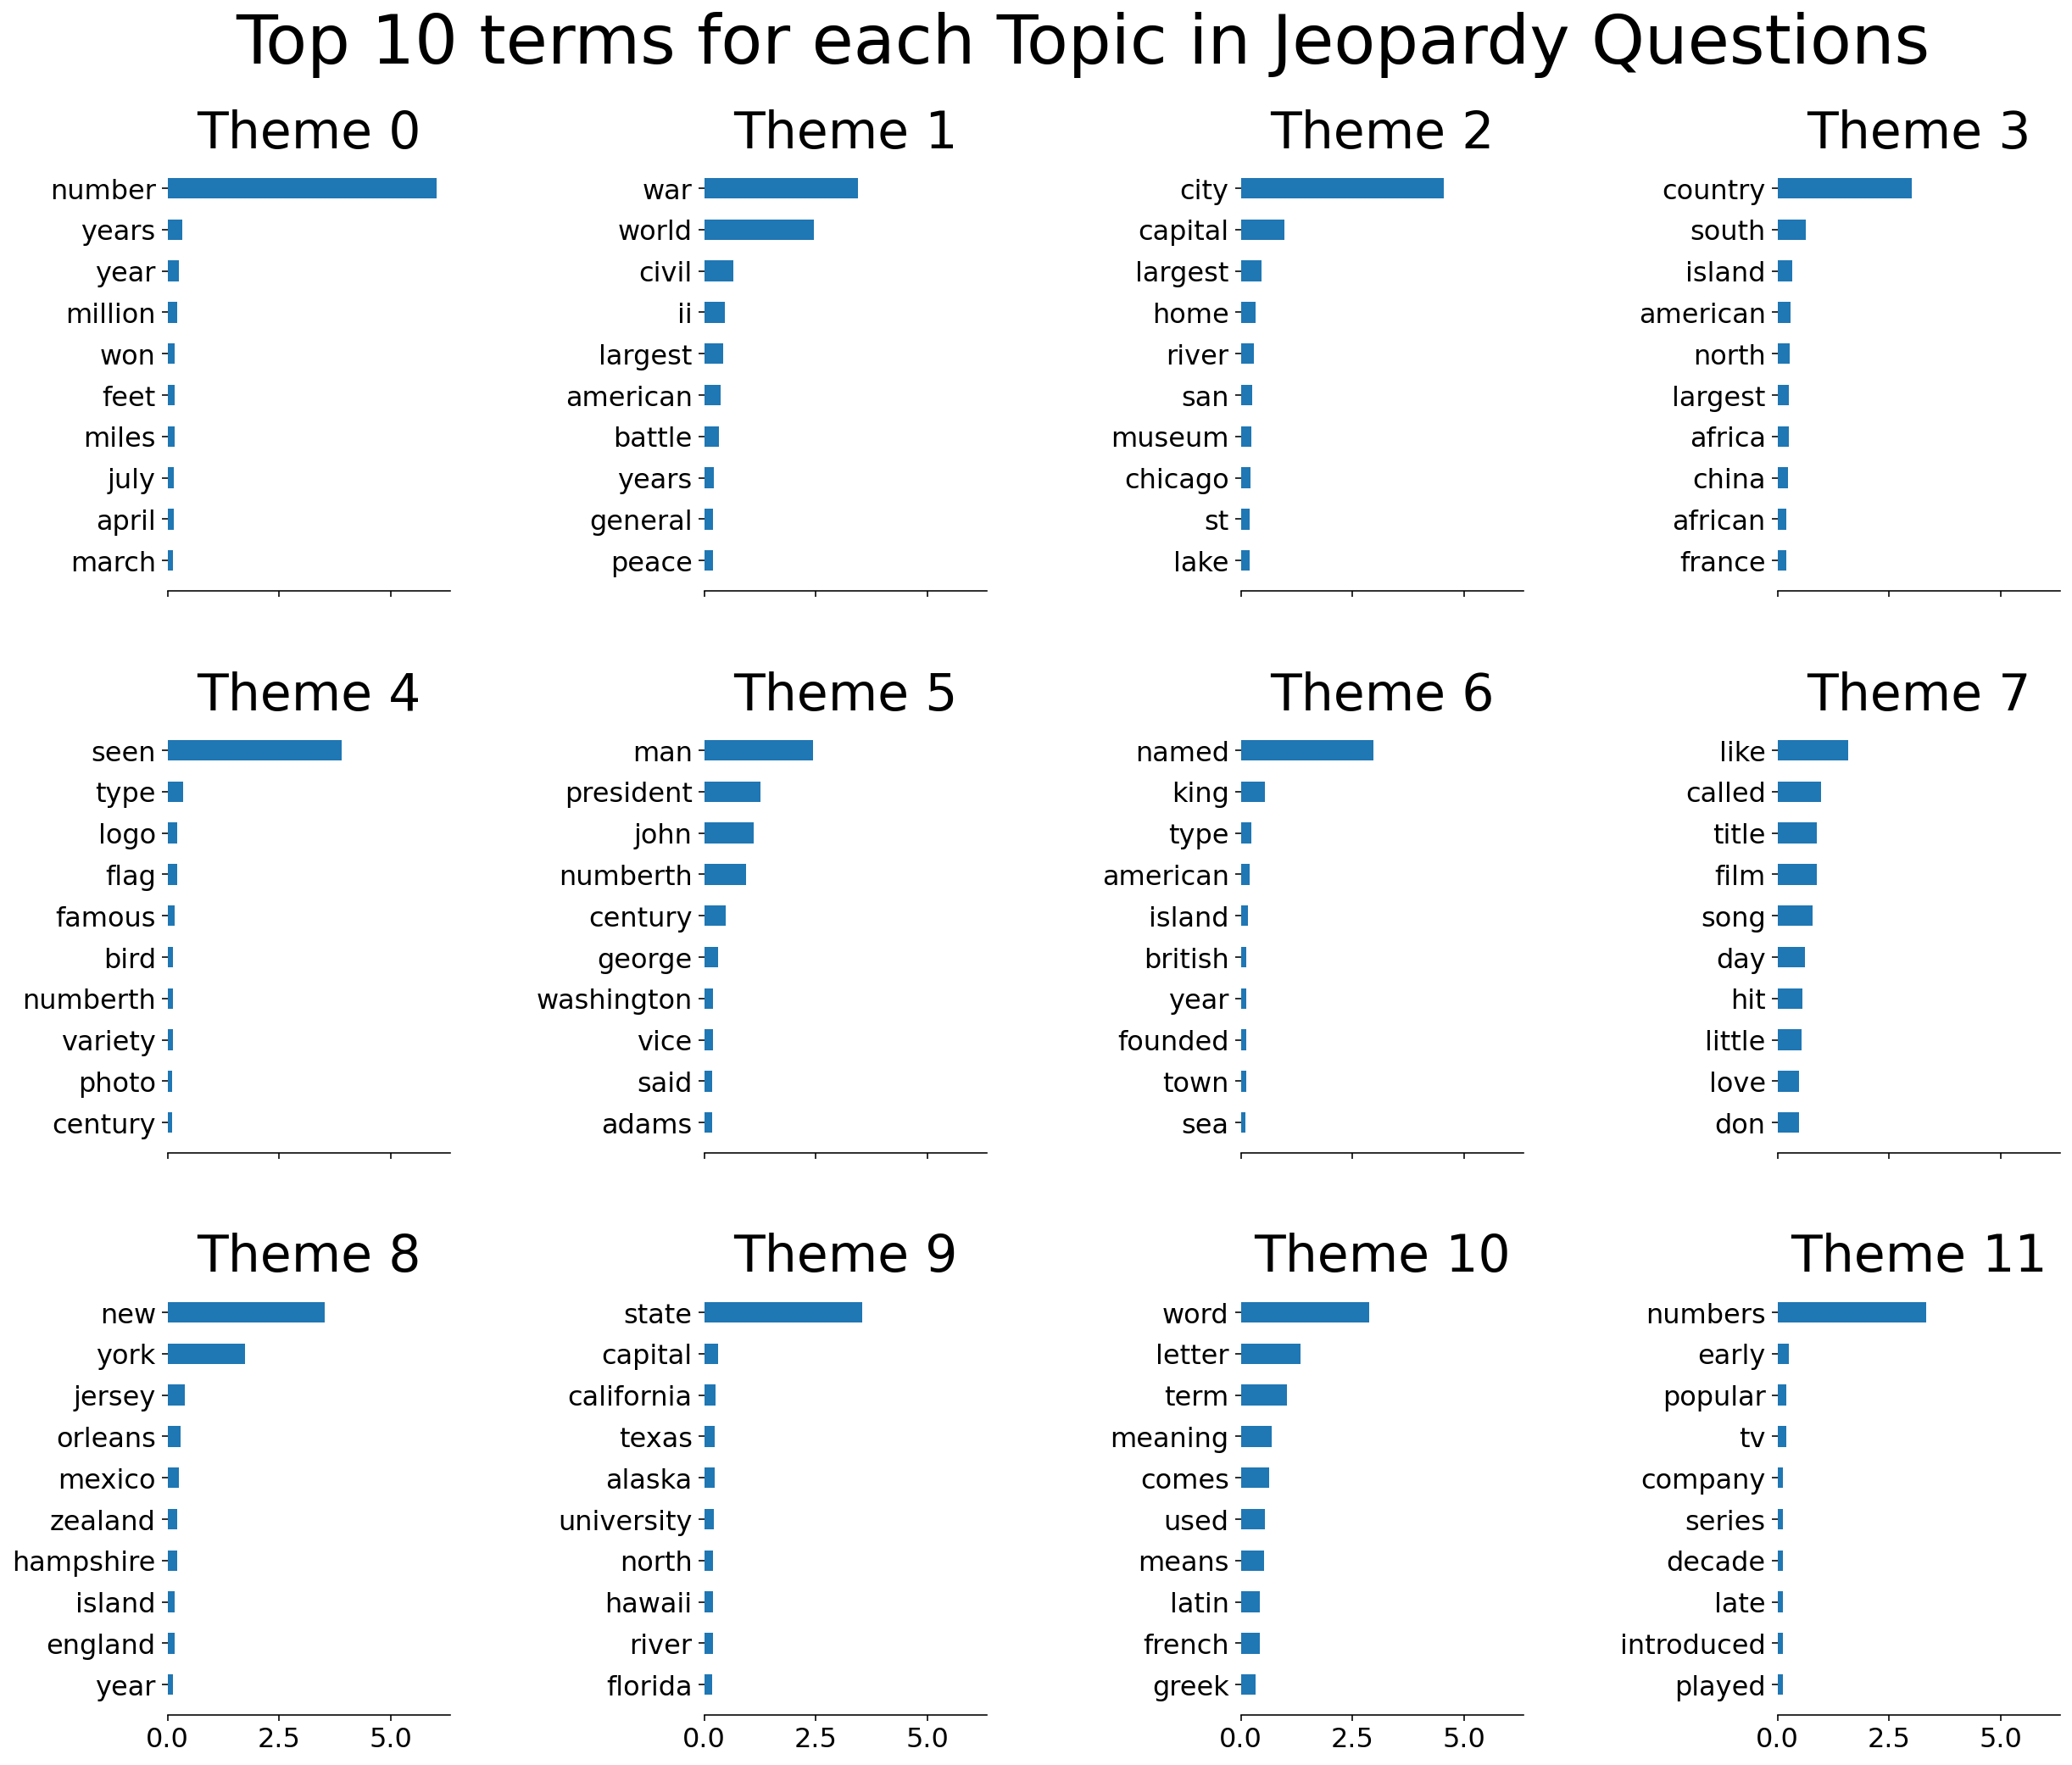

In [60]:
plot_top_words(model, feature_names_question, 10, 'Top 10 terms for each Topic in Jeopardy Questions')

#### Are Topics Inherently Different?

As we can see above with the 12 topics, it looks like topic 0 and topic 11 heavily overlap with the most common word, numbers. There are some differences, for example topic 3 talks more about countries while topic 2 is more about cities and topic 9 is more about states. All of these aspects overlap a bit with topic 8. Lastly, there are topics for leaders such as presidence in topic # 5 and kings and british for topic number 6. 

Overall, some of the topics are inherently different but there are some topics that overlap in words, so we can say this isn't perfect in identifying topics. 

In [61]:
values = jeopardy['Value_nums'].unique()
values.sort()

In [62]:
def show_dist(df_arg, values): 
    for topic_num in range(12): 
        li = []
        idx = []
        for i in values: 
            if len(df_arg[df_arg['Value_nums'] == i]) > 50: 
                val = df_arg[(df_arg['Value_nums'] == i)]['topics']
                if topic_num in val.value_counts().index: 
                    li.append(val.value_counts()[topic_num] / len(val))
                else: 
                    li.append(0)
                idx += [i]
        pd.Series(li, index=idx).plot(kind="bar")
        plt.title(f"Topic Number Distribution: {topic_num}")
        plt.xlabel("Question Value")
        plt.ylabel(f"Ratio of Questions with Topic {topic_num}")
        plt.show()

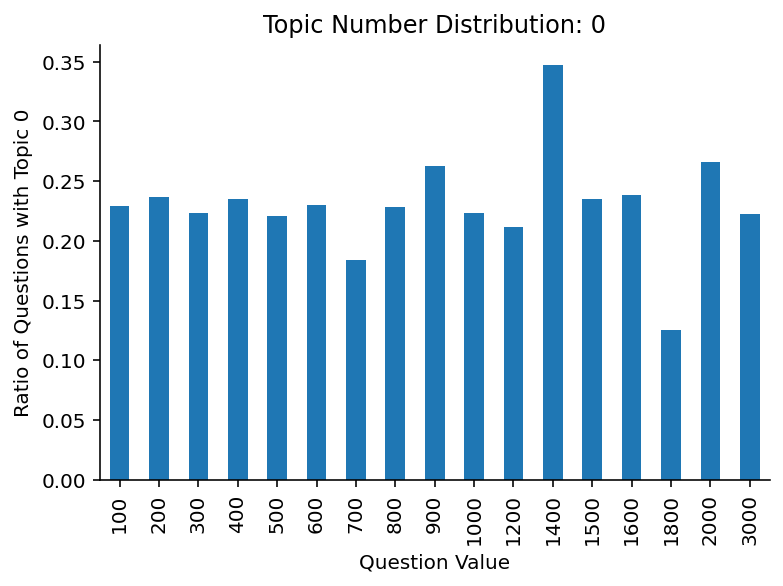

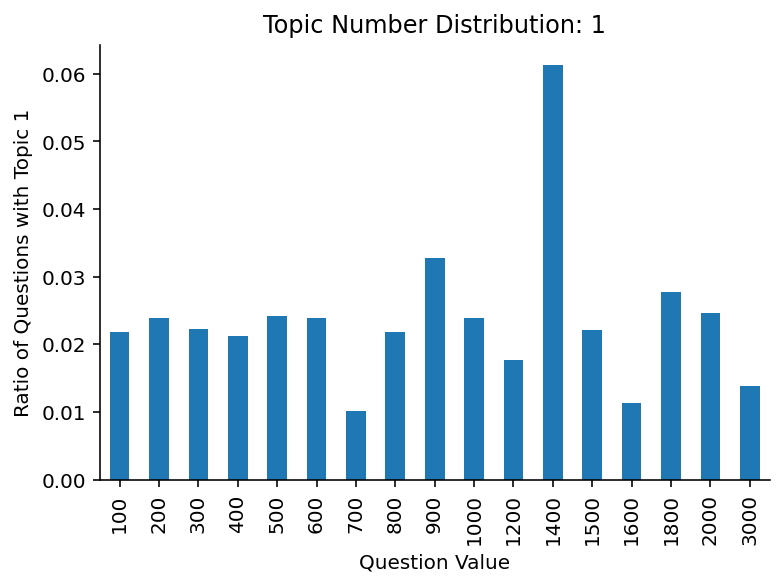

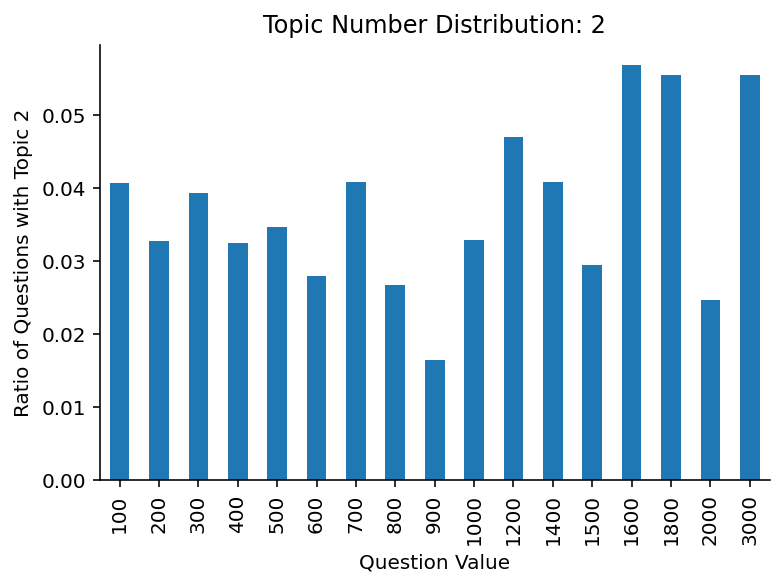

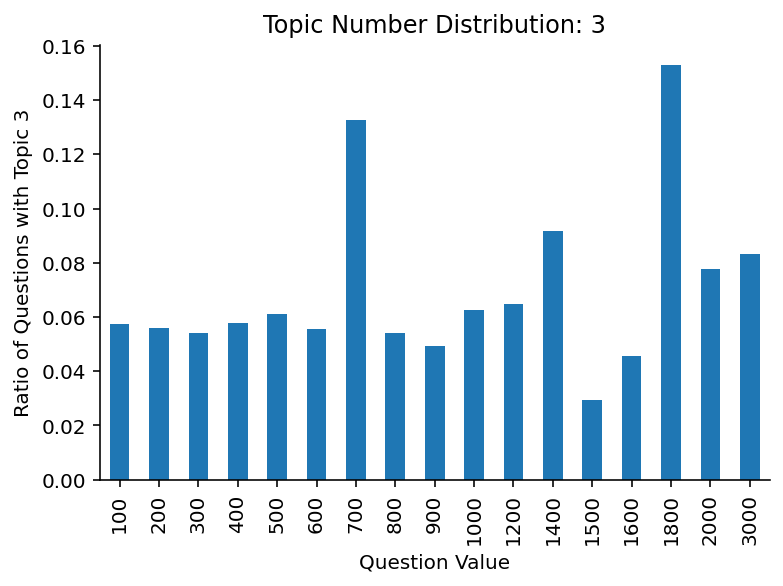

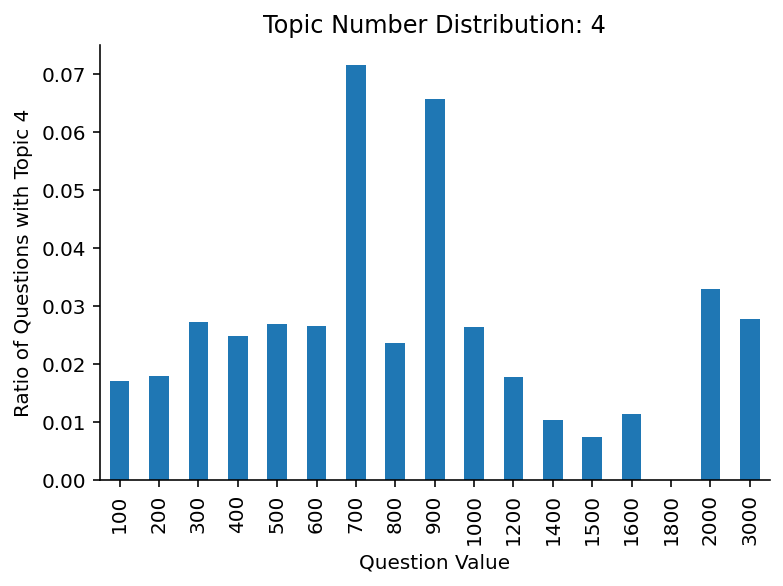

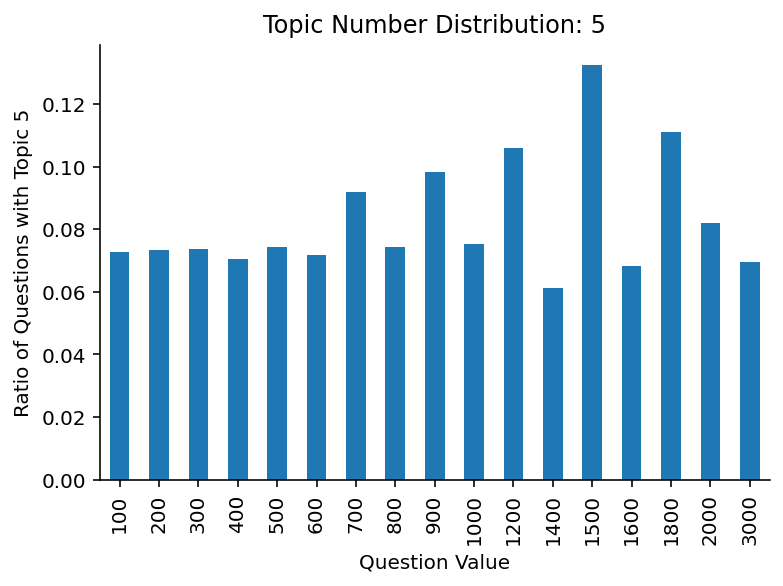

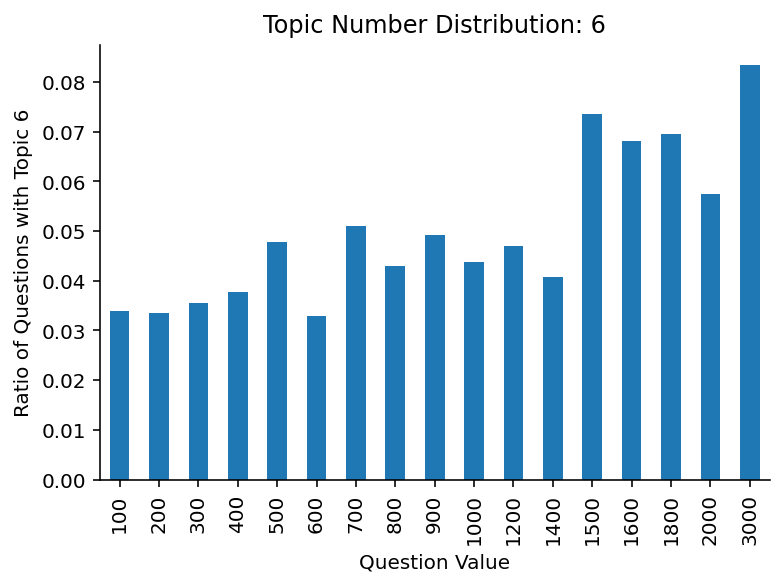

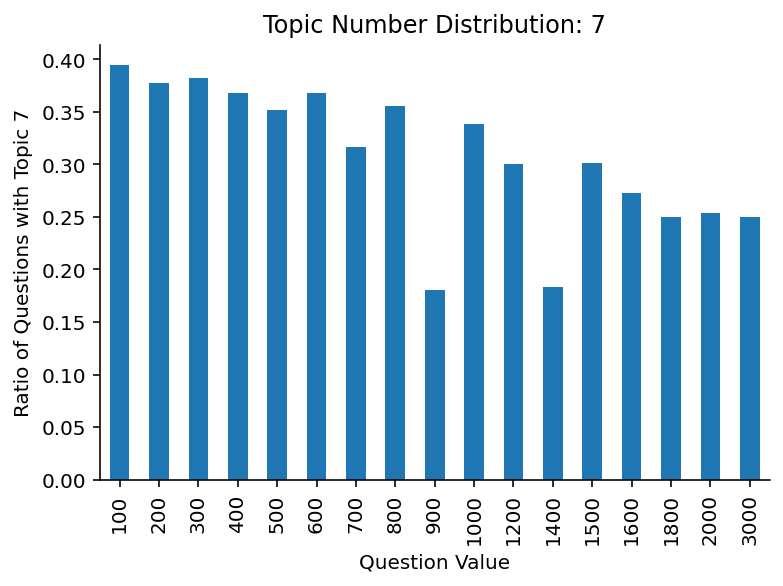

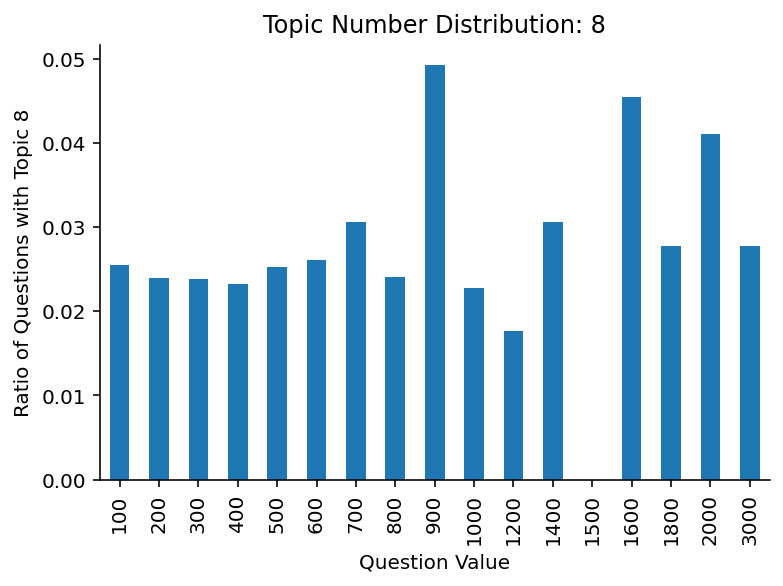

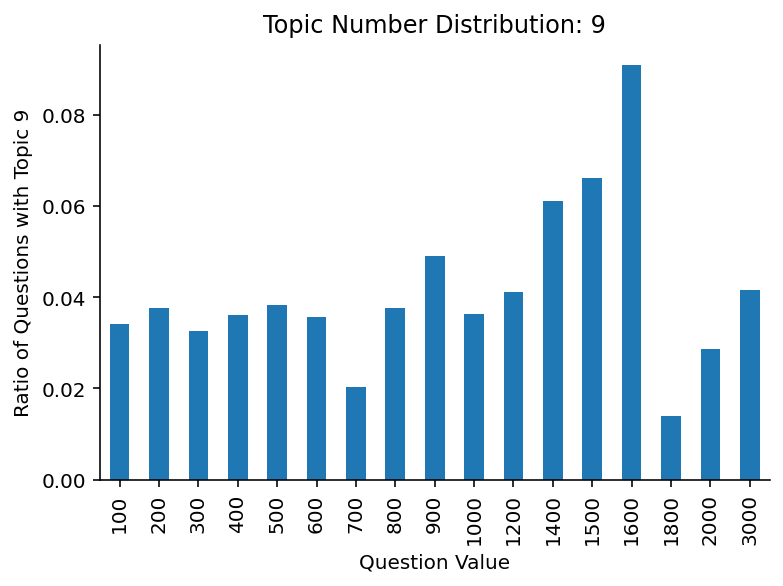

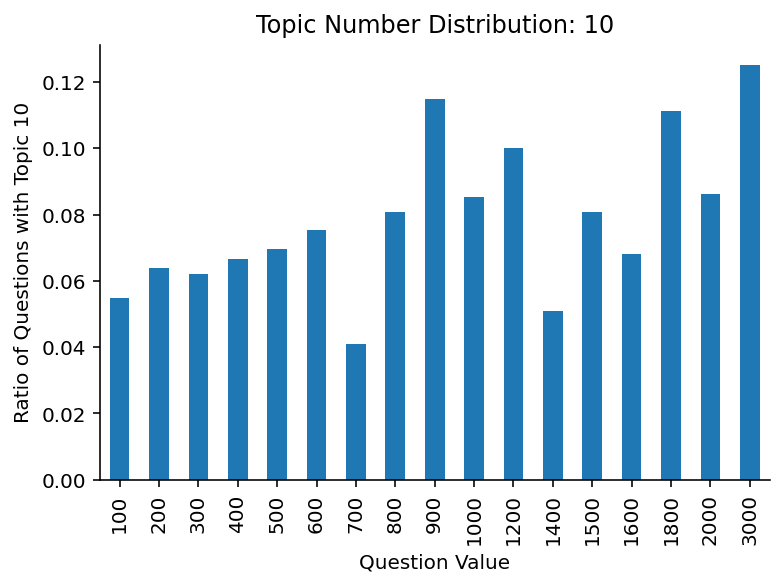

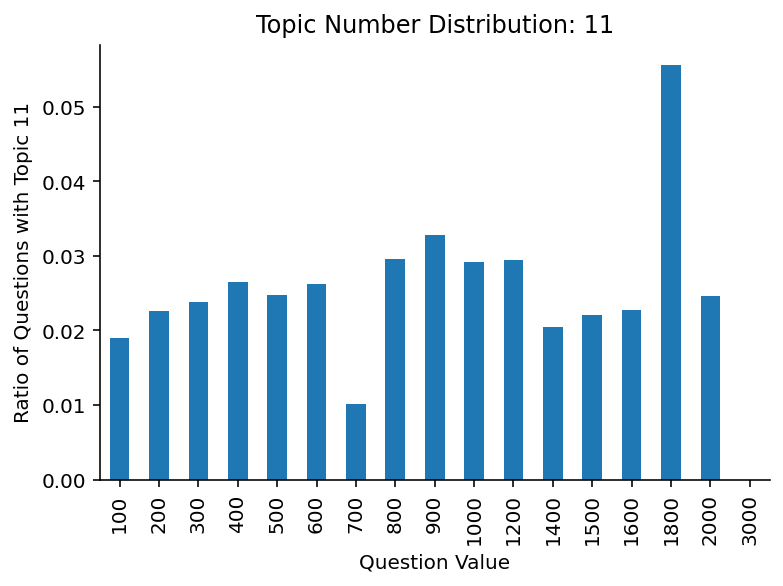

In [63]:
show_dist(jeopardy, values)

The topic distribution was compared using the ratio of the number of questions that have that particular topic since it is the best way to compare across all values. This is because values in jeopardy have different number of observations/questions. In addition, we only took values that had more than 50 observations as too few questions for a value won't give us an idea of any trends. As we can see, there are a few topics that have some sort of trends while most topics don't really have any trends and so the distribution is randomized. For example, questions labeled as topic 10 tends to get increasingly more difficult as the value increases while questions labeled topic number 7 tend to be used less as the value increases, making them a bit easier. Questions with topic number 6 also tend to be more difficult because the ratio of the number of questions with that topic increase as the question value increases. 

### Separate Questions into Monetary Value - Double Jeopardy

In [64]:
corpus = dub_jeopardy['docs'].values
# Question
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                   #max_features=20,
                                   stop_words='english')
X_question = tfidf_vectorizer.fit_transform(corpus)
feature_names_question = tfidf_vectorizer.get_feature_names()

In [65]:
# Get Topics
num_topics = 12
model = NMF(n_components=num_topics, init='random', random_state=0)
model.fit(X_question)

NMF(init='random', n_components=12, random_state=0)

In [66]:
add_topics(dub_jeopardy, model, tfidf_vectorizer)

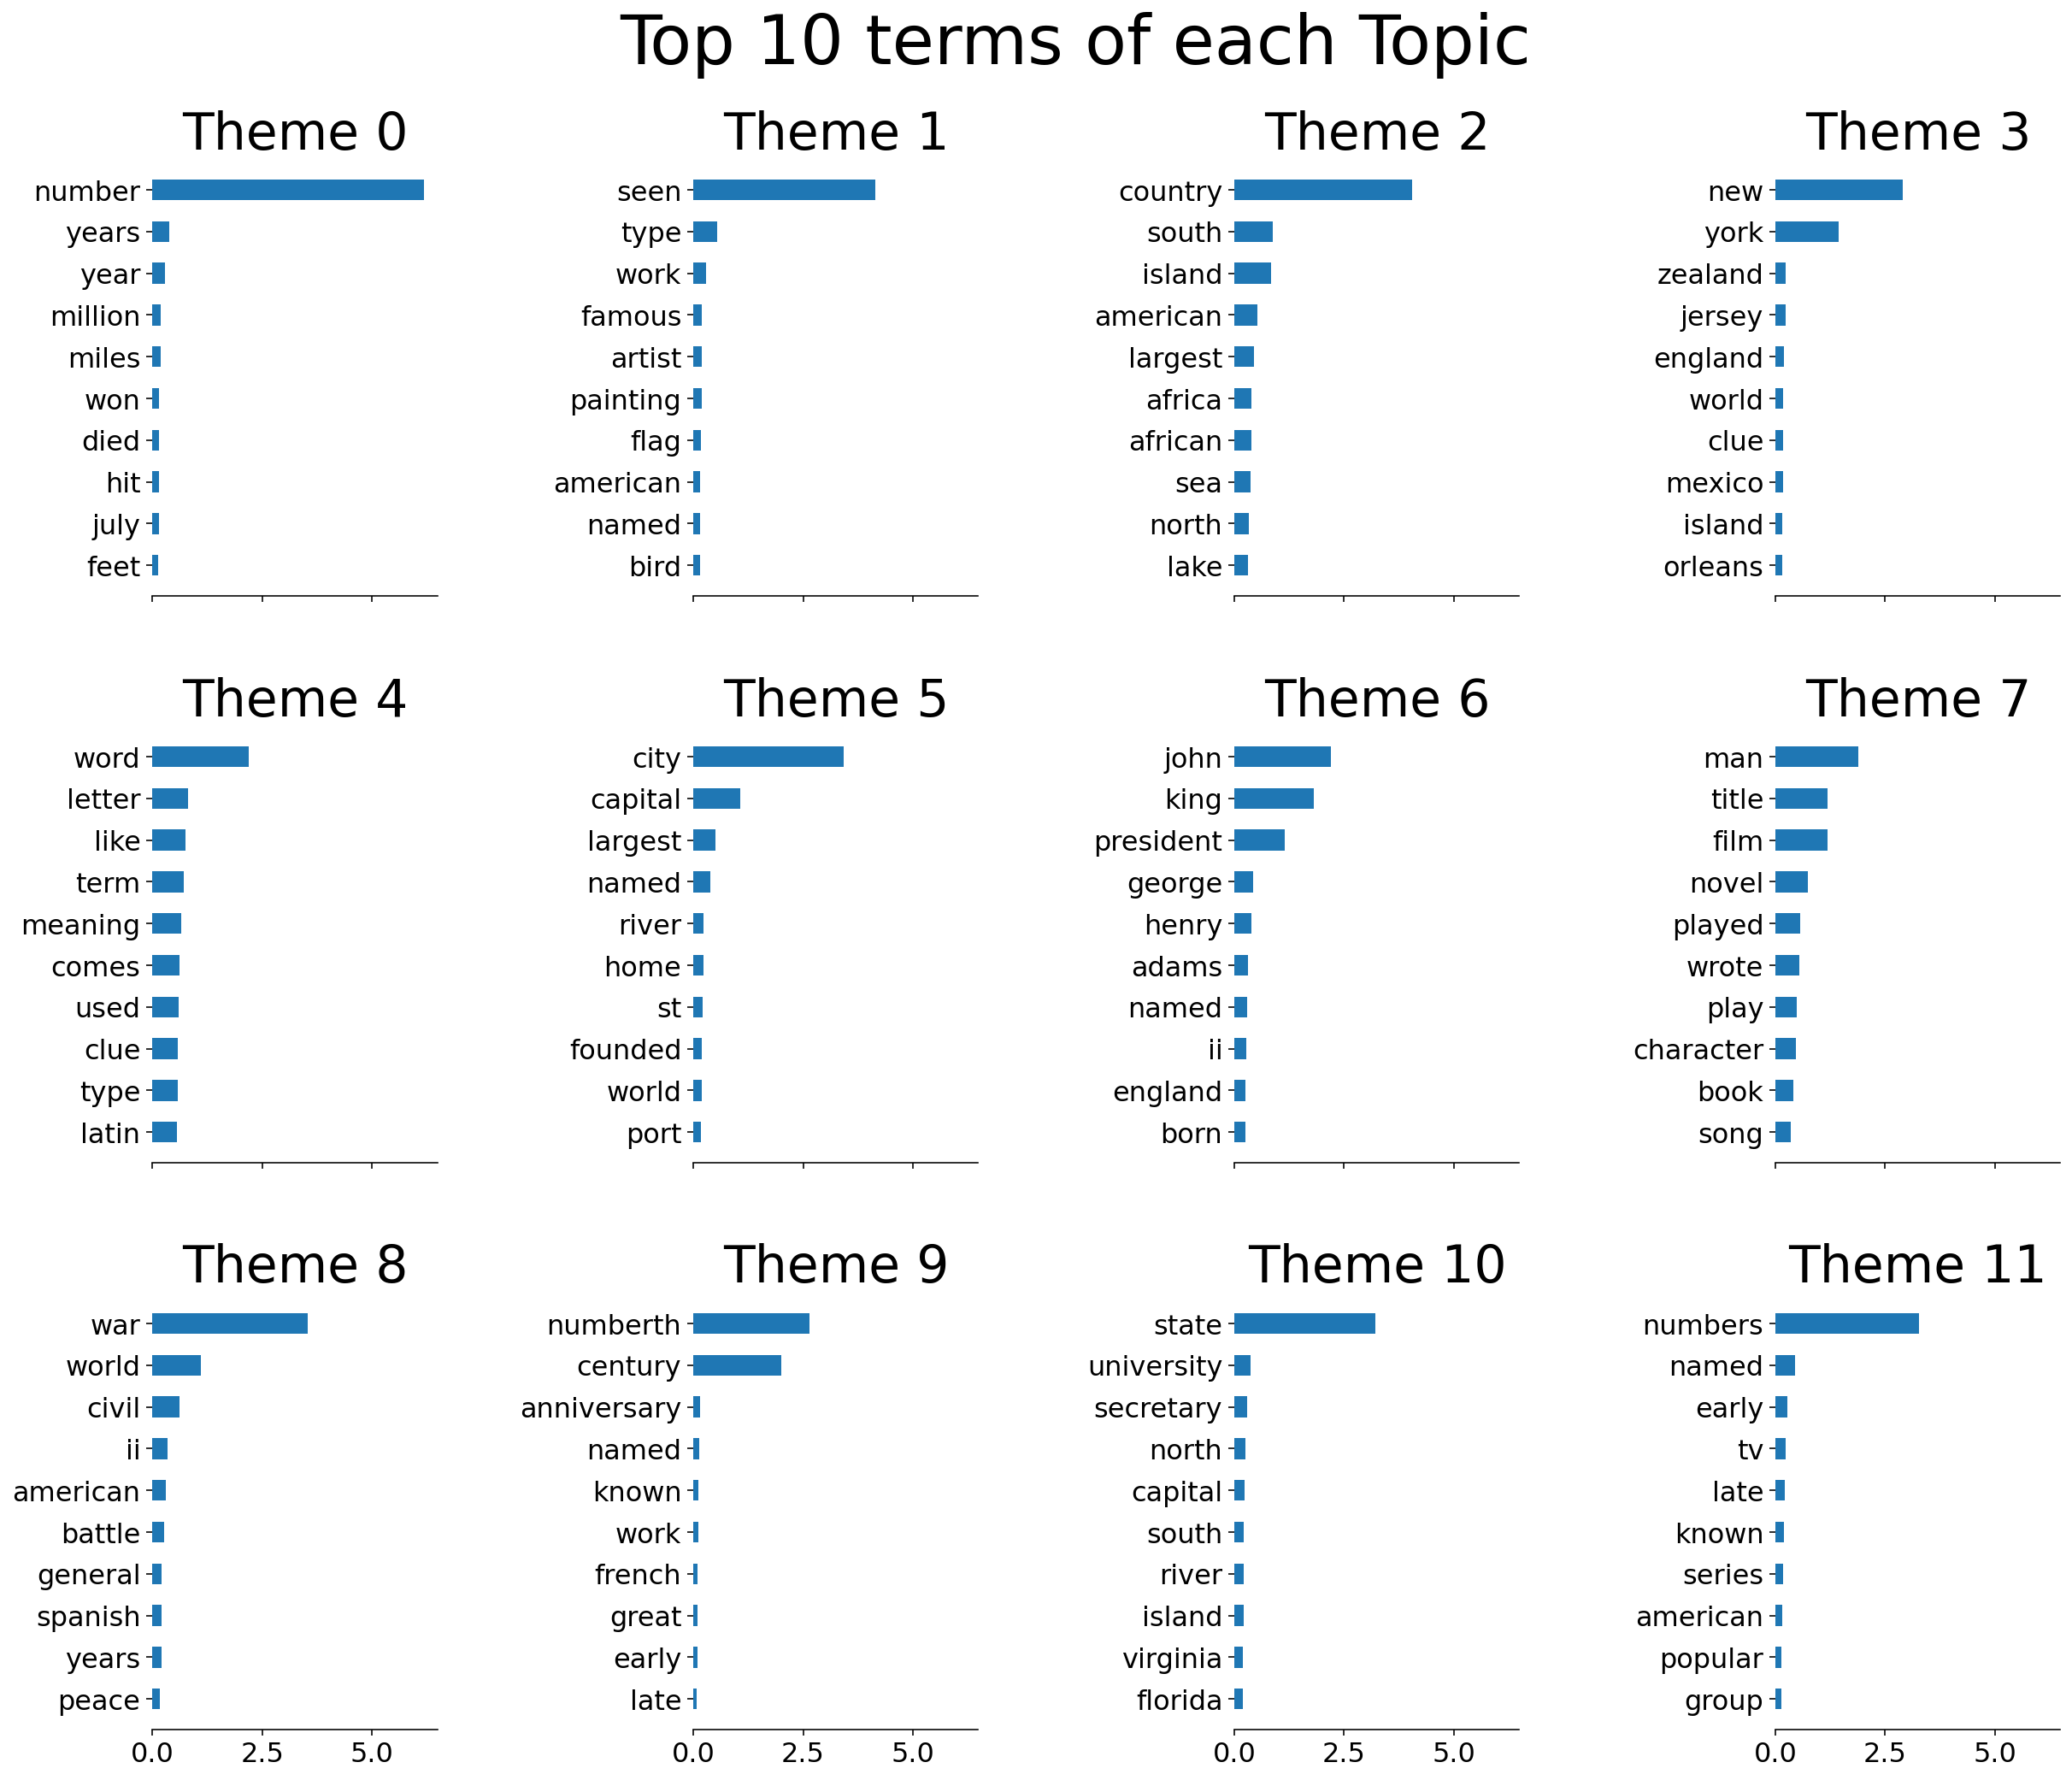

In [67]:
plot_top_words(model, feature_names_question, 10, 'Top 10 terms of each Topic in Double Jeopardy')

As we can see in the plots above,Topics two and three are mostly about places like continent, countries and states. Topic 8 is about war and topic 7 about songs and films. Topic 4 is more of about words and meanings. There is coherence between words in each clustering. In Topics 2 and 3 we can see that the two topics are related about places but the context of topic 2 is more of continent and that of 3 is more of a country and states. Some topics are    


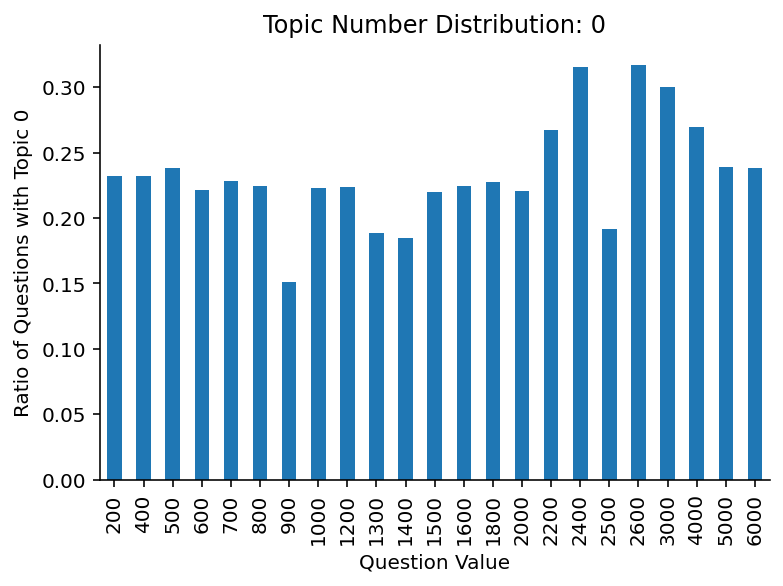

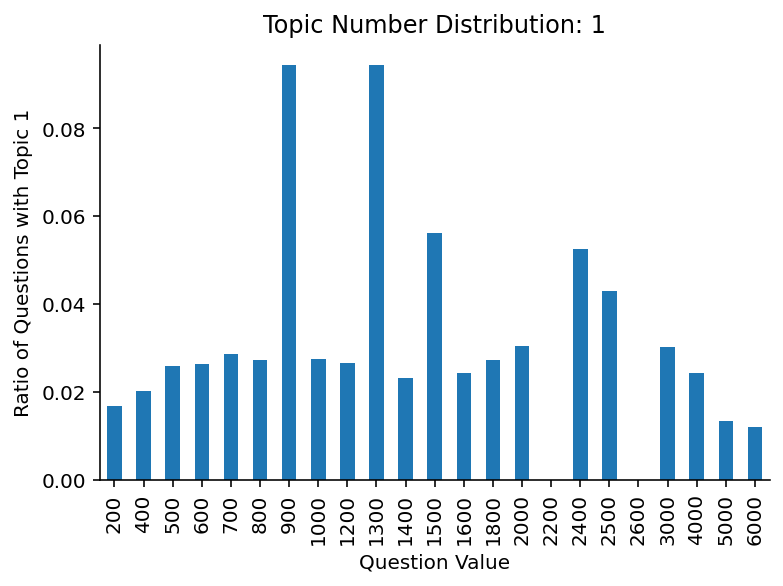

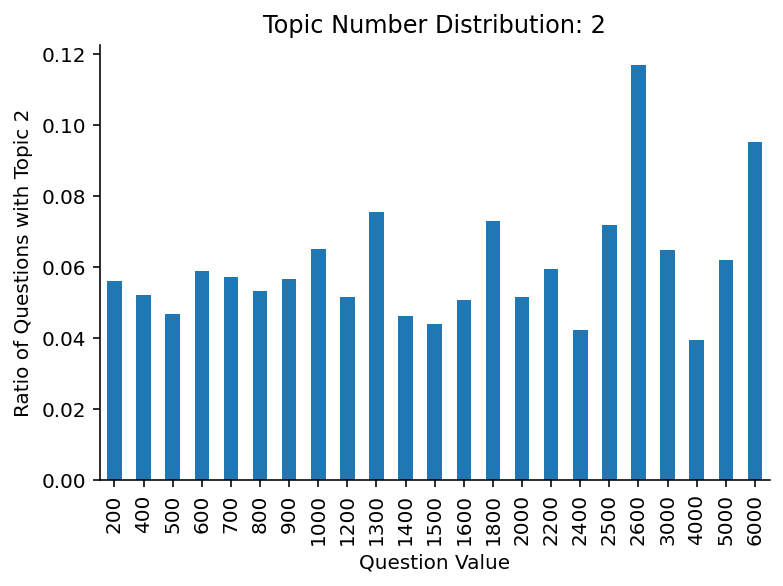

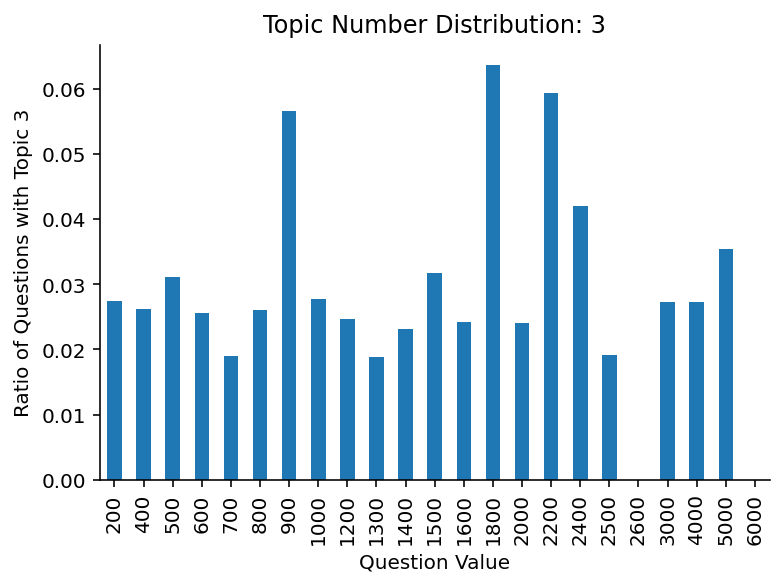

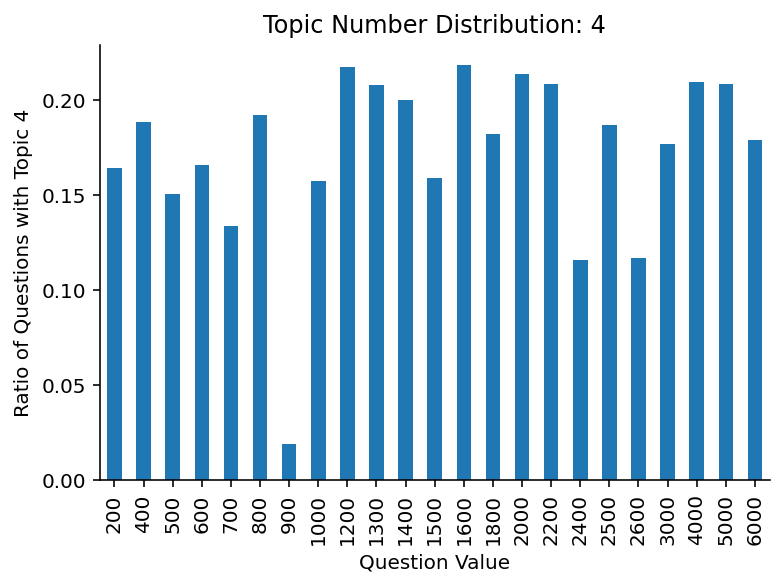

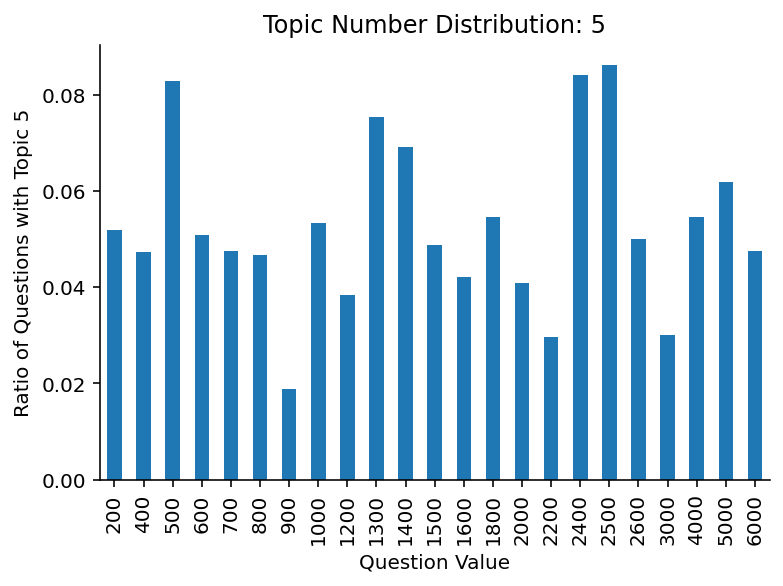

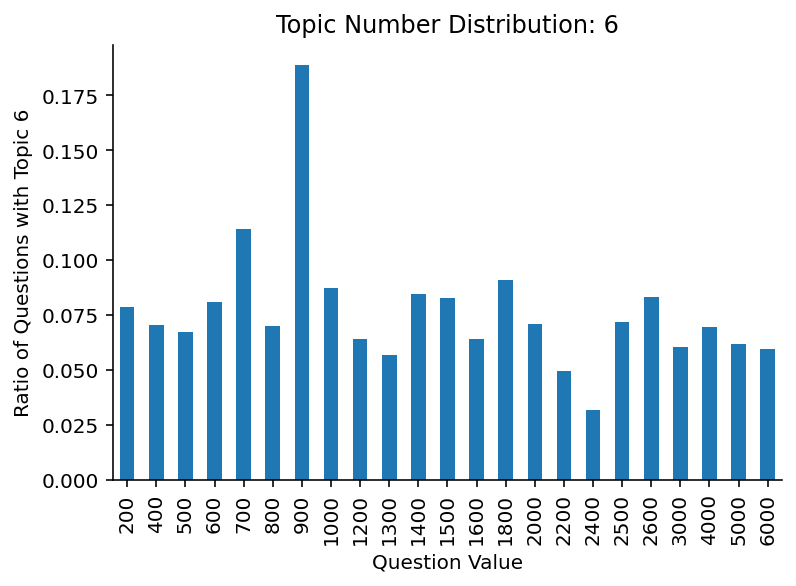

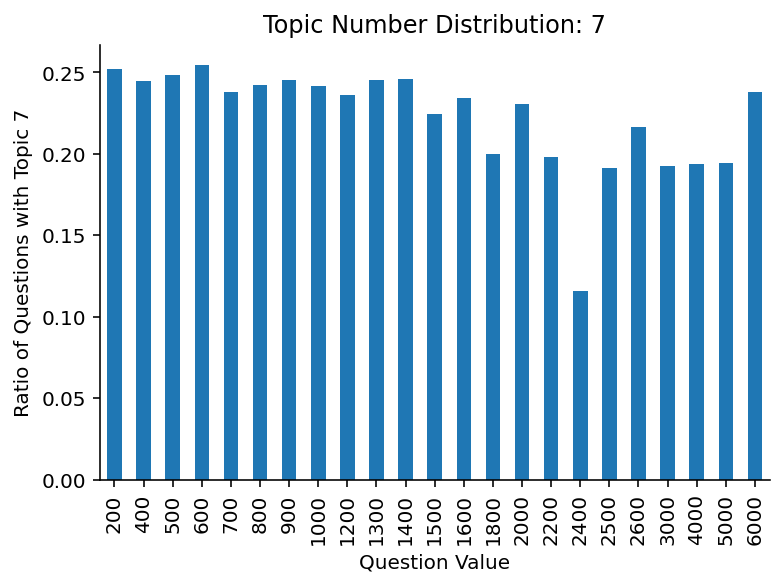

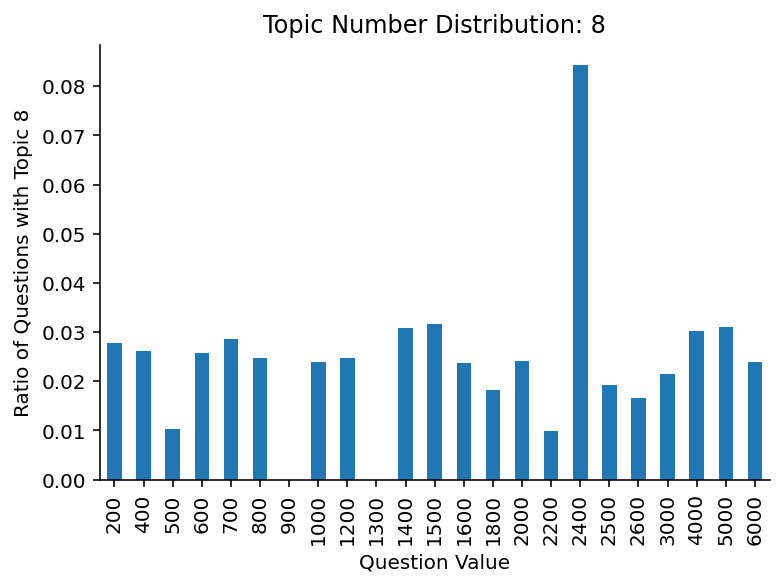

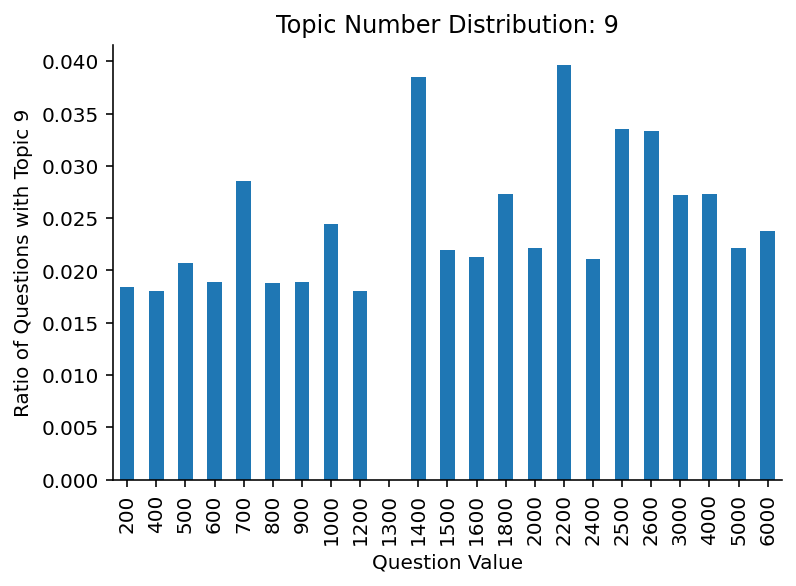

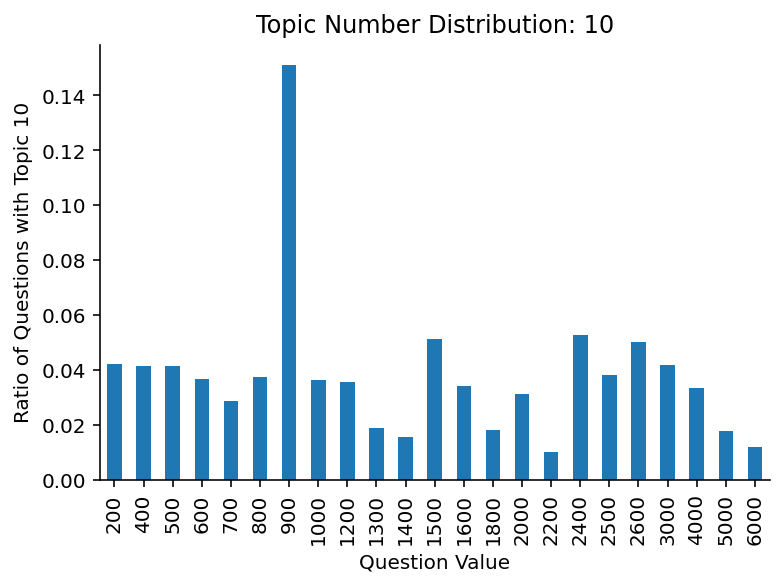

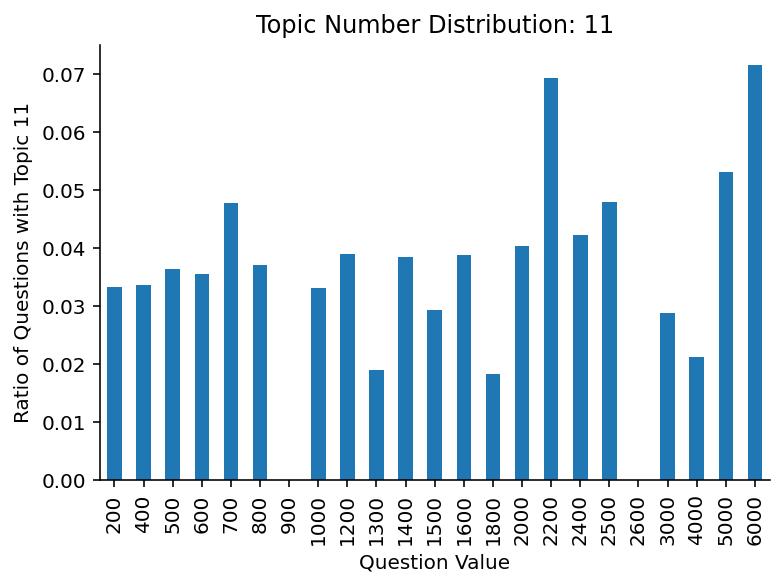

In [68]:
values = dub_jeopardy['Value_nums'].unique()
values.sort()
show_dist(dub_jeopardy, values)

The point values in the second round are worth twice those in the first round (thus the name of “Double Jeopardy” for that second round). After the ratio of the questions are compared among the topics in Double Jeopardy, As we can see in the plots above, the questions in the first topic had the highest ratio at value 2600 and the lowest one at value 900, while the second had the highest at 1300 and the lowest at 2200.Generally topics number 0, 3 and 9 relatively have more difficult questions as compared to others. But most other topics like number 4, 6, 7, which are related to words, ancient history and films/awards respectively have stable distribution of the difficulty of questions(easier and difficult questions are widely distributed)    

Overall, double jeopardy questions are more stable than jeopardy questions, so questions don't seem to get more or less difficult for a particular topic as much as they do in jeopardy. 

### Split Questions by Year - Jeopardy

In [69]:
years = jeopardy['year'].unique()
years.sort()
values = jeopardy['Value_nums'].unique()
values.sort()

In [73]:
vals_used = []
for i in values:
    if len(jeopardy[jeopardy['Value_nums'] == i]) > 50:
        vals_used += [i]

In [84]:
vals_used

[100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1200,
 1400,
 1500,
 1600,
 1800,
 2000,
 3000]

In [91]:
val = jeopardy[(jeopardy['Value_nums'] >= 100) & (jeopardy['Value_nums'] < 600) & (jeopardy['year'] == 2004)]['topics']
val.value_counts()[0] / len(val)

0.2372817008352316

In [102]:
def topics_across_time(jeopardy, years, low, high): 
    for topic_num in range(12): 
        li = []
        for i in range(len(low)): 
            yr_topic = []
            for yr in years: 
                val = jeopardy[(jeopardy['Value_nums'] >= low[i])& (jeopardy['Value_nums'] < high[i]) & (jeopardy['year'] == yr)]['topics']
                if topic_num in val.value_counts().index: 
                    yr_topic.append(val.value_counts()[topic_num] / len(val))
                else: 
                    yr_topic.append(0)
            li += [yr_topic]
        plt.rcParams["figure.figsize"] = (20,10)
        for i in np.arange(len(li)): 
            topic_dist = li[i]
            pd.Series(topic_dist, index=years).plot.line()
            plt.title(f"Topic Number Distribution: {topic_num}")
            plt.xlabel("Question Value")
            plt.ylabel(f"Ratio of Questions with Topic {topic_num}")
        plt.legend(labels=['Easy', 'Medium', 'Hard'])
        plt.show()

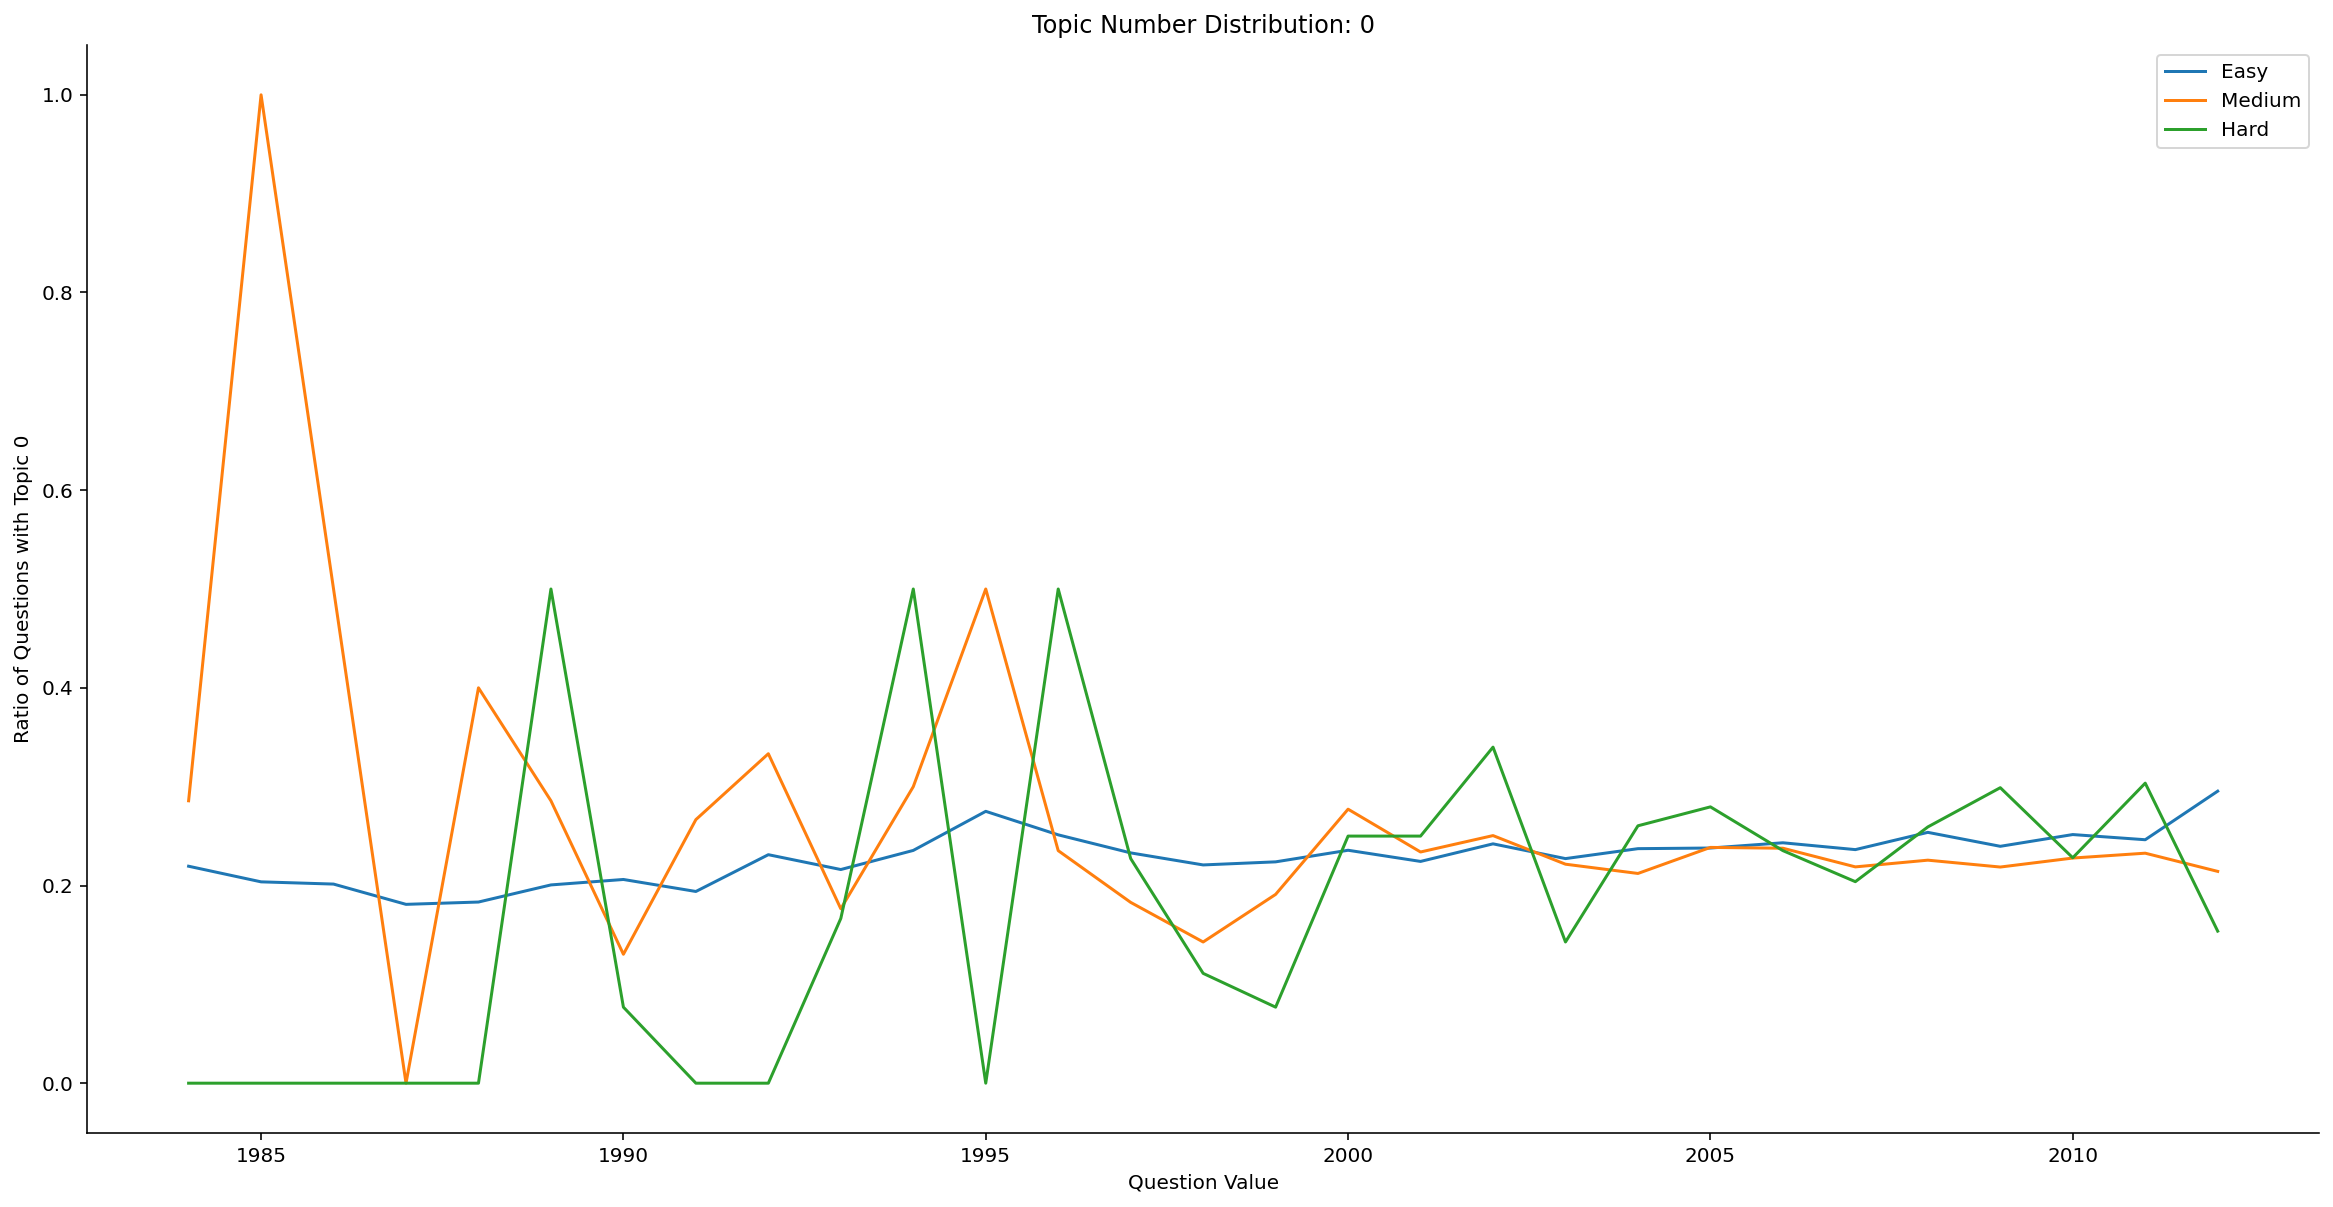

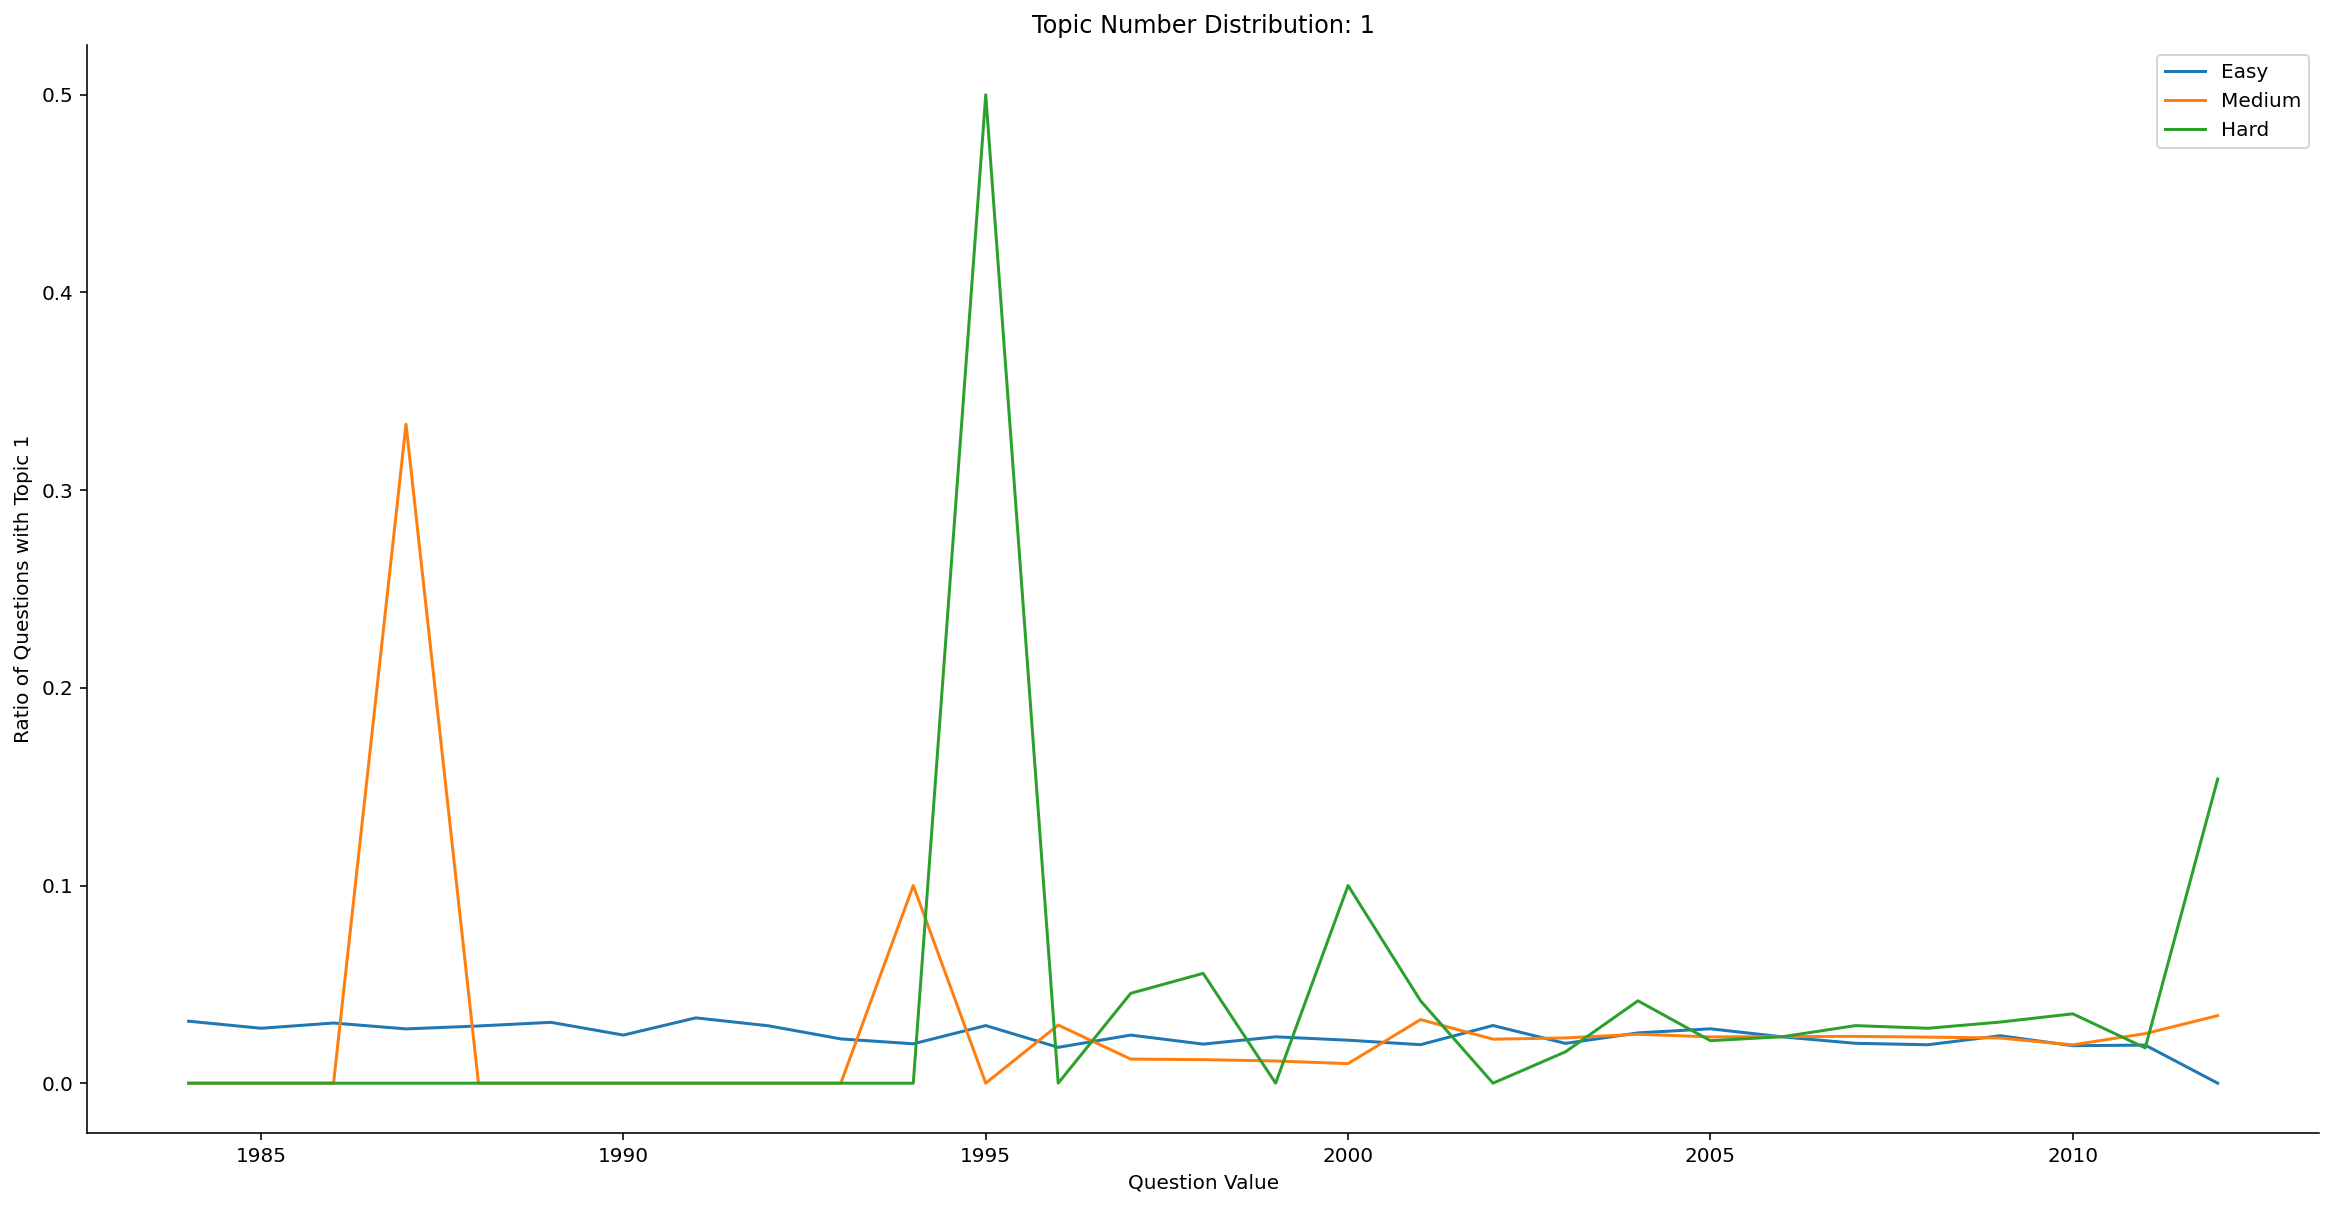

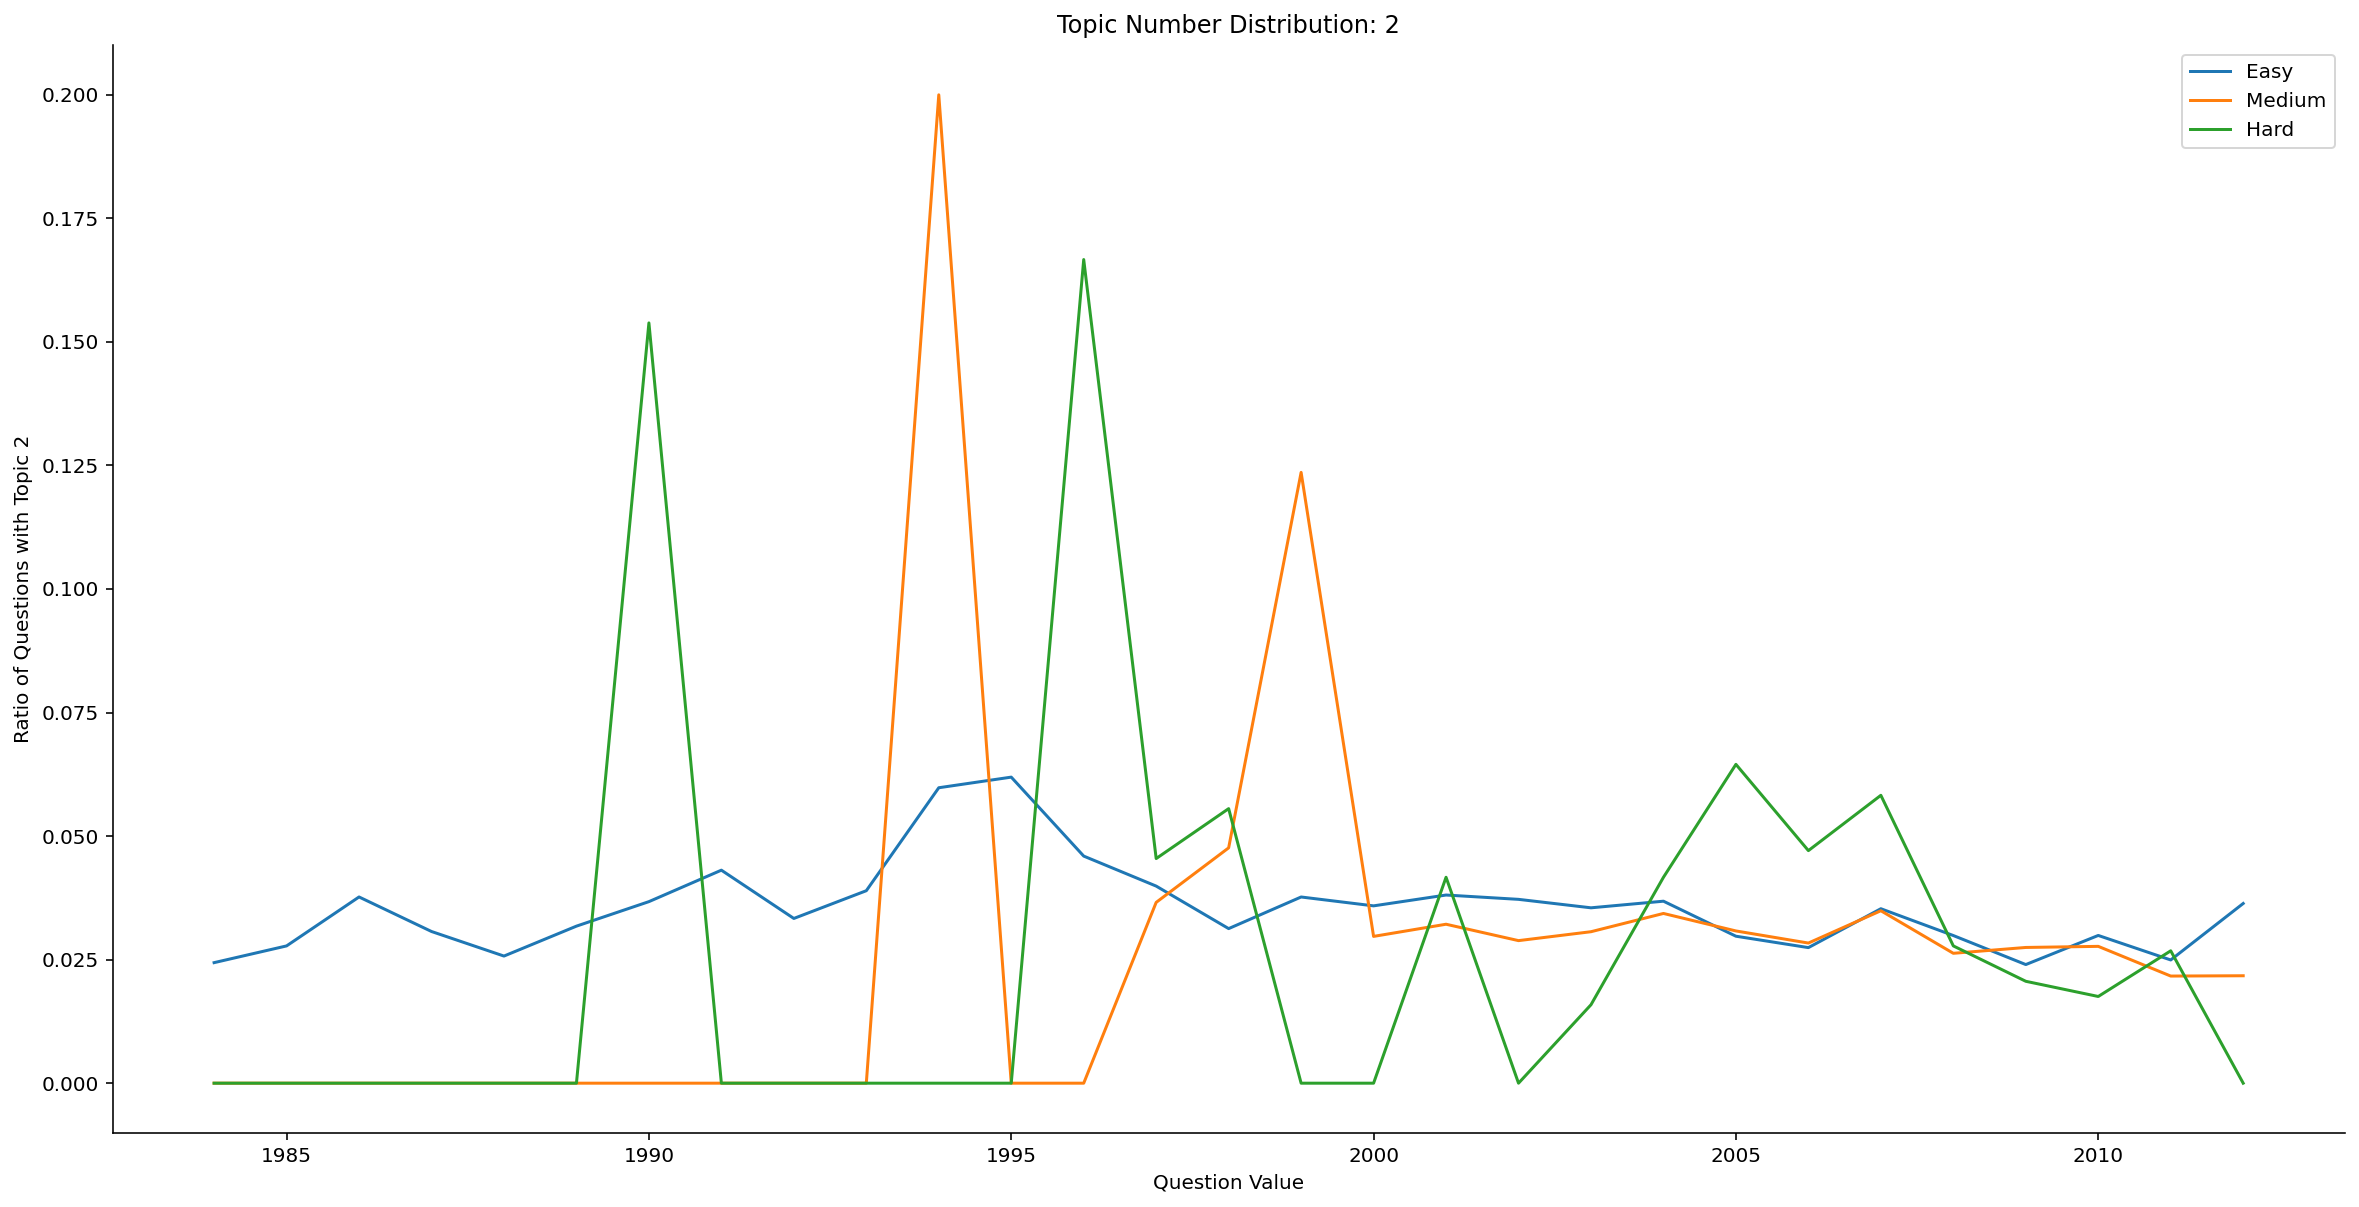

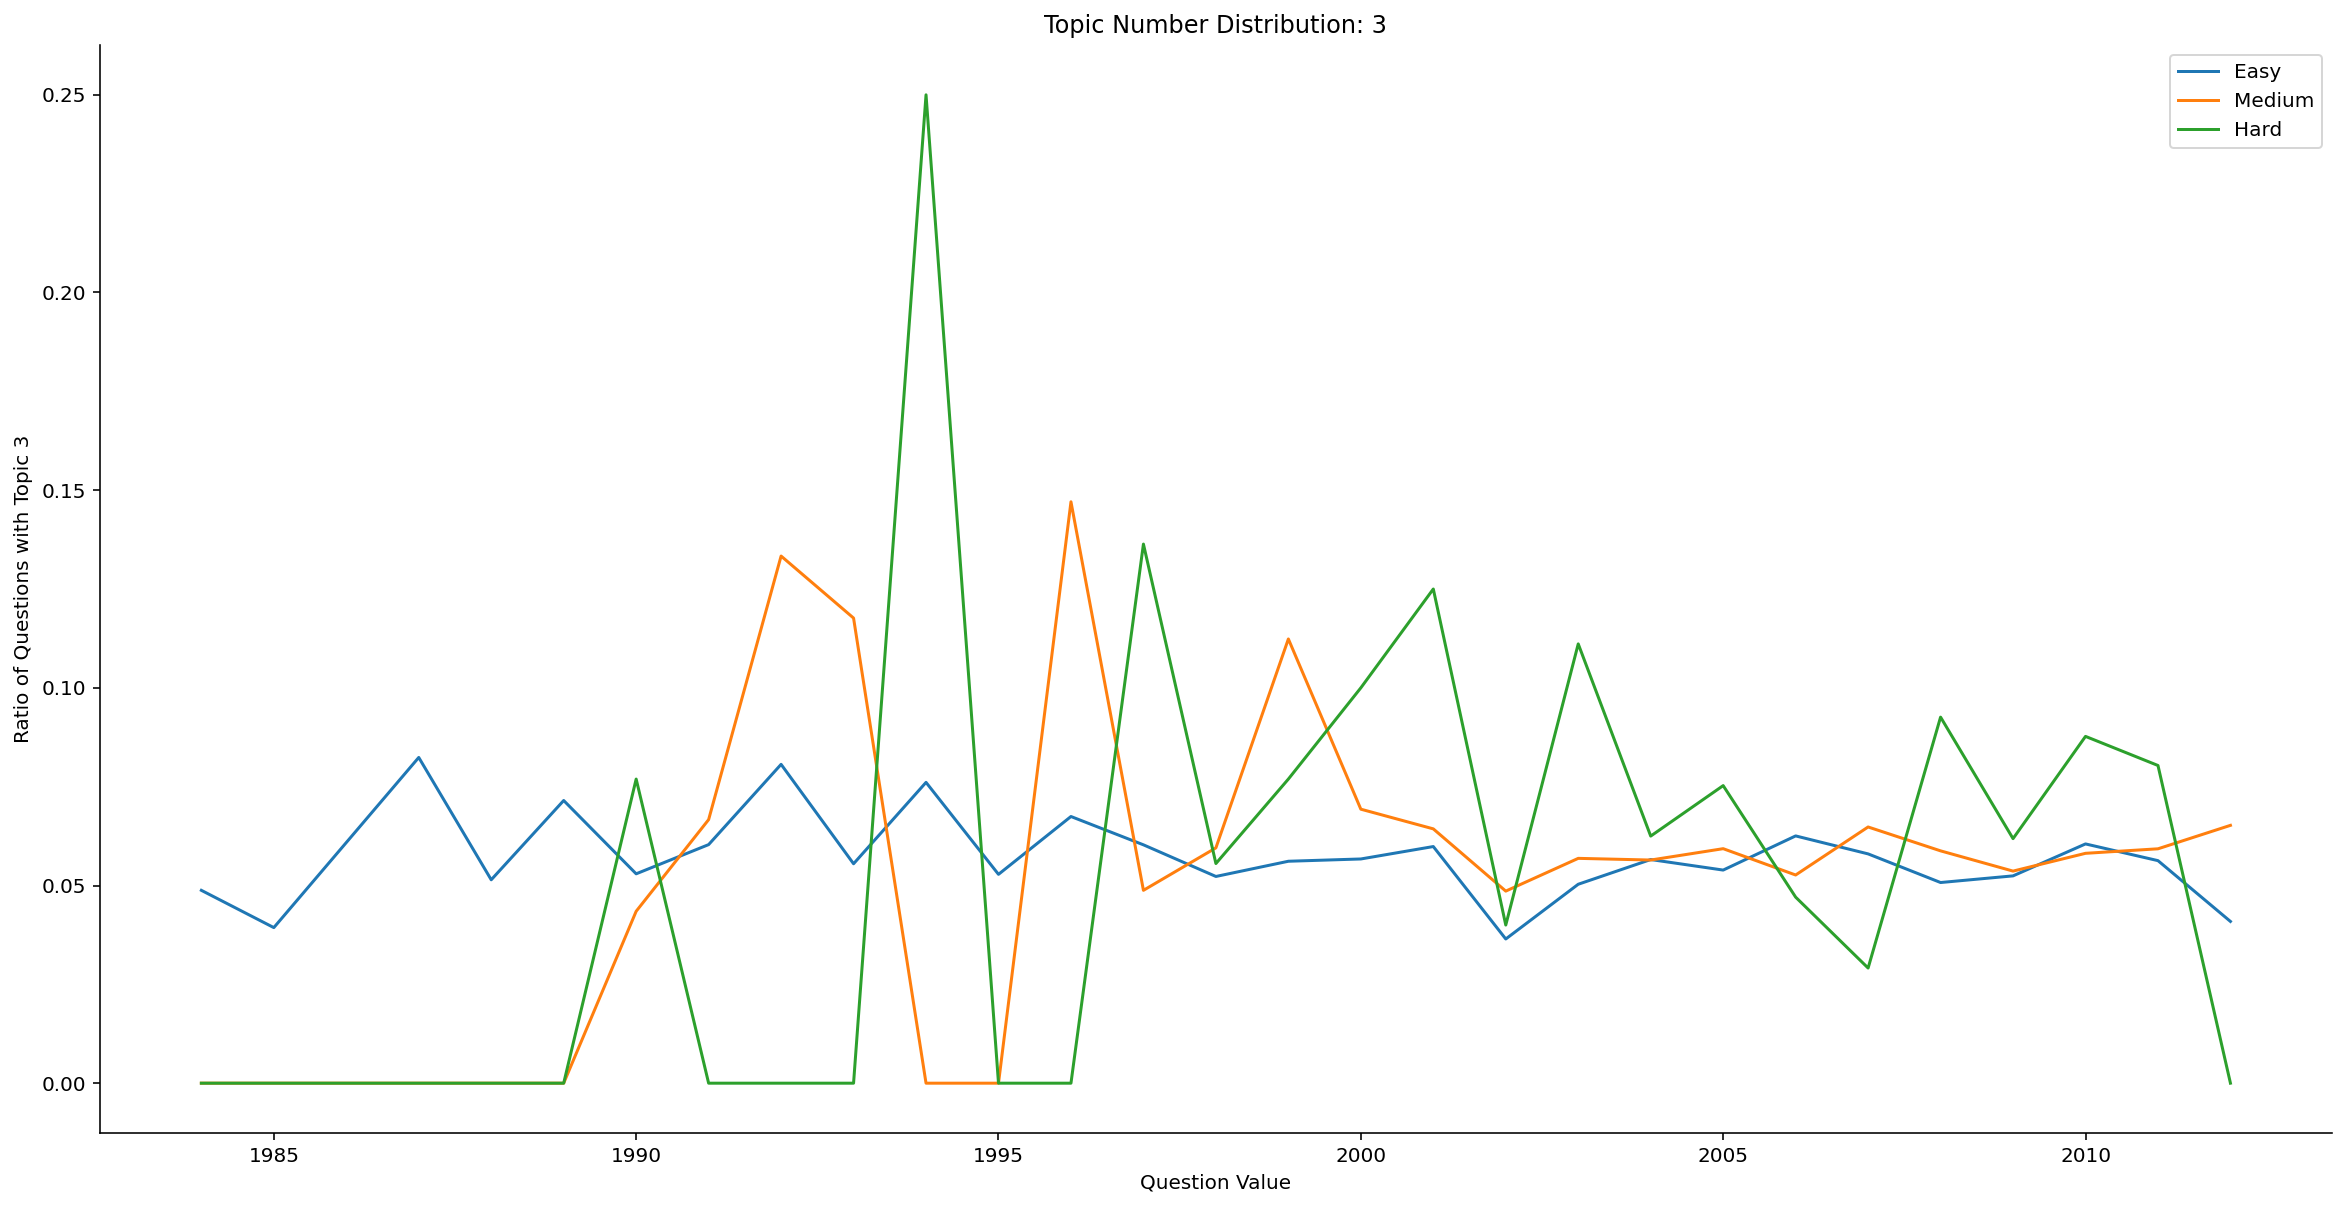

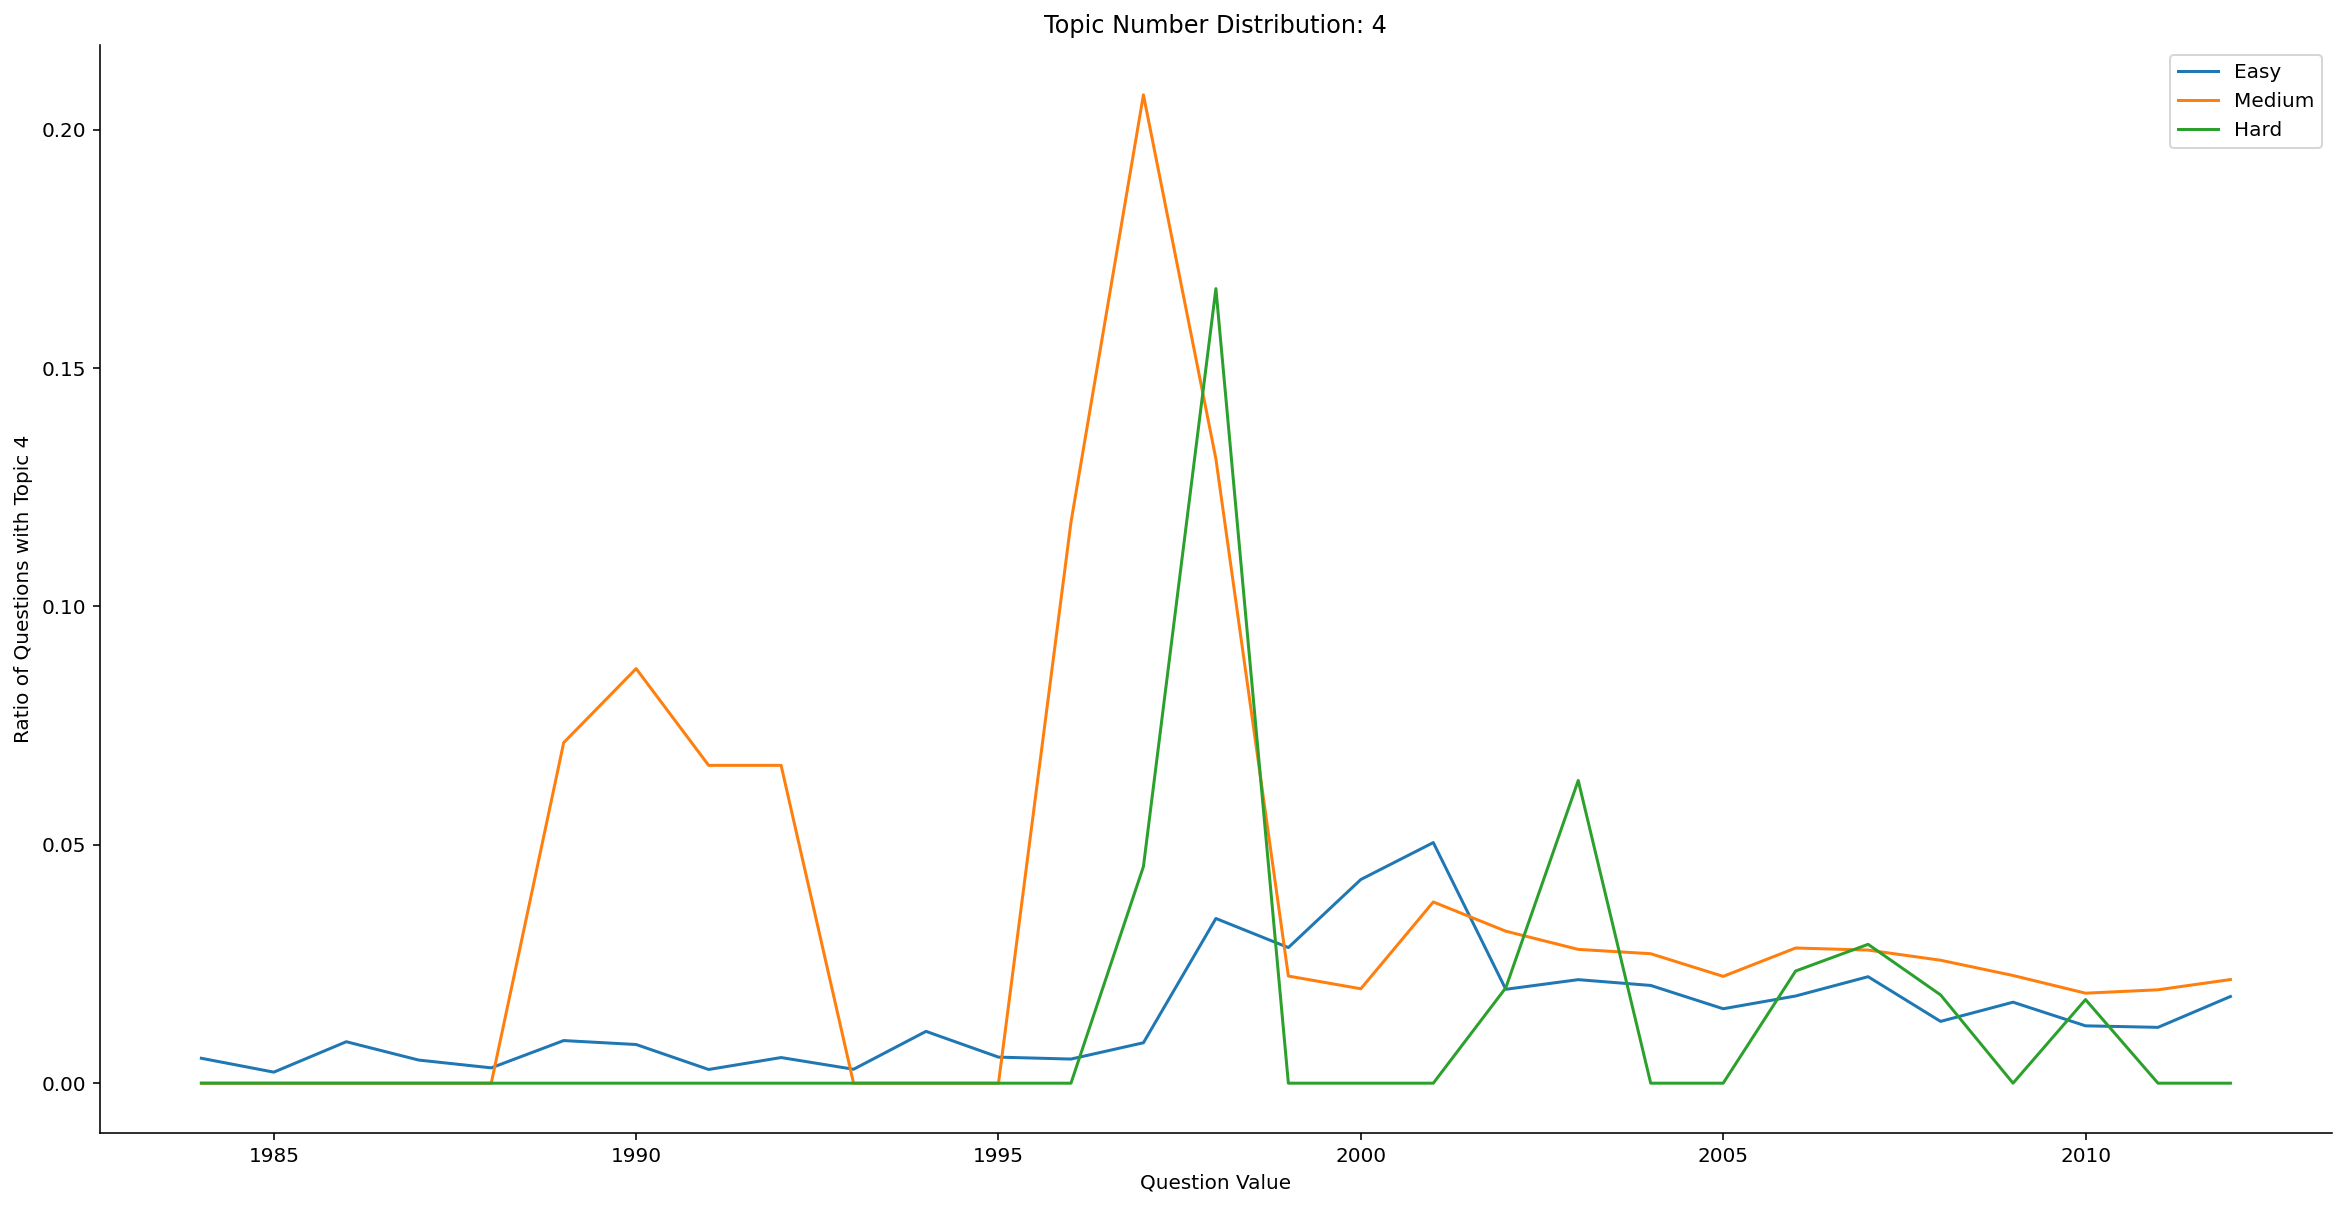

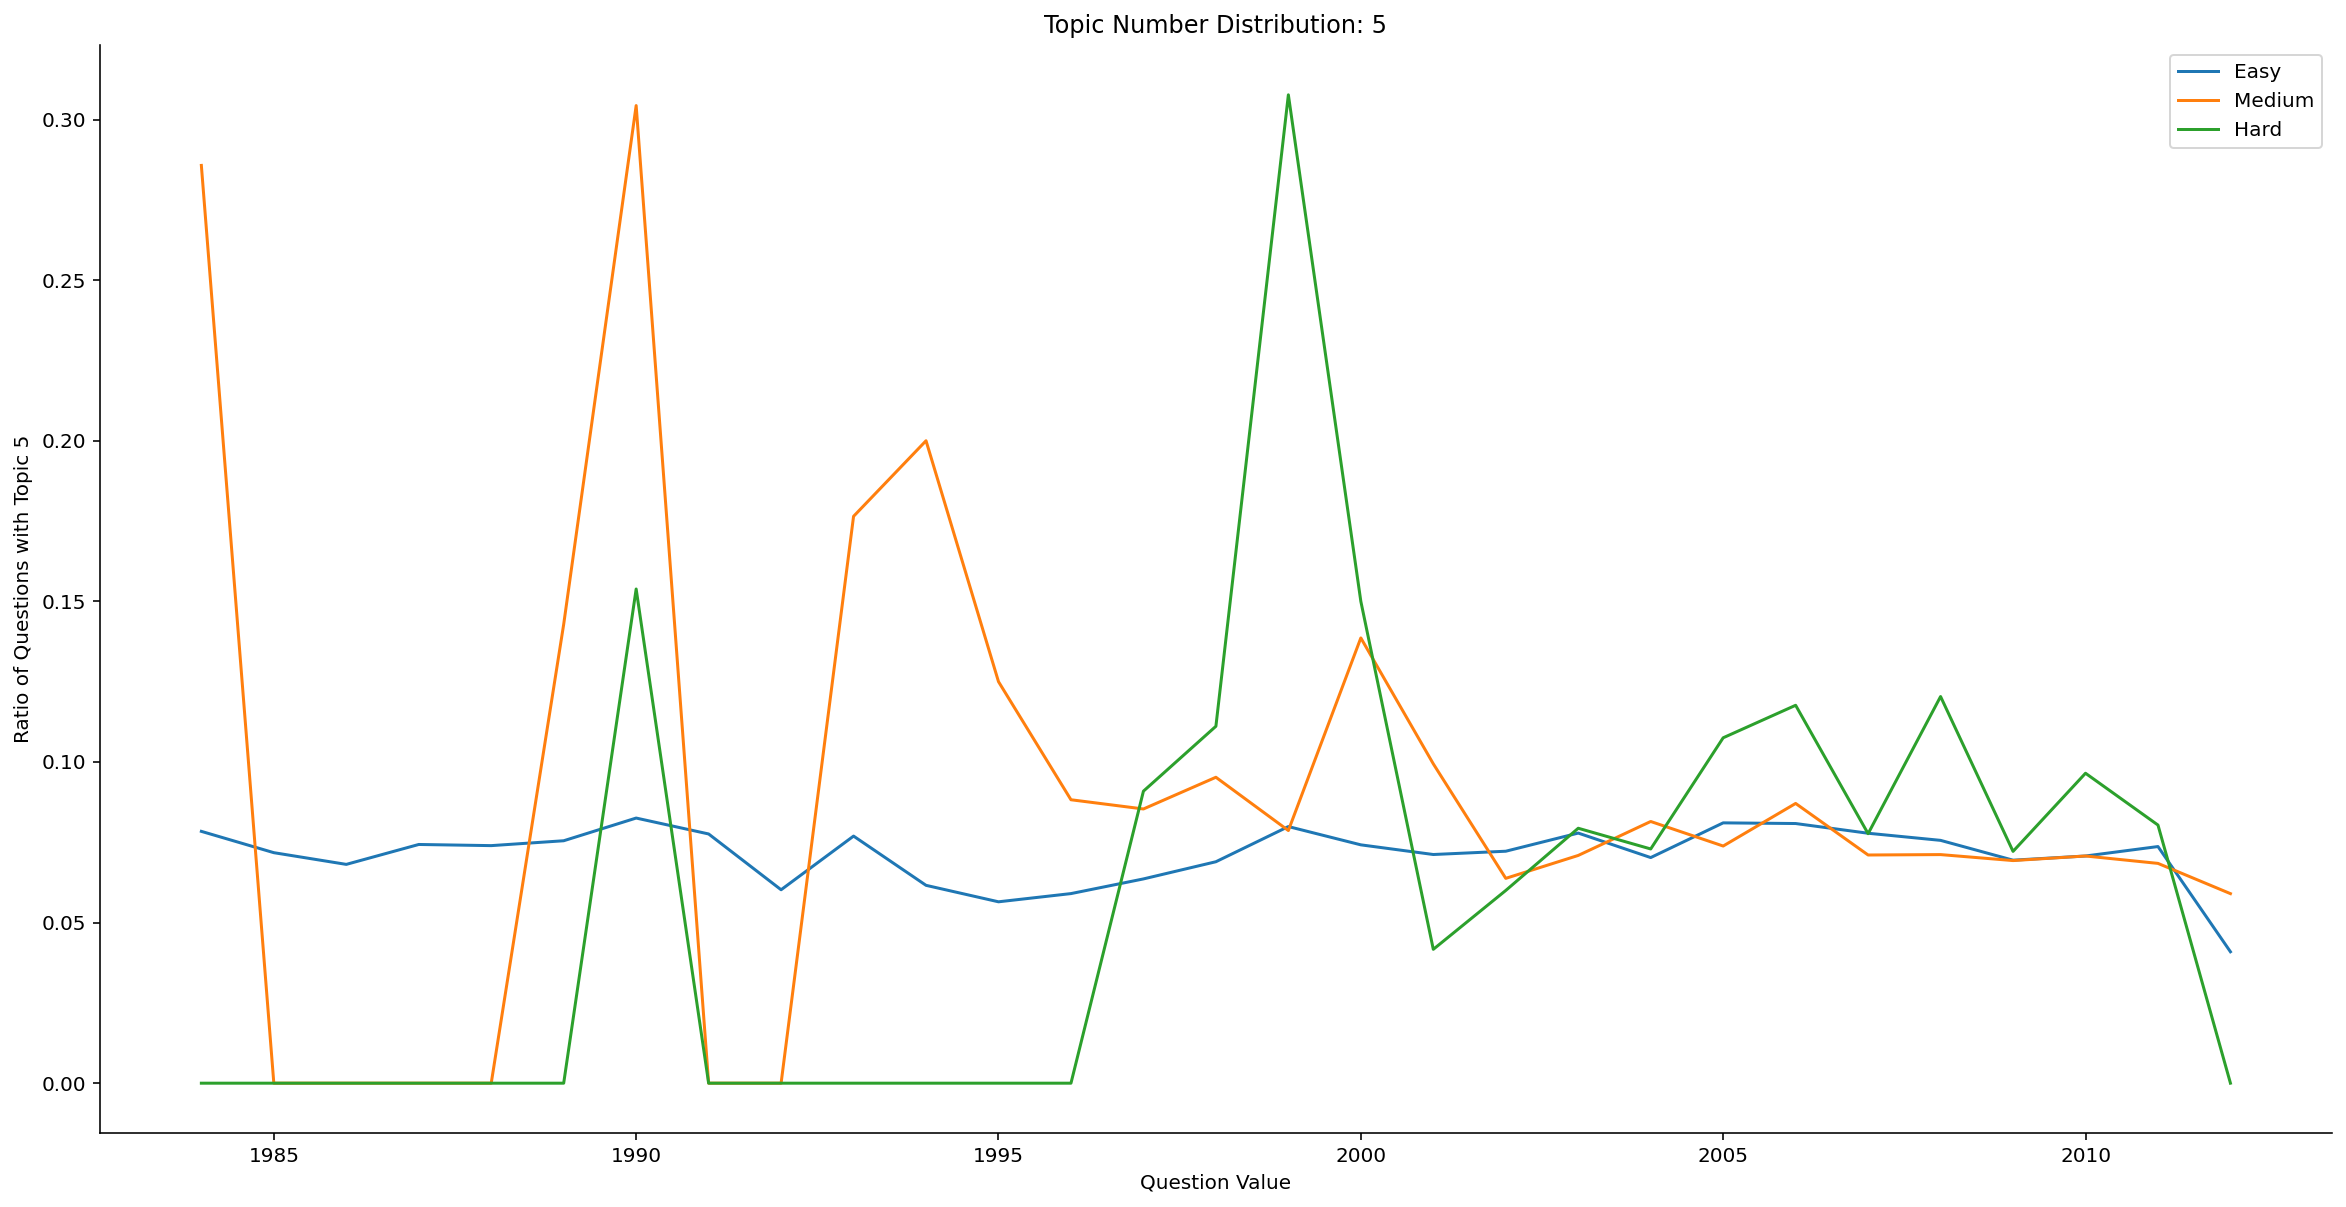

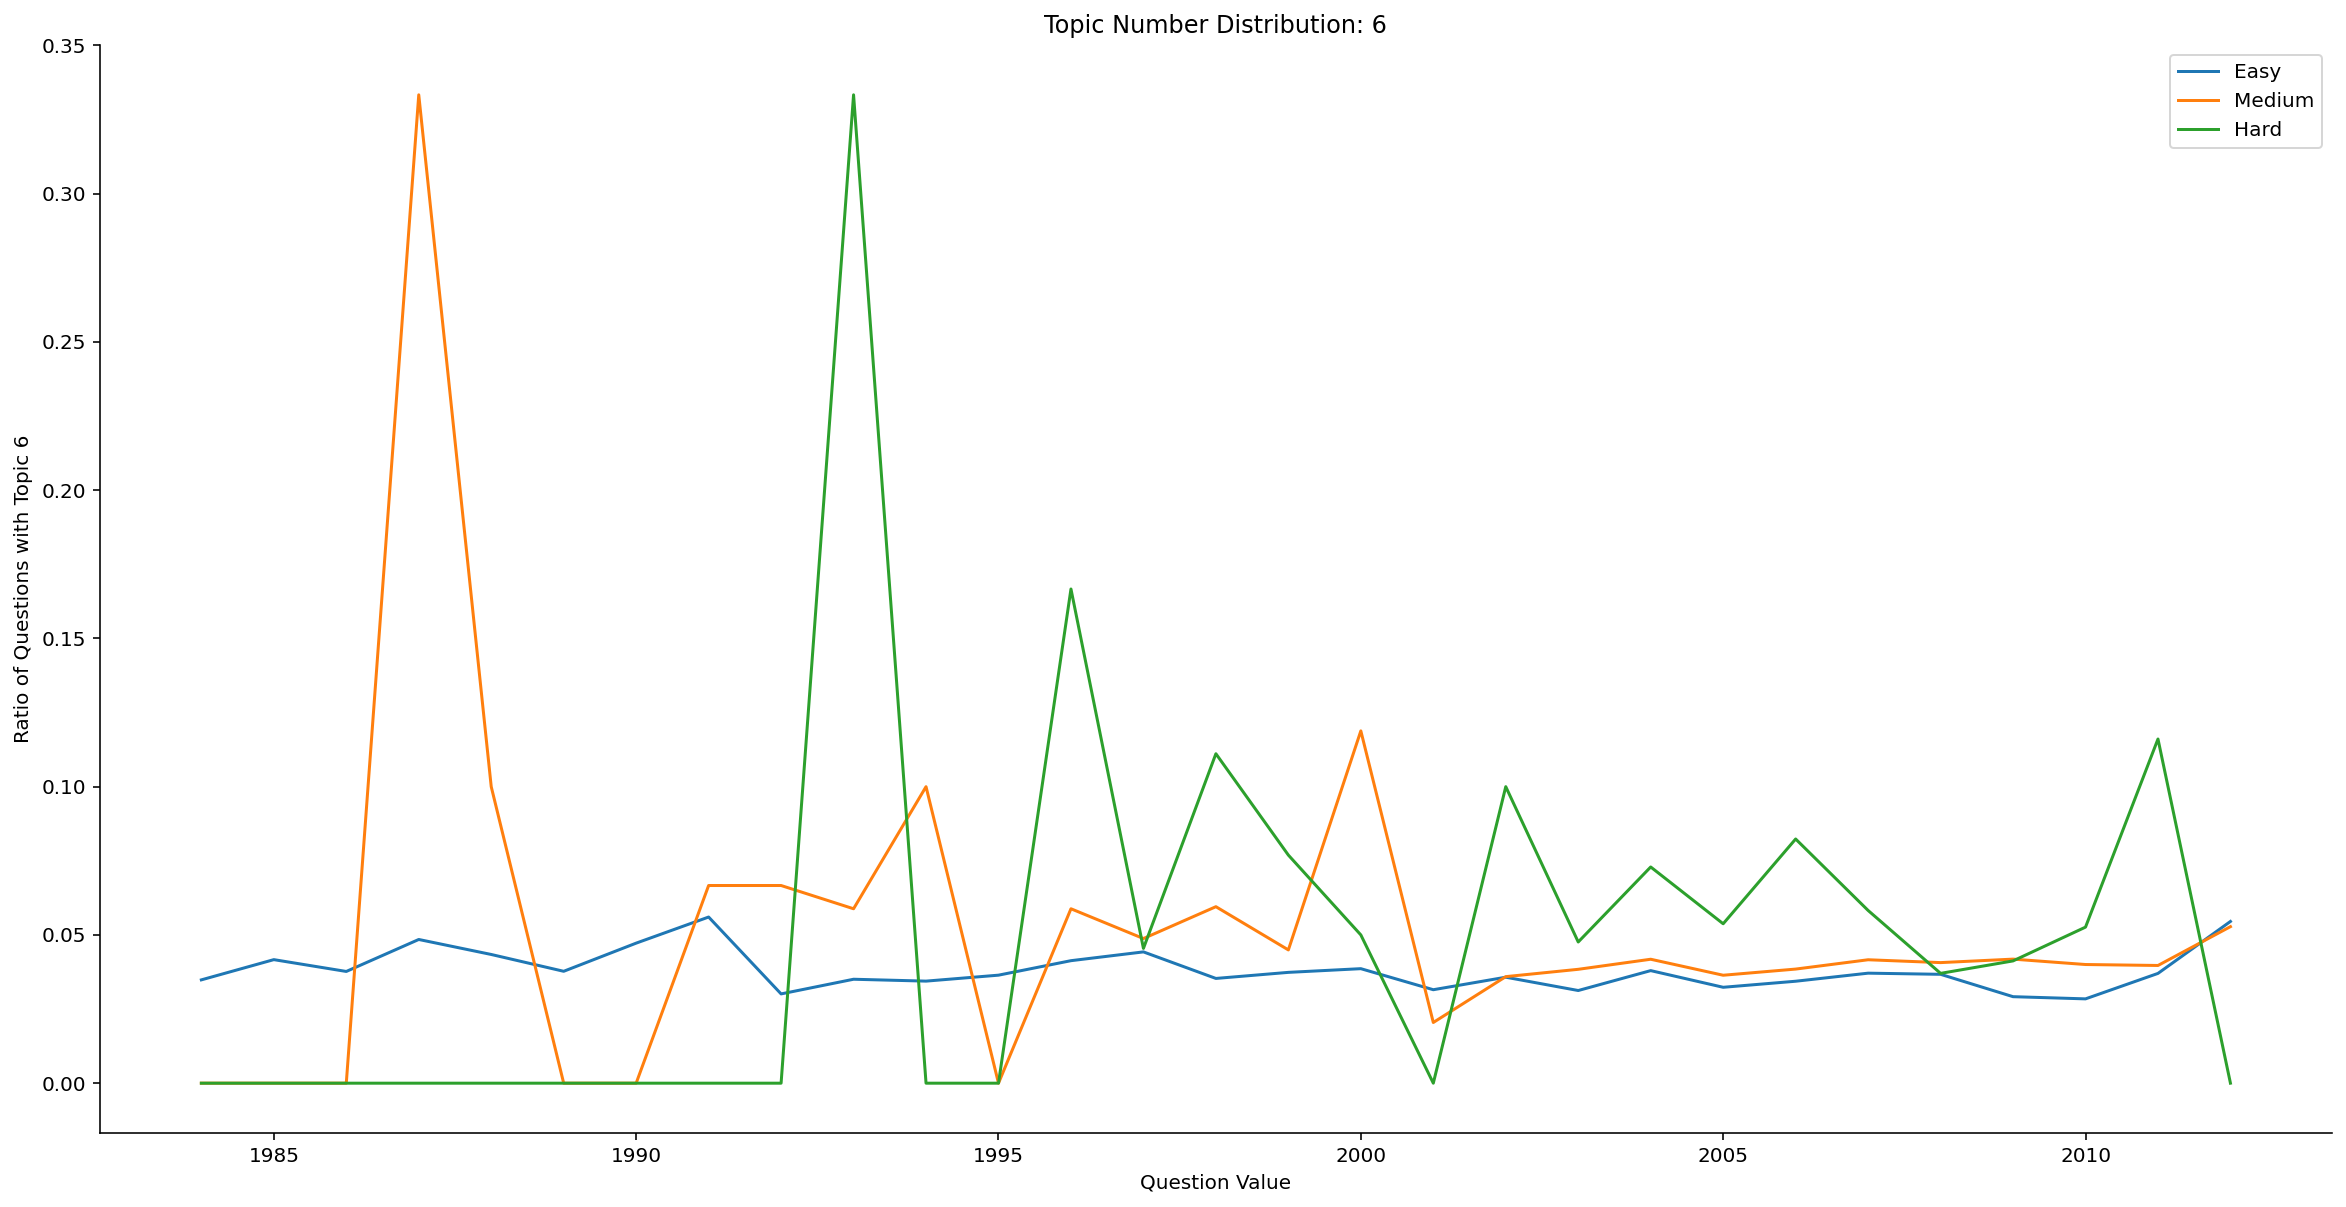

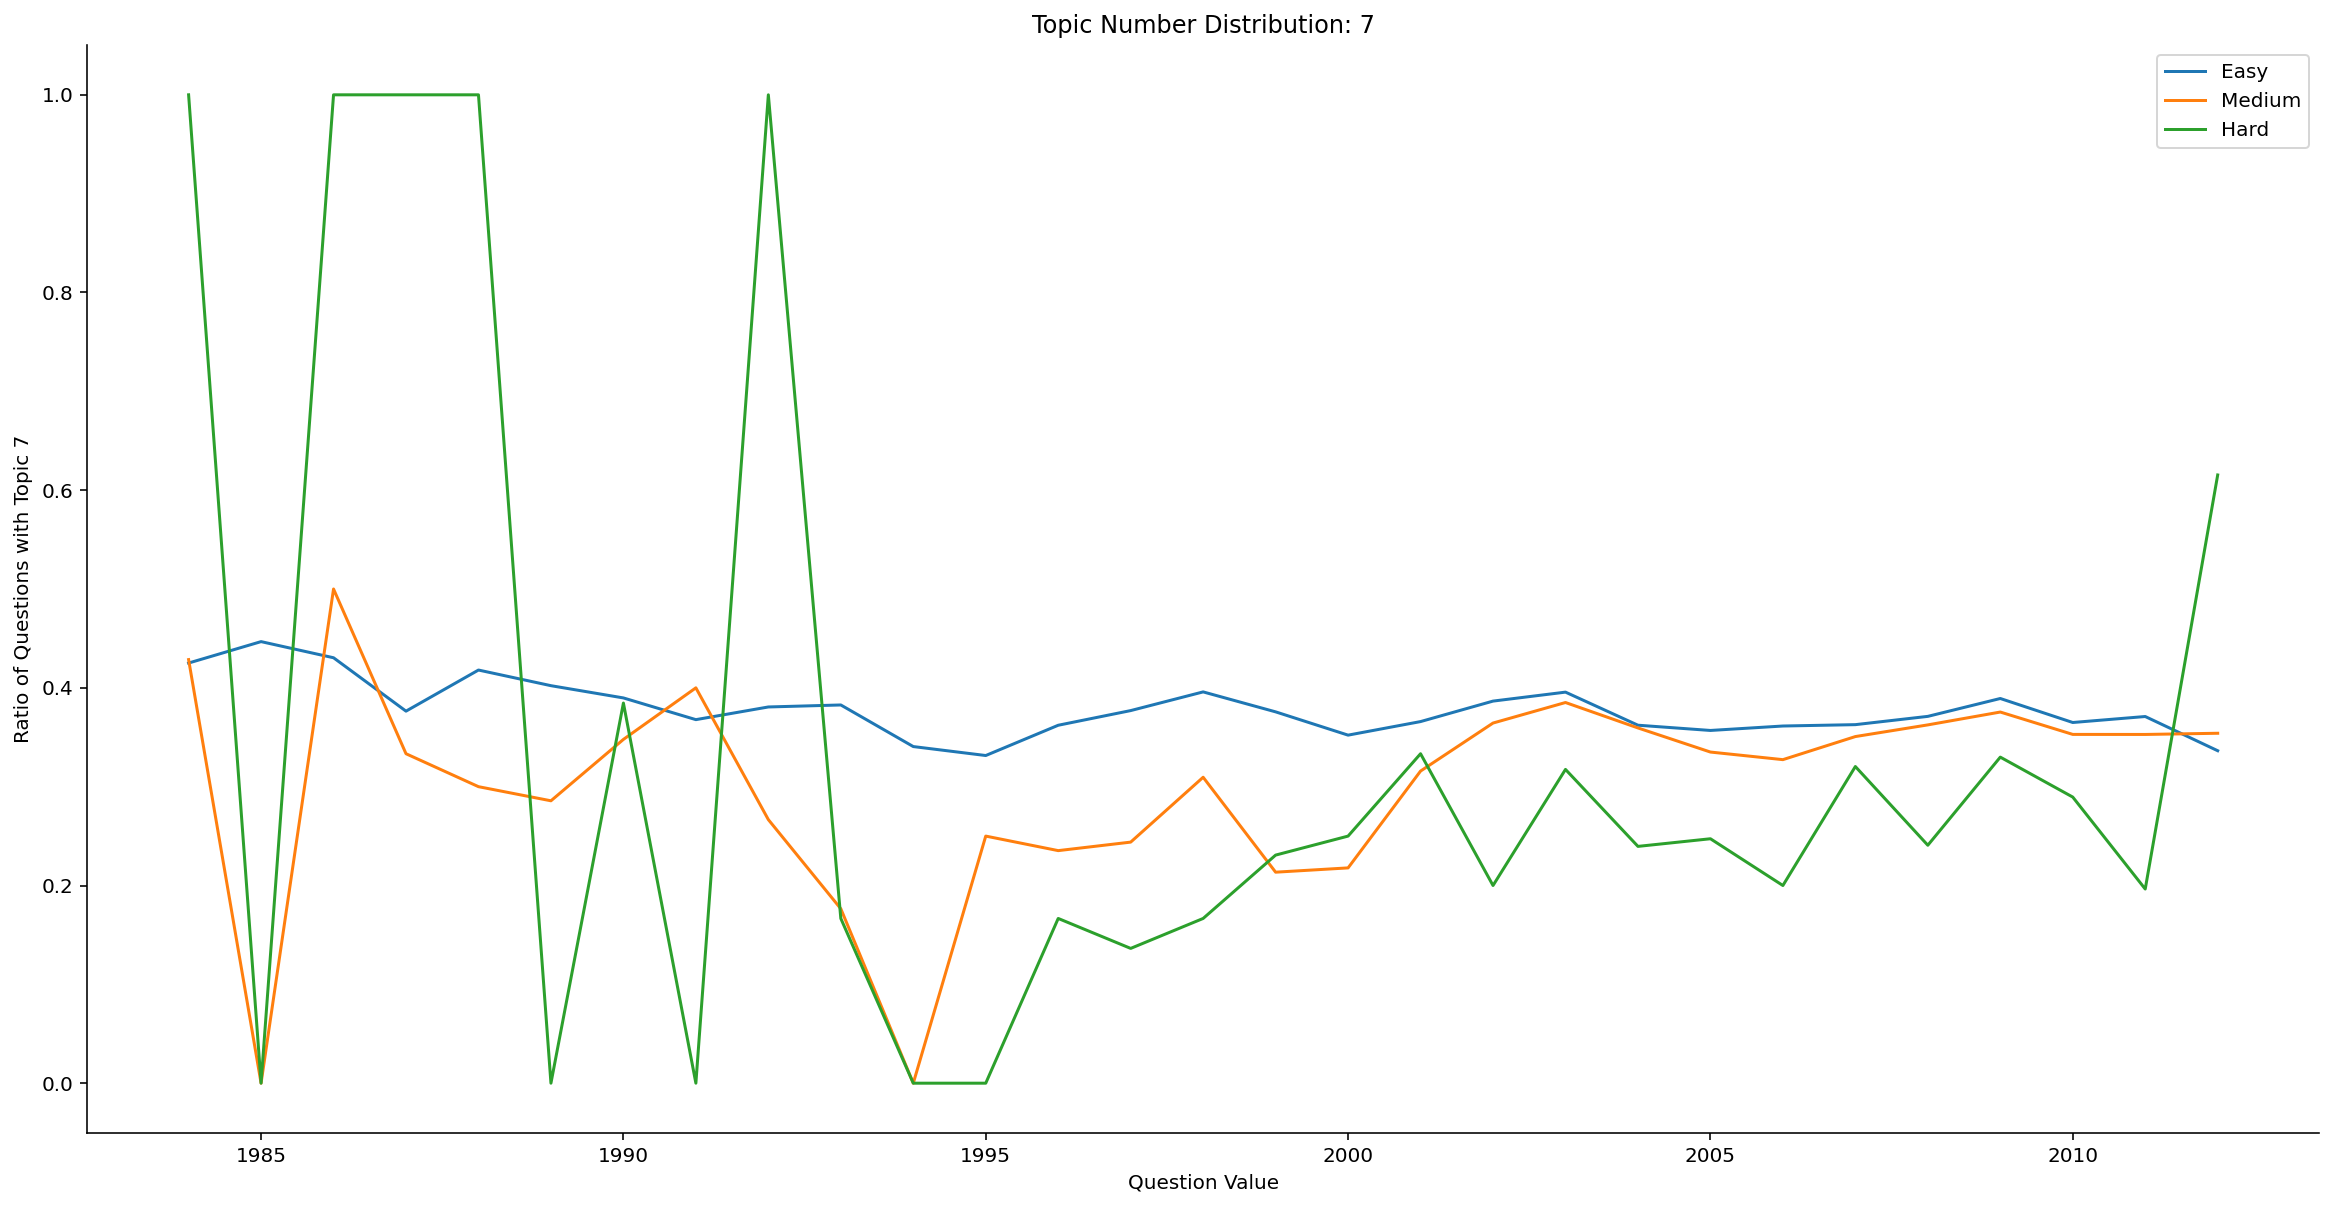

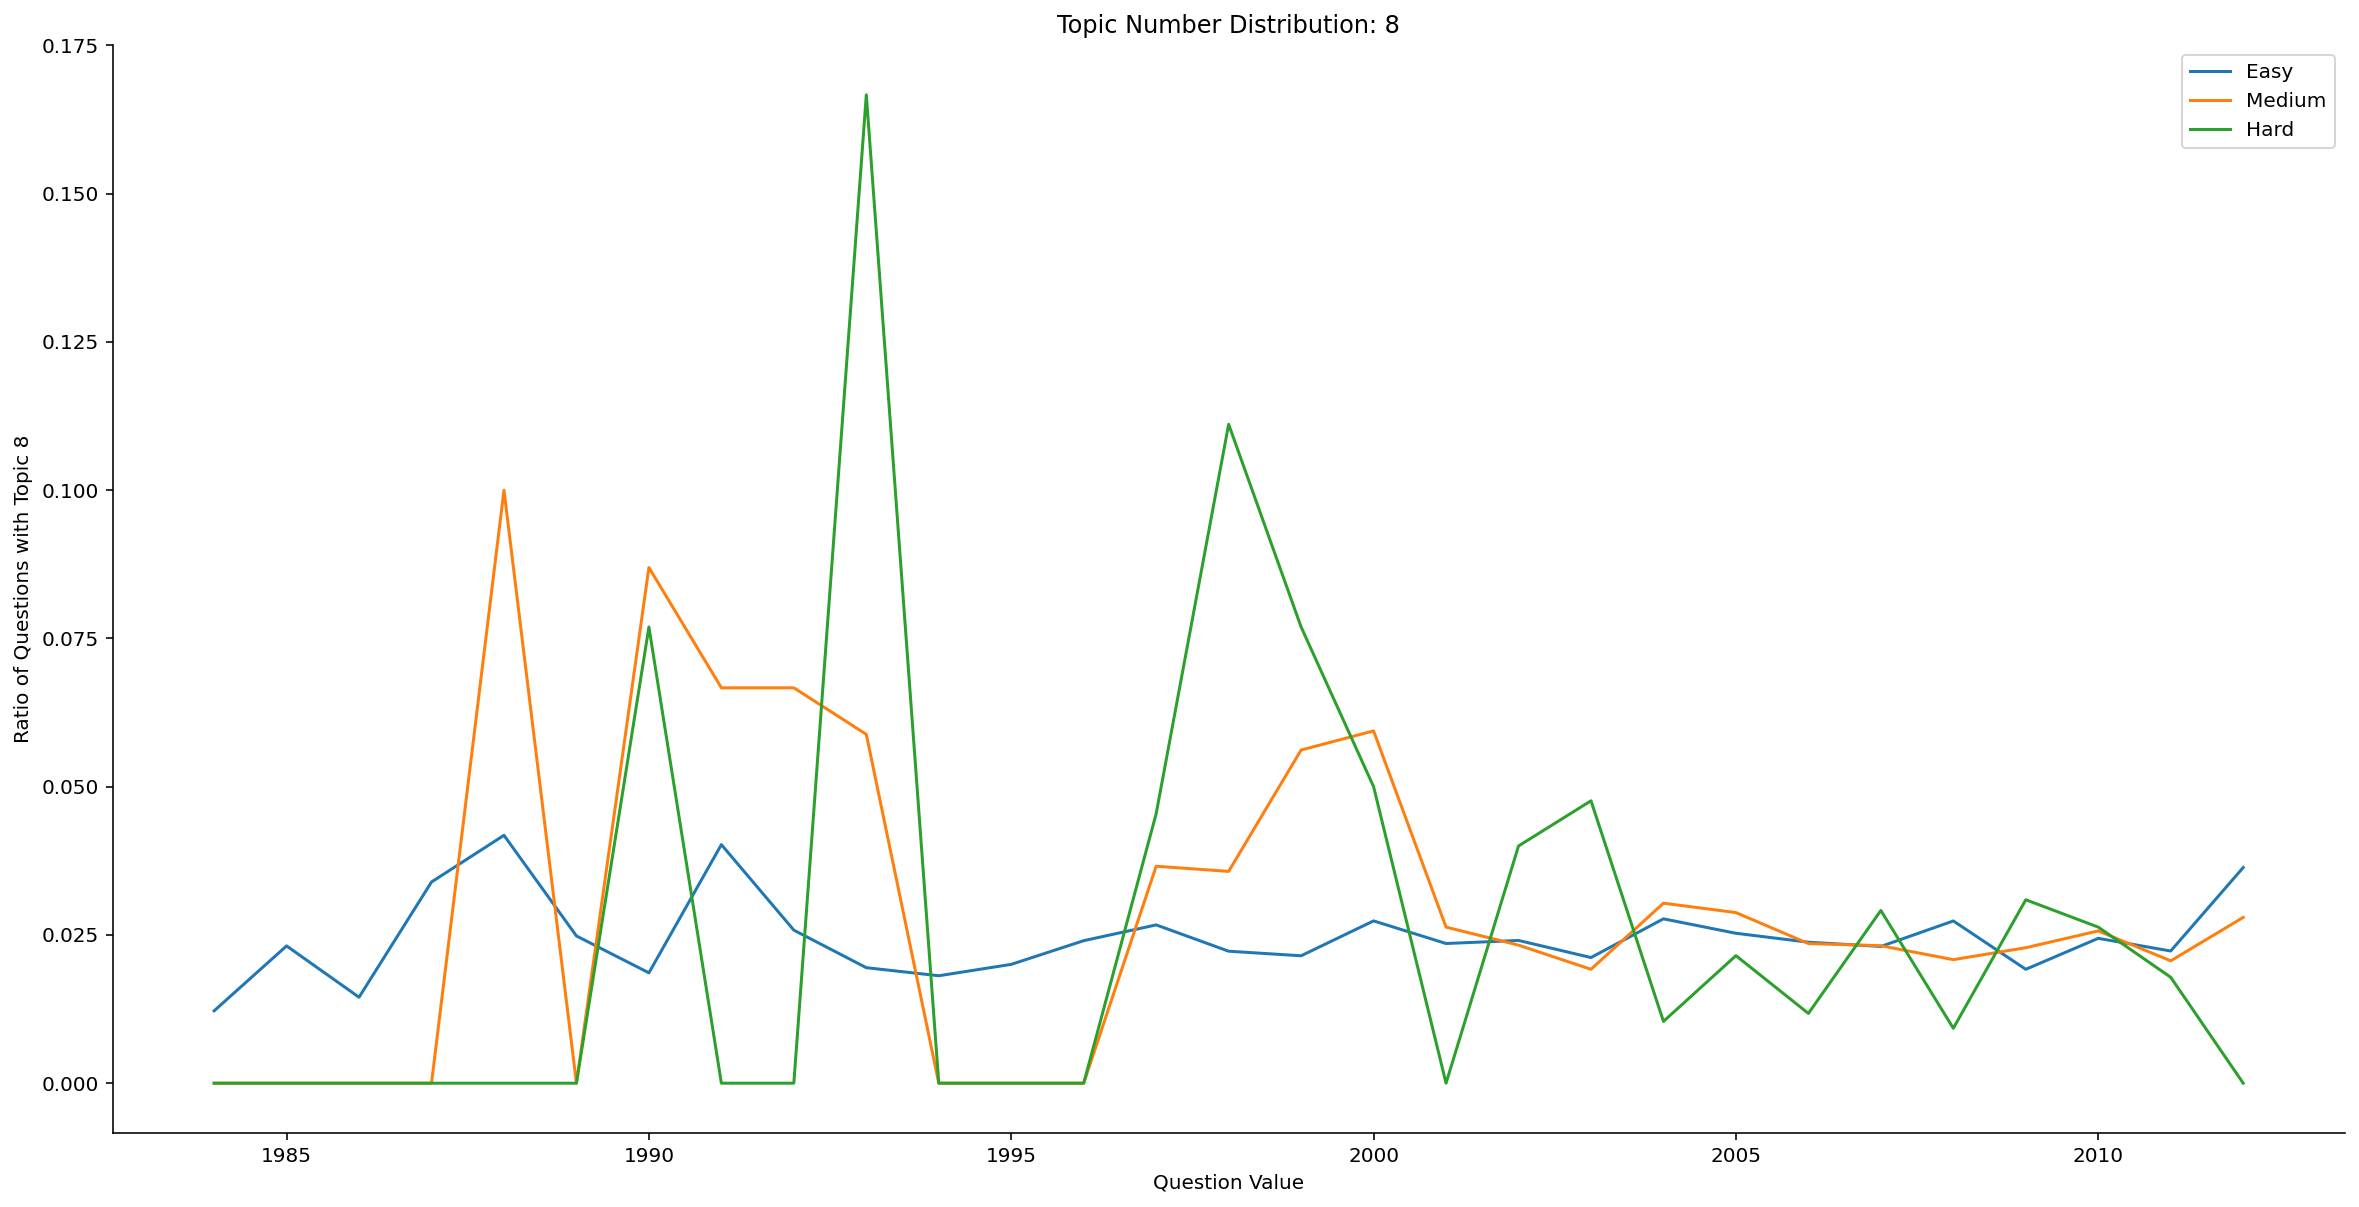

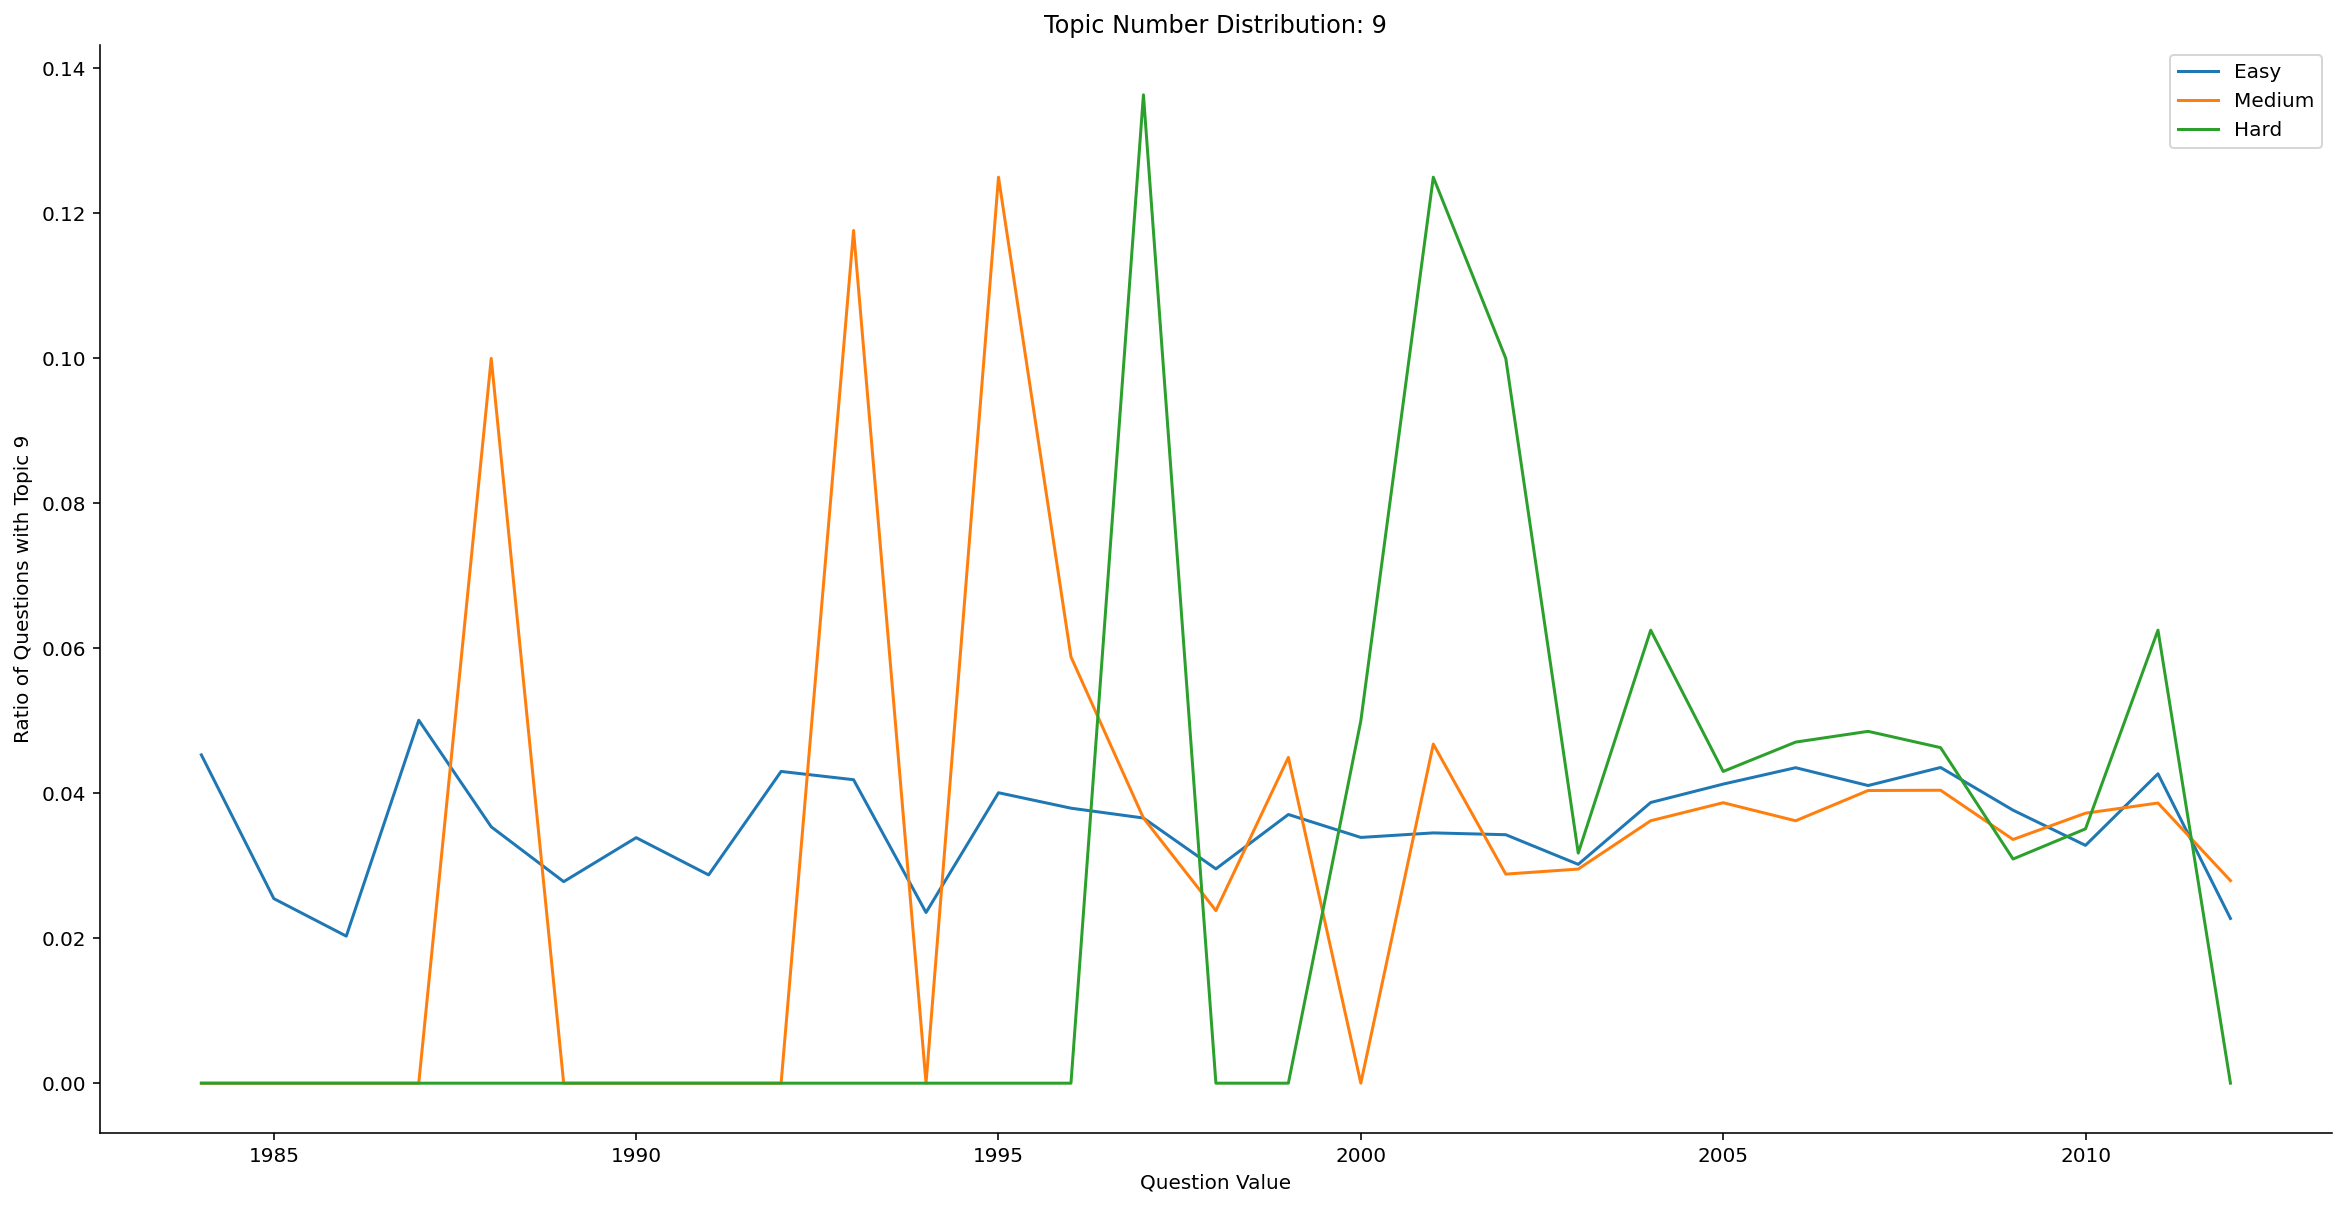

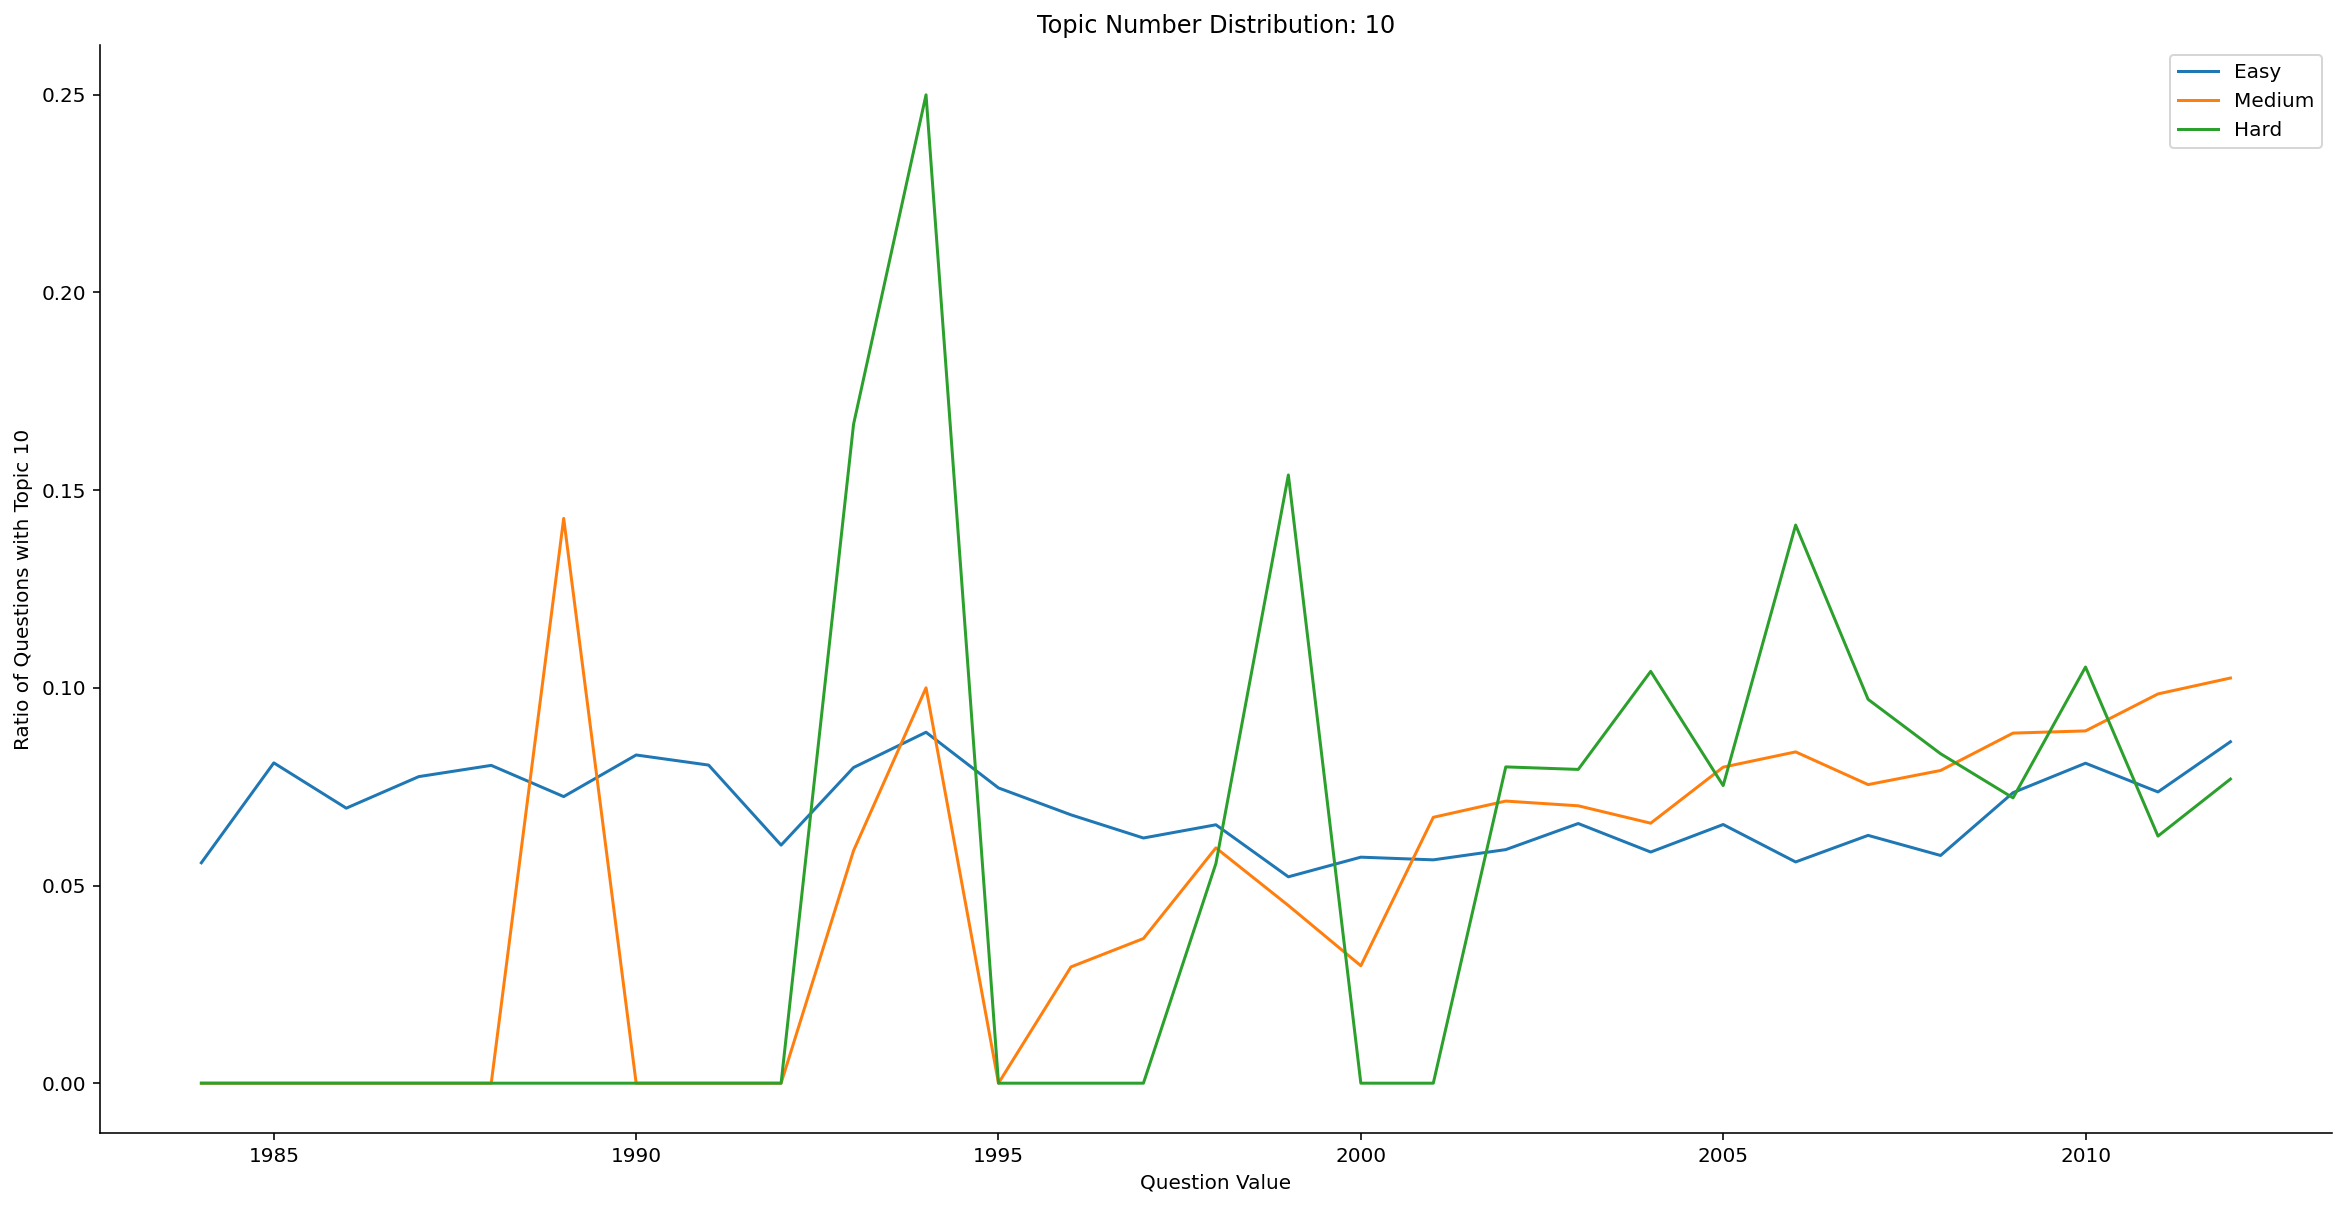

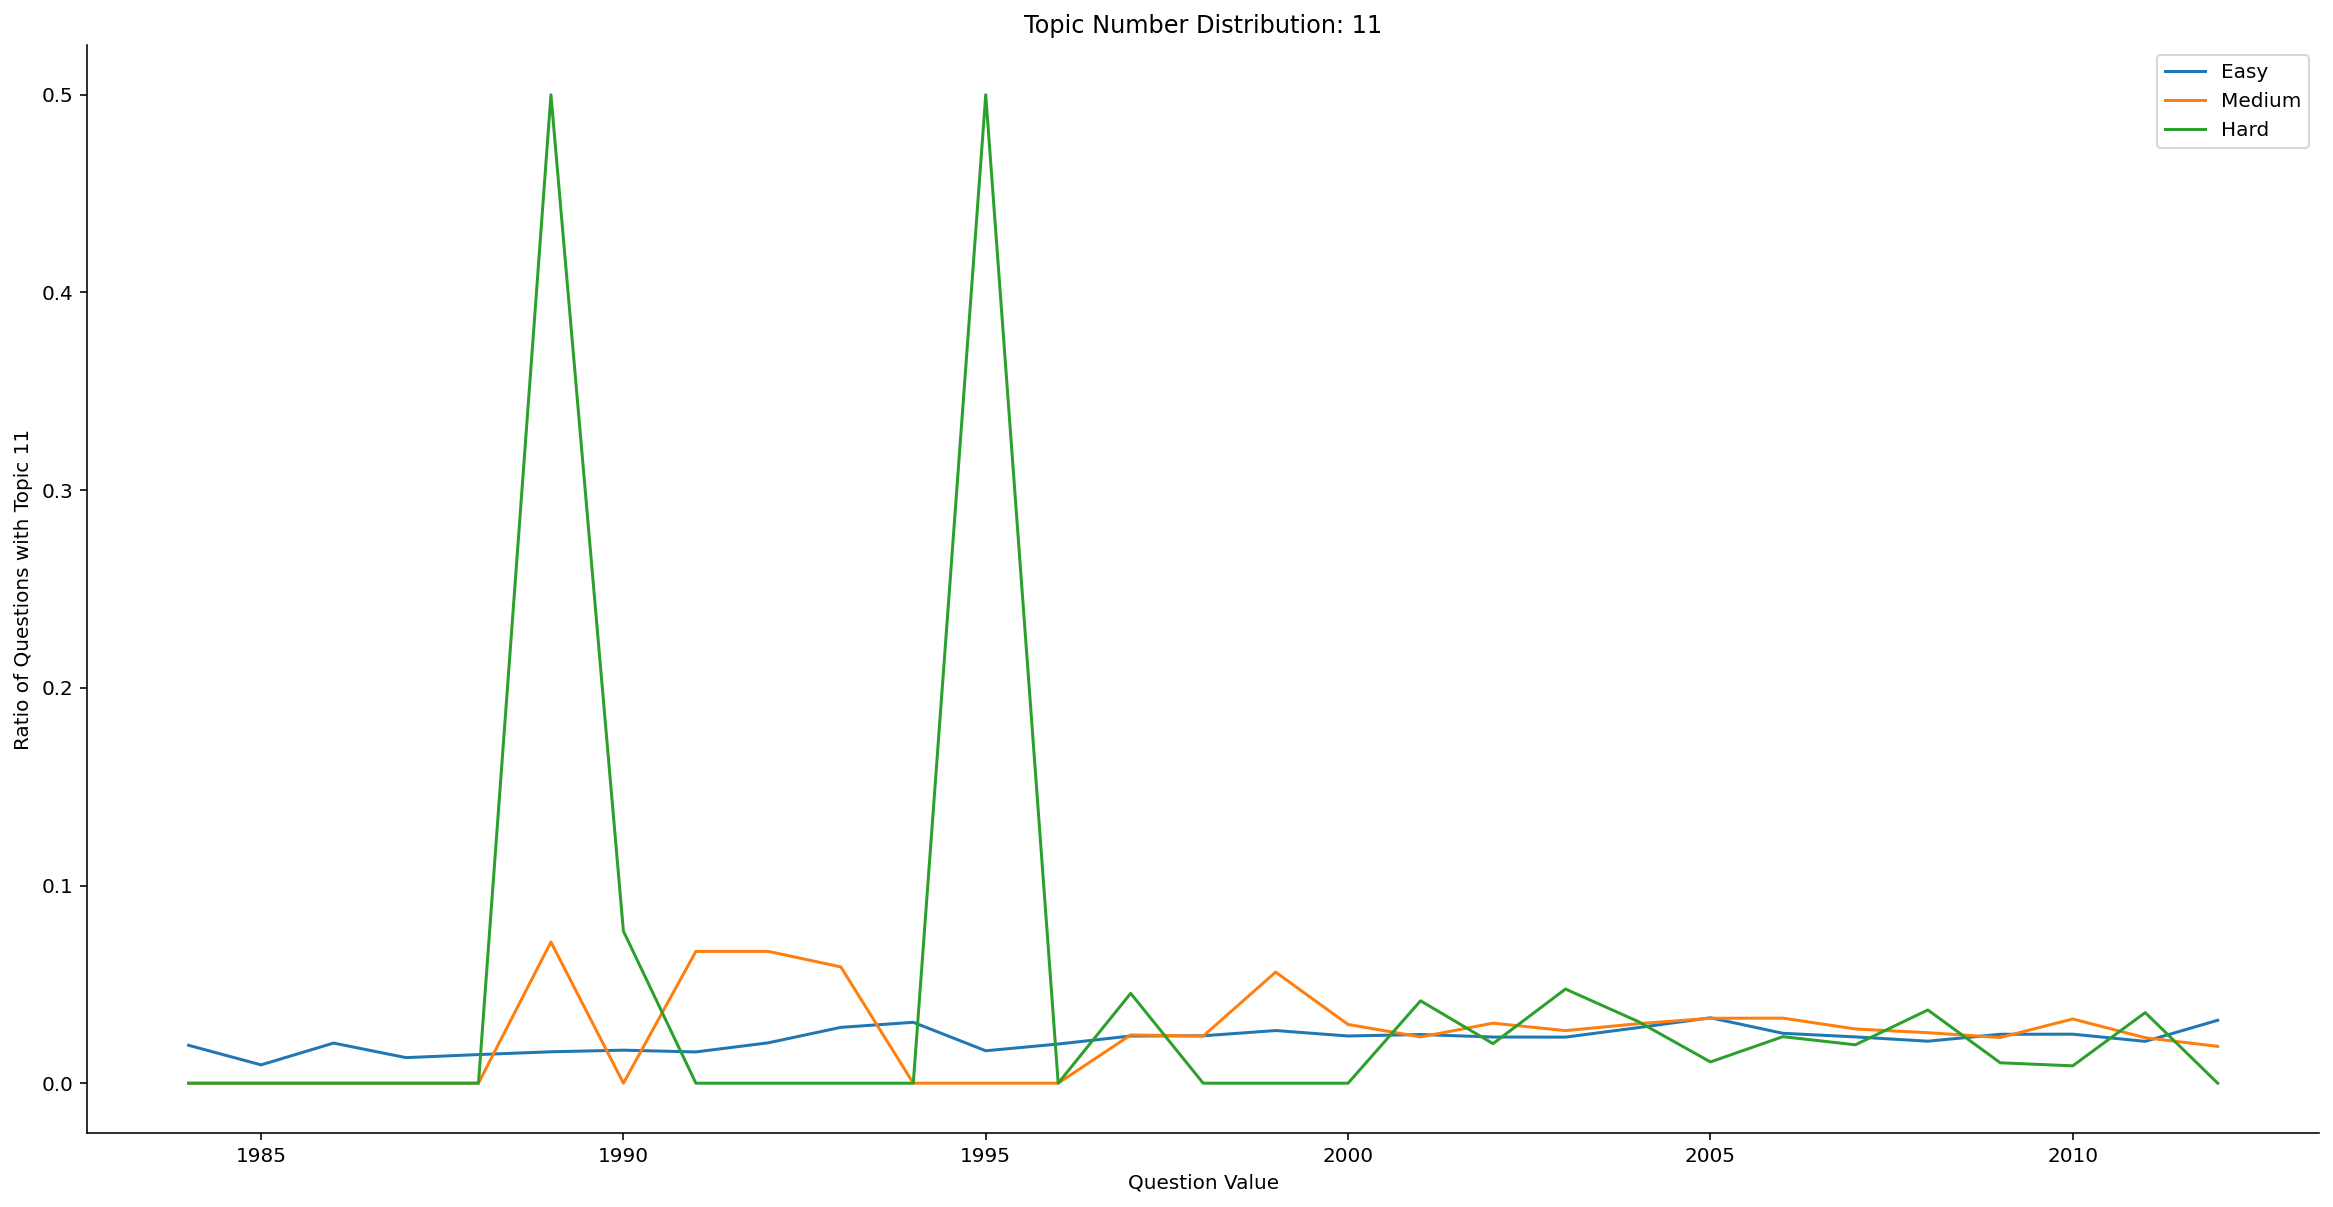

In [103]:
topics_across_time(jeopardy, years, low=[100, 600, 1200], high=[600, 1200, 3001])

The graphs above show the distribution of the ratio of questions that include that particular topic throughout time. Each line in every time series plot represents the values of the questions. As we can see as a whole, many of these topics follow a line plot that includes a sharp rise at a certain moment of time and then goes down. Because of this, many topics were introduced only at a certain period of time but then were discontinued. For example, questions with topic number 11 were used as hard questions in the 1980's and 1990's but then were sharply discontinued.

There are some interesting notes to show in the world of jeopardy. For example, for contestants who are aiming to be on the show, try to study questions that relate to topic number 7 if you want to get the semi hard questions (those with a value of 400) if you are getting on the show today (post 2010). Questions relating to topic 1 are increasing in prevalence today for hard questions. Topic 0 was used for those questions valued at 2000 dollars during the late 1980's and mid 1990s and now it has stabilized to be included for all types of questions: easy, medium, and hard. In this way, we can look for each topic, how the ratio of the questions for that specific value changed over time and see that for example, topic 11 is not asked that much today as opposed to the late 1980's and mid 1990's whereas questions relating to topic 10 were and are asked both in the past and today, and those questions with topic 10 are increasing in prevalence. 

### Split Questions by Year - Double Jeopardy

In [104]:
years = dub_jeopardy['year'].unique()
years.sort()
values = dub_jeopardy['Value_nums'].unique()
values.sort()

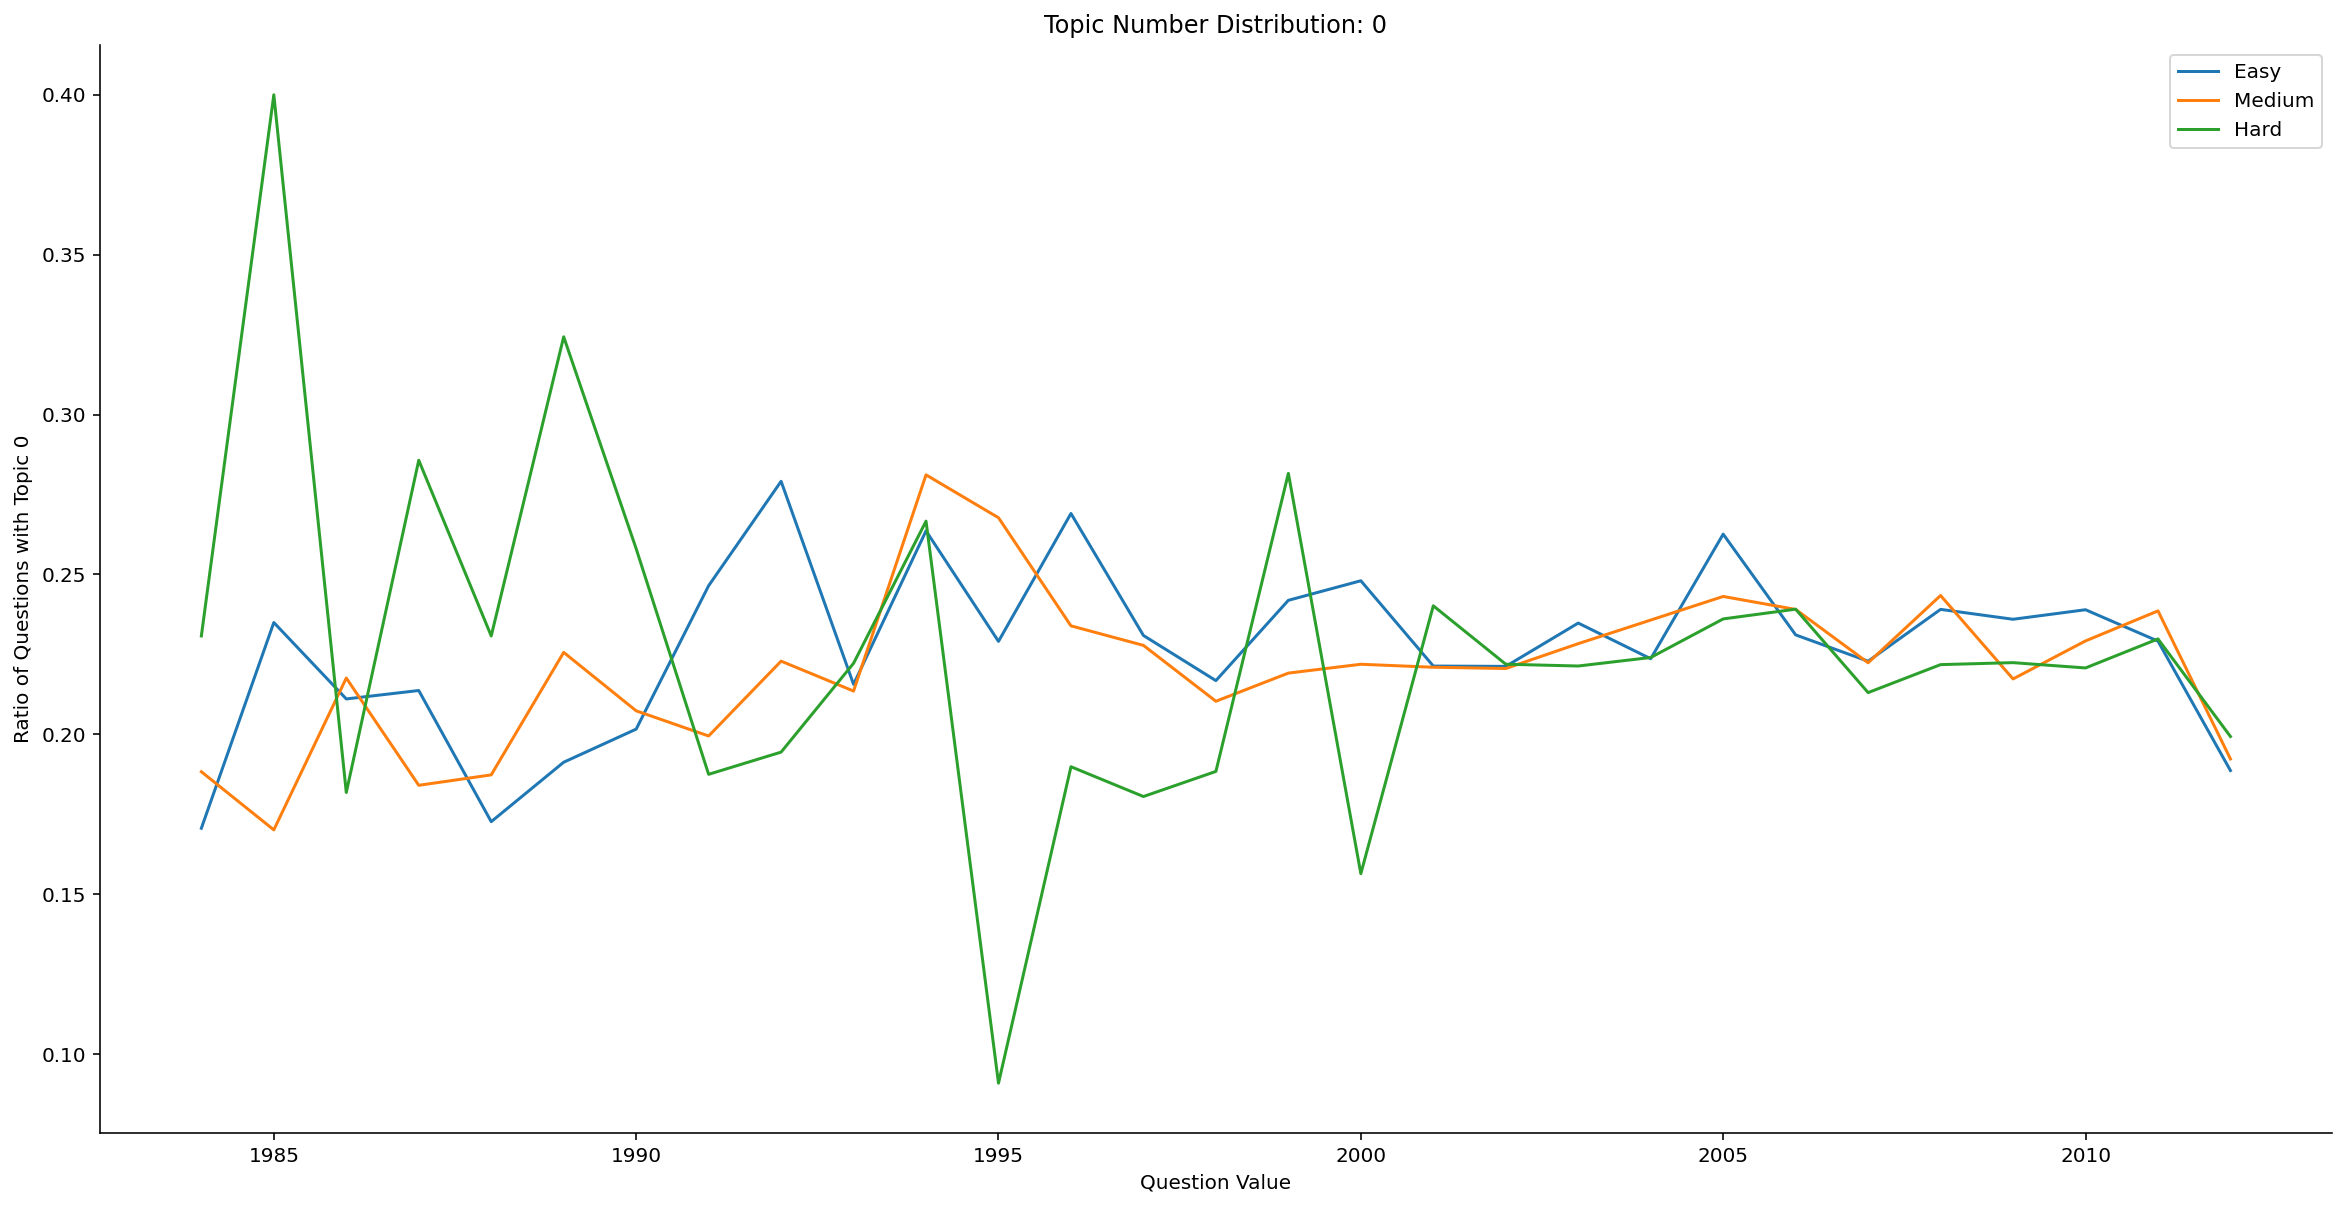

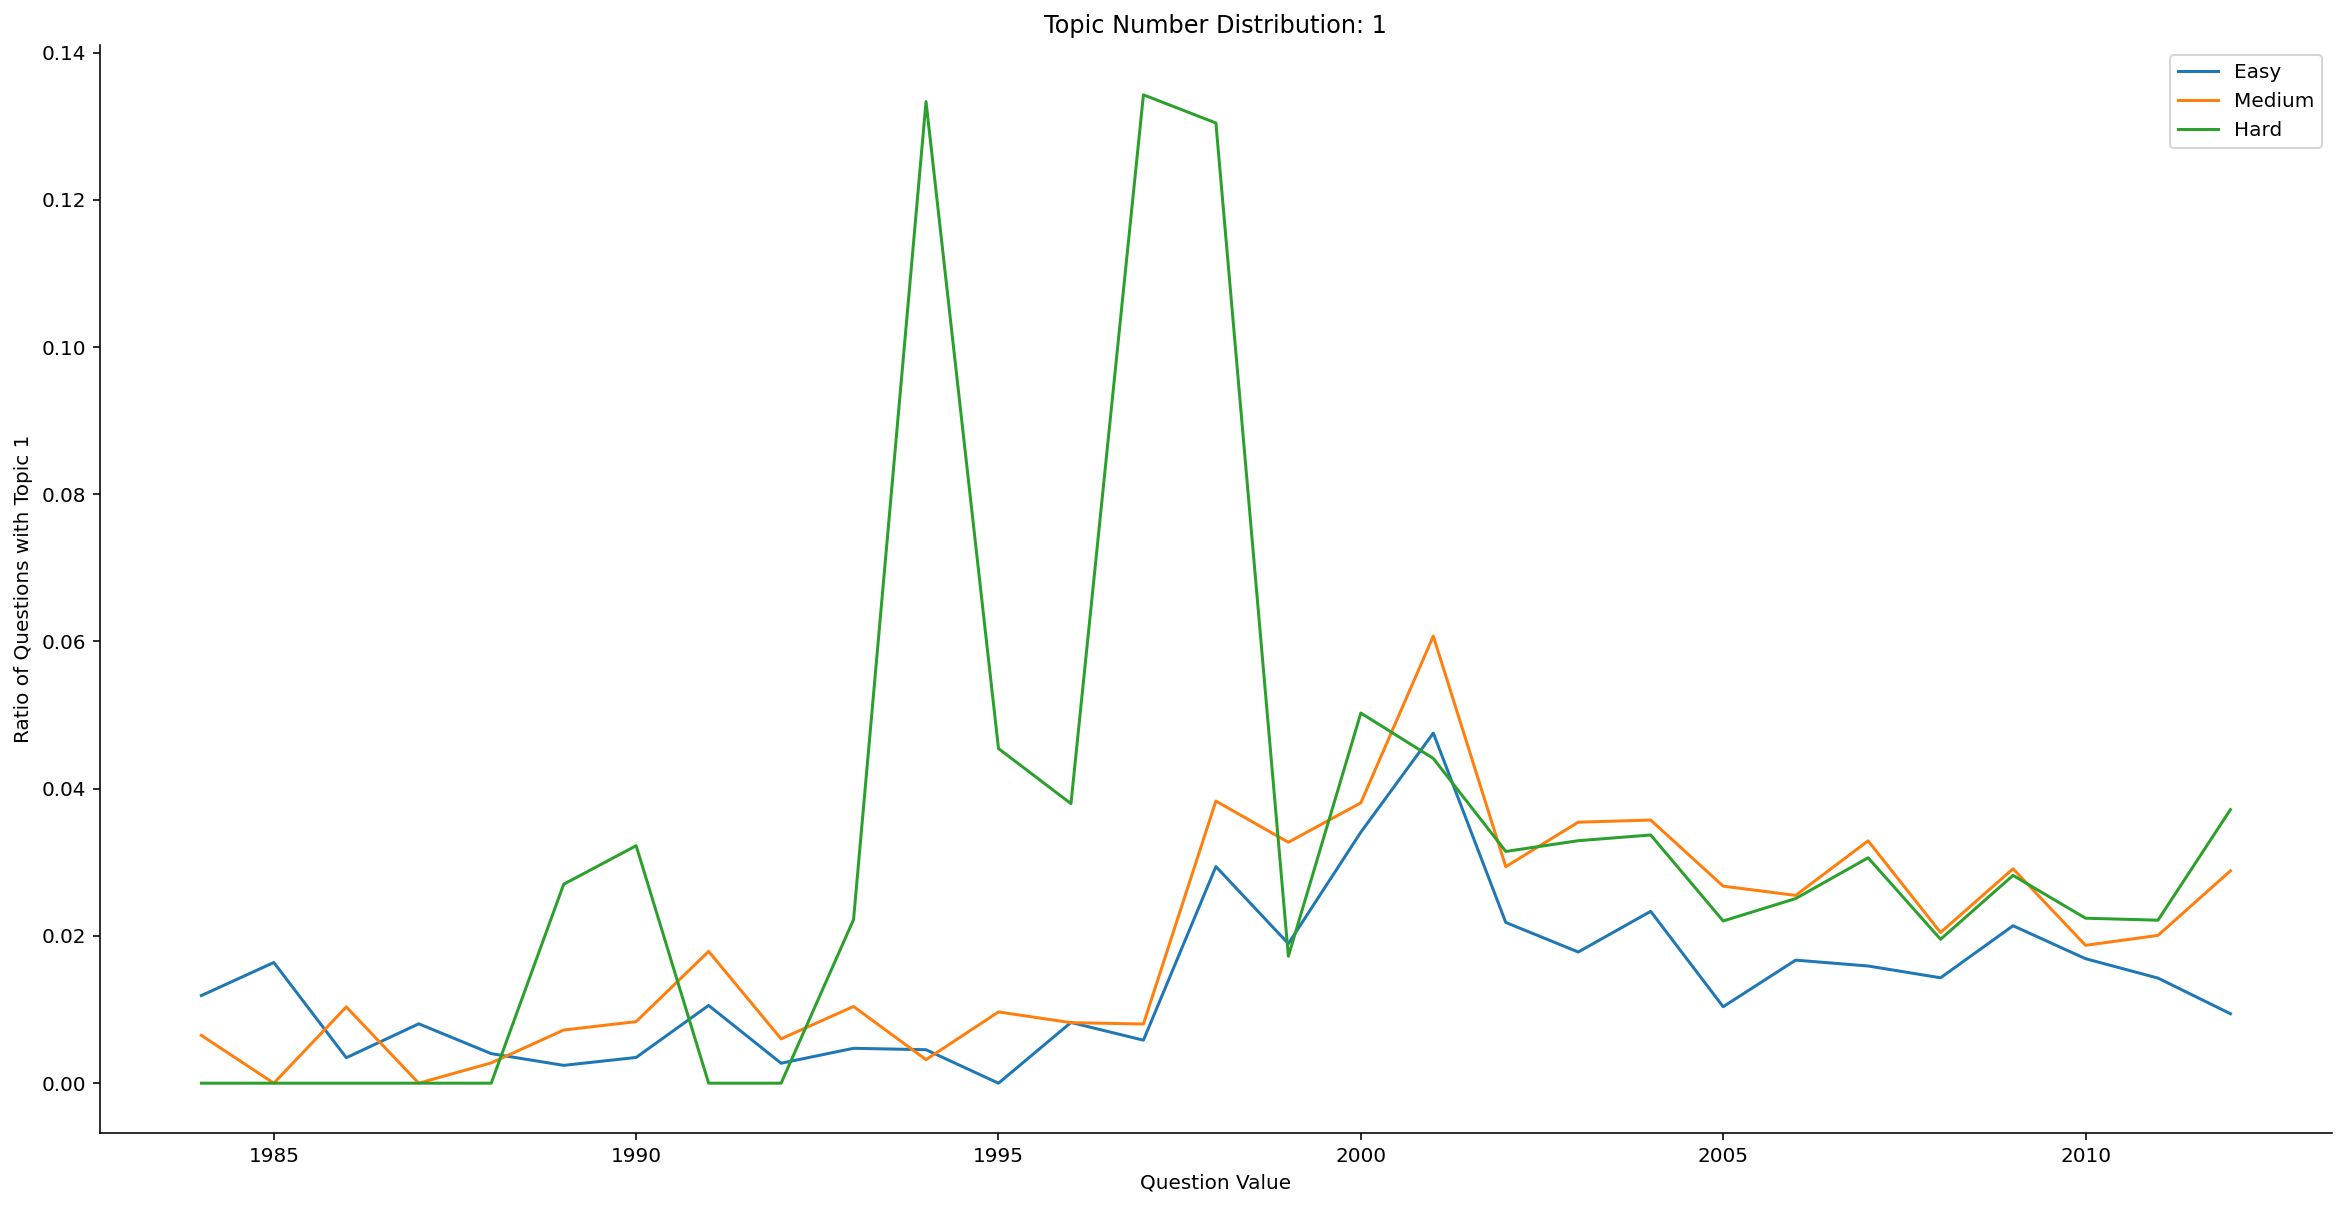

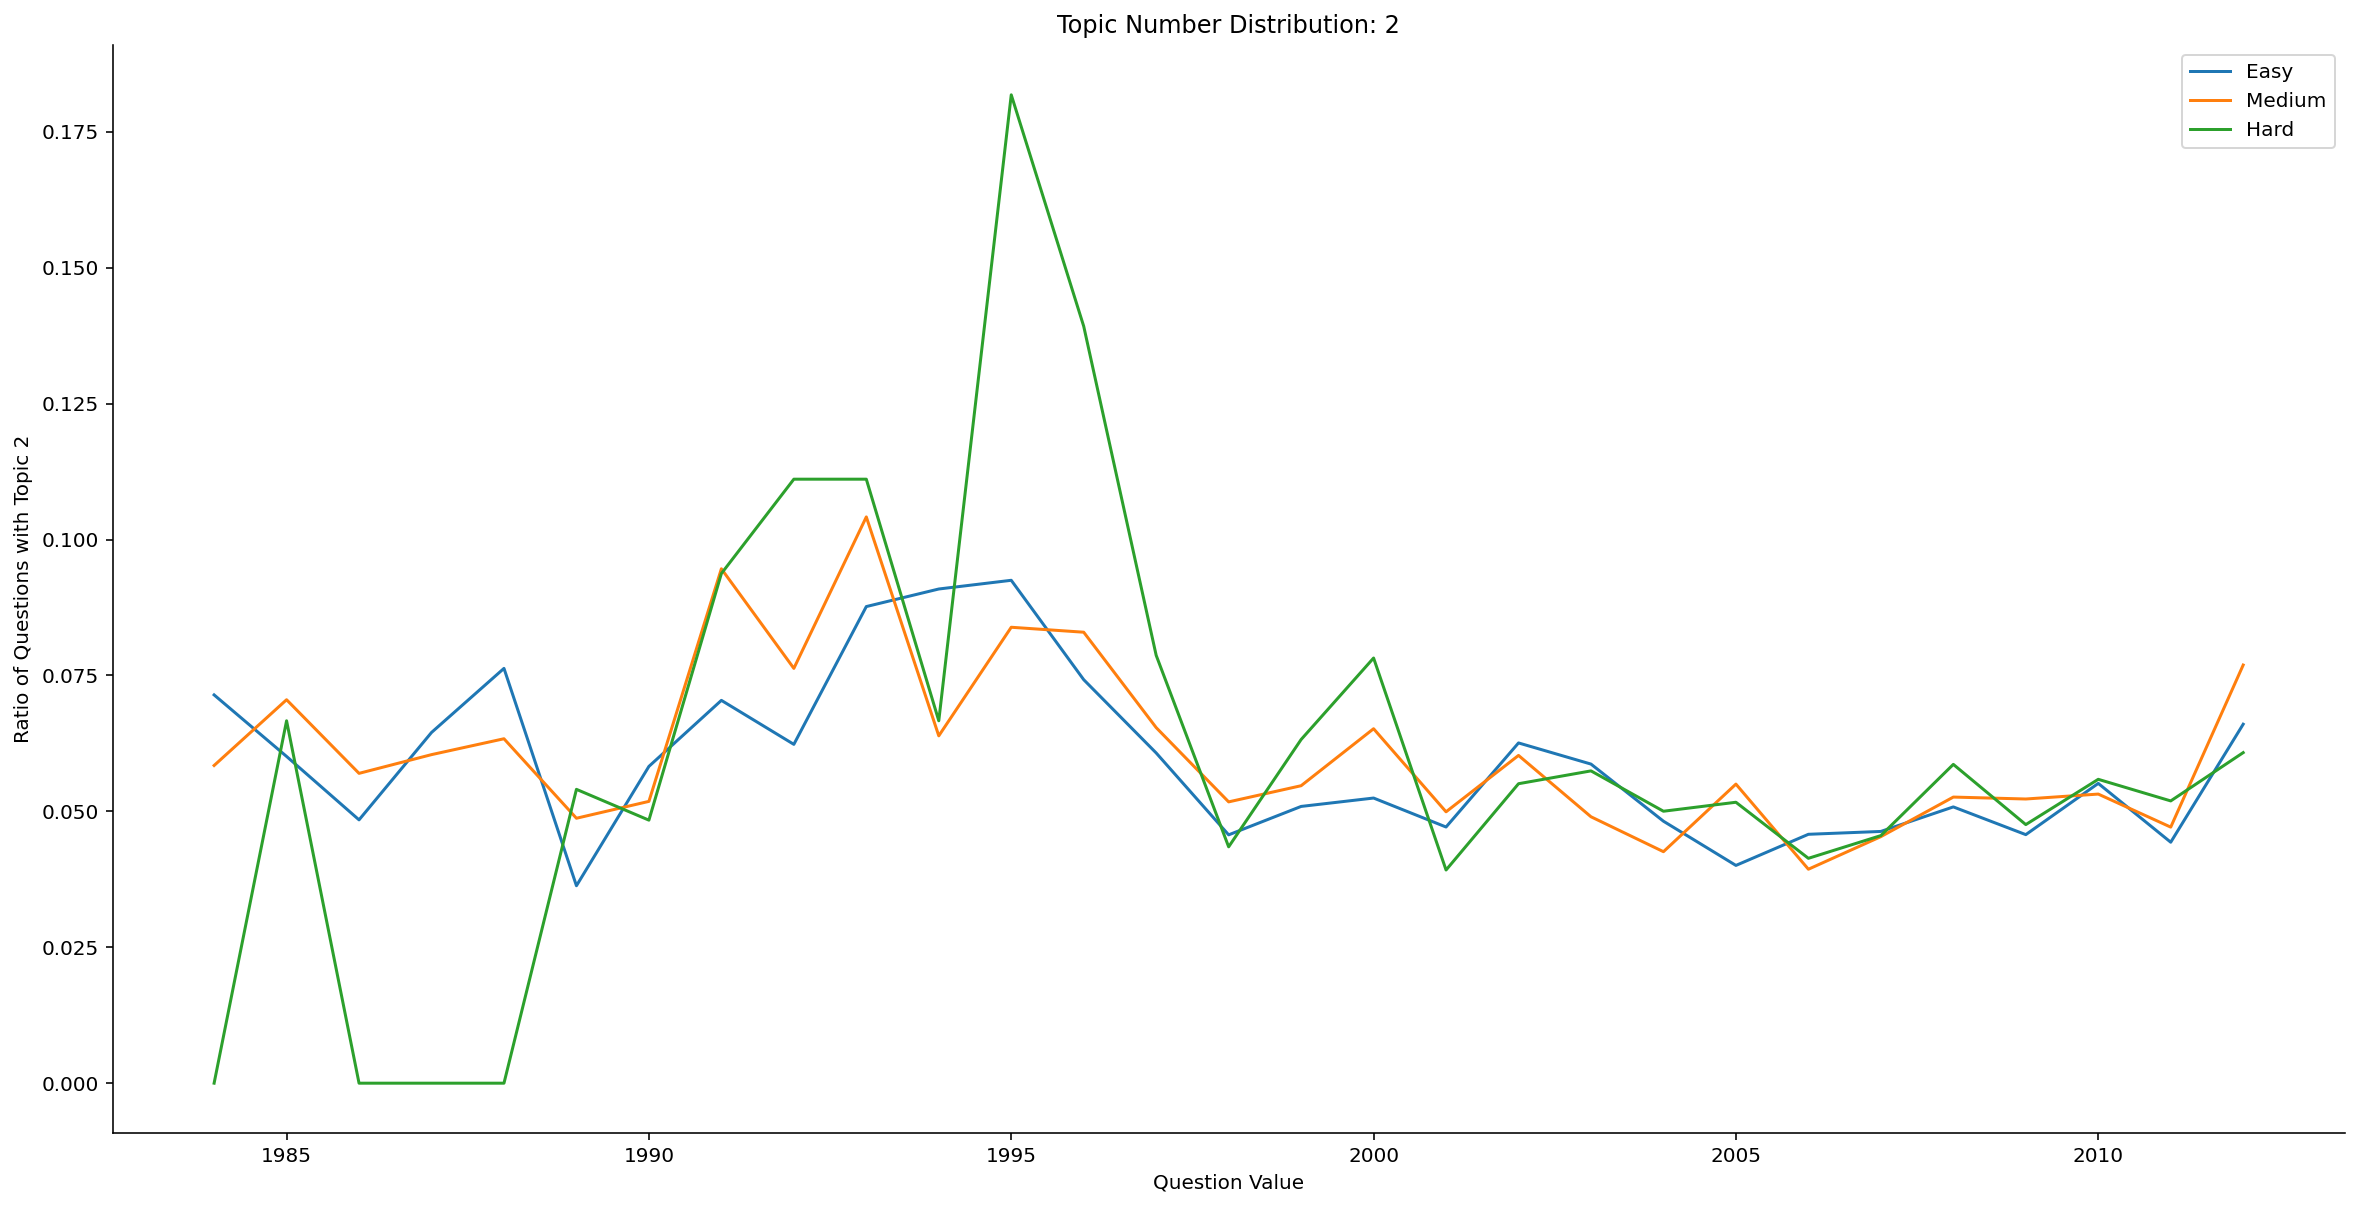

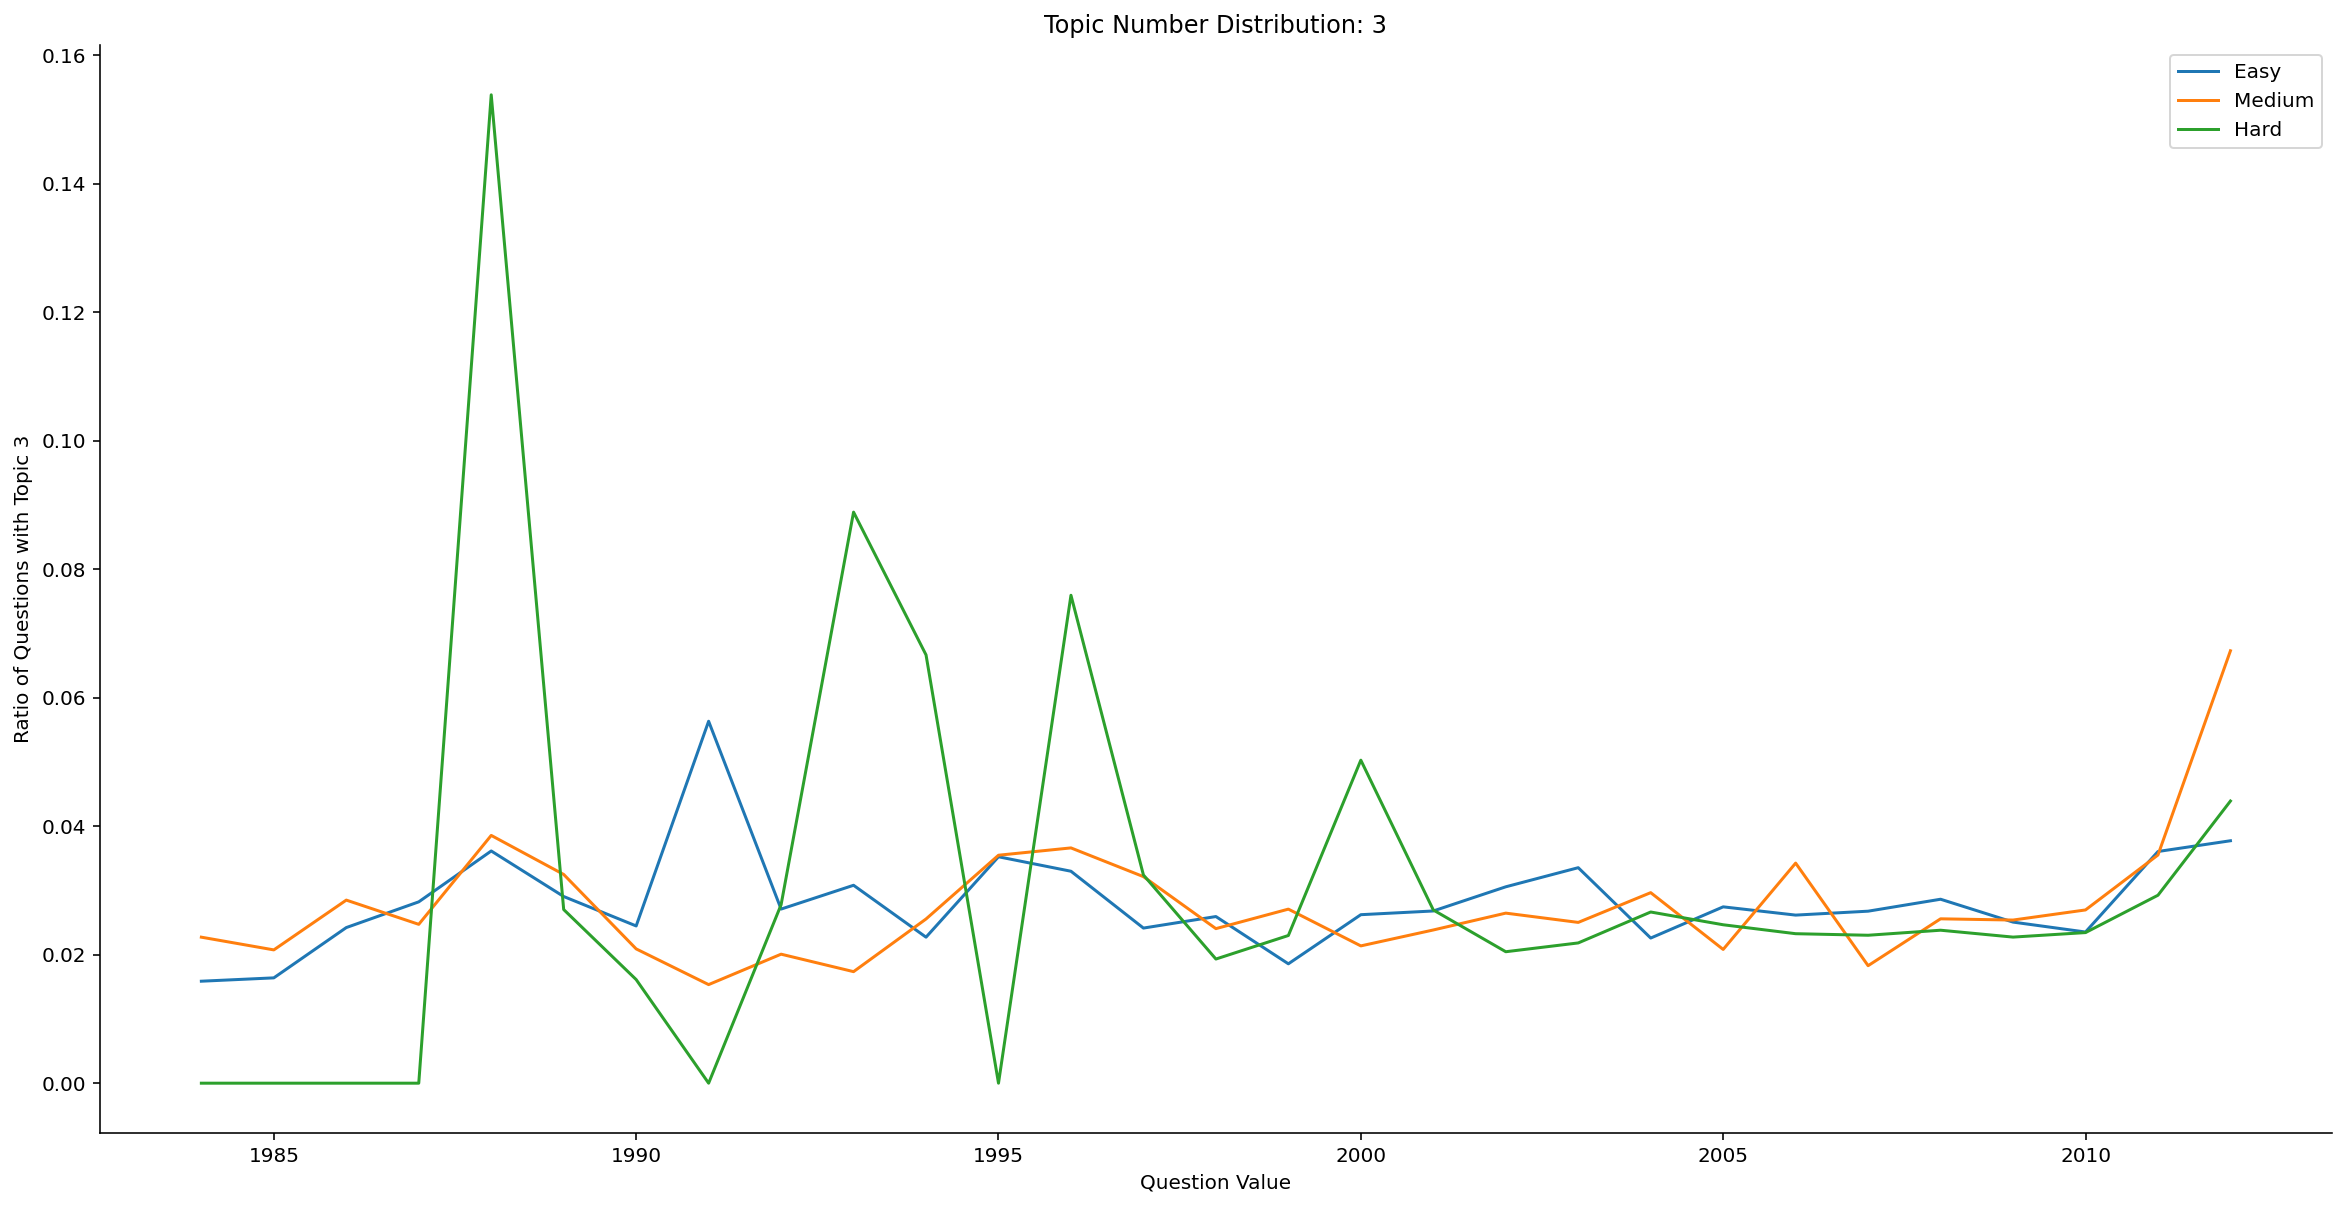

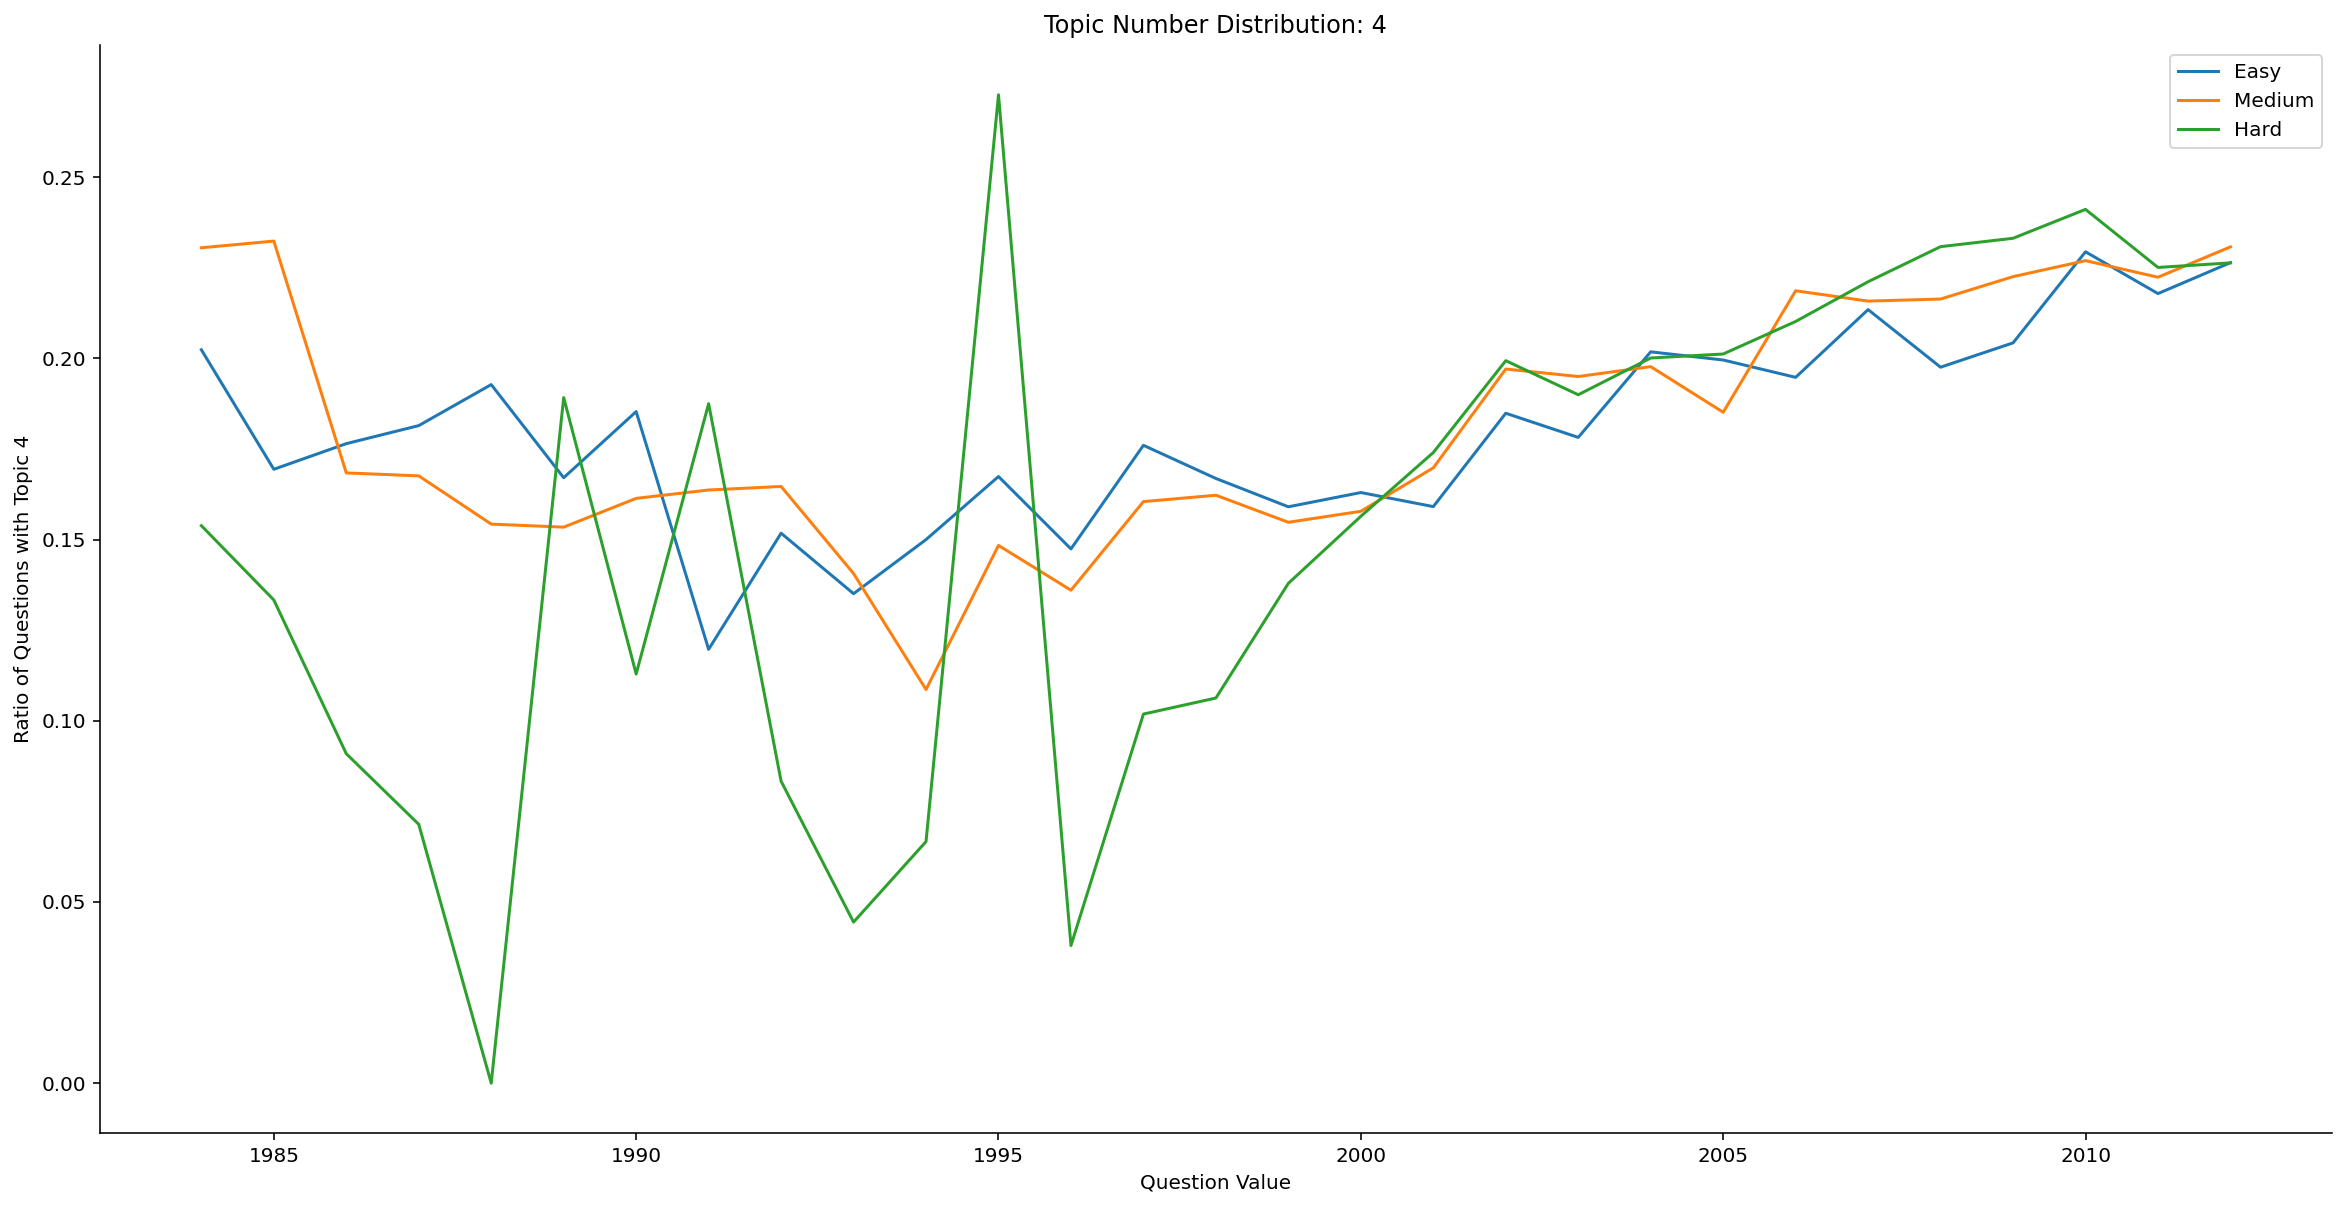

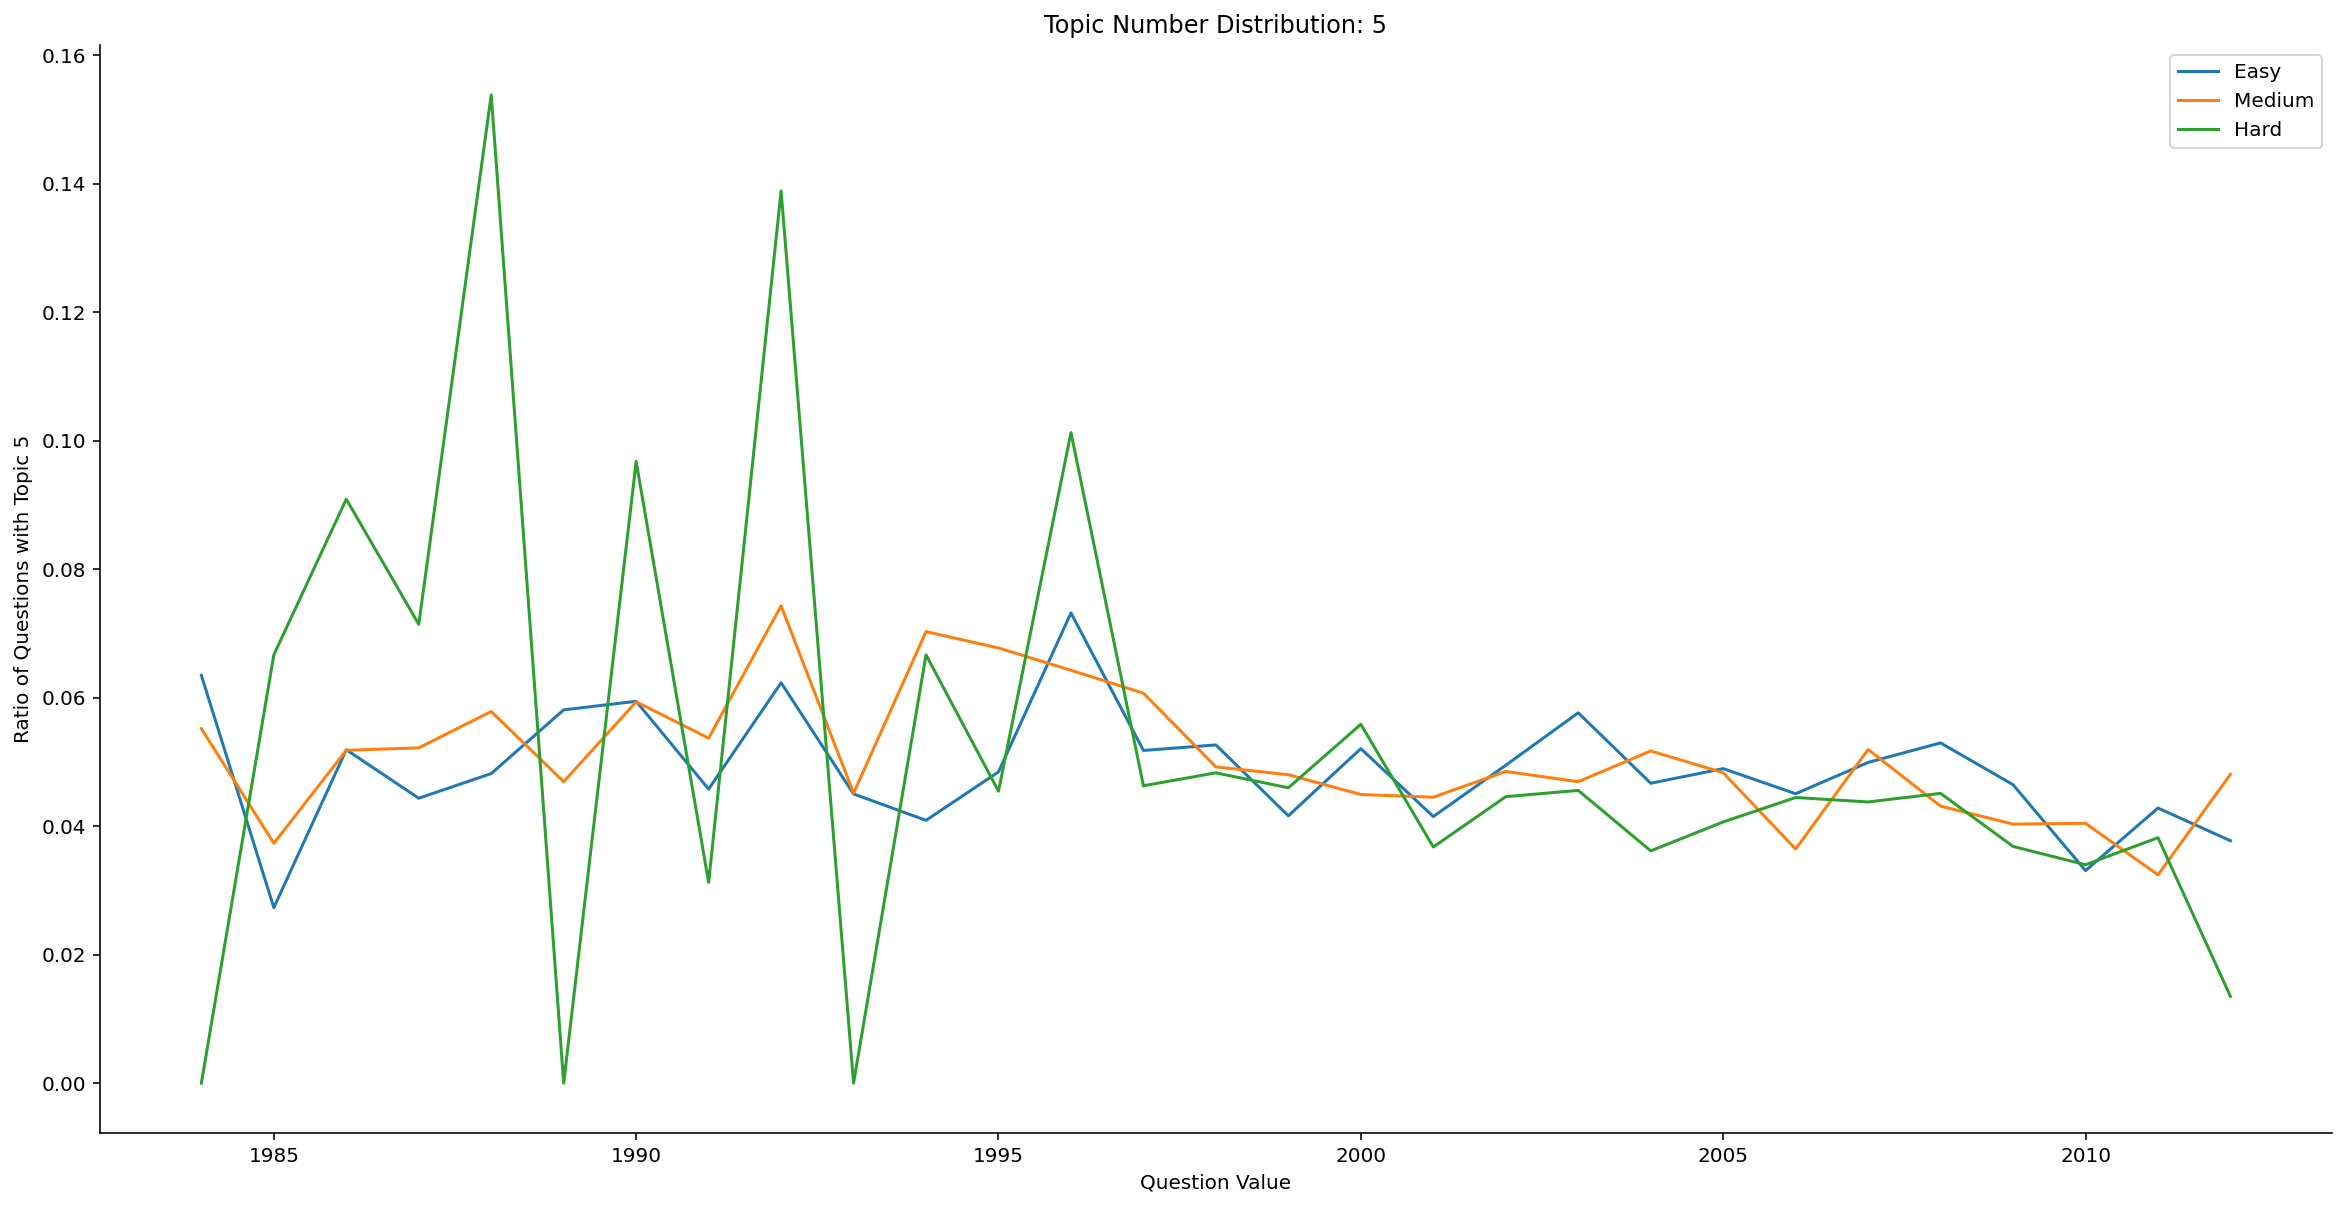

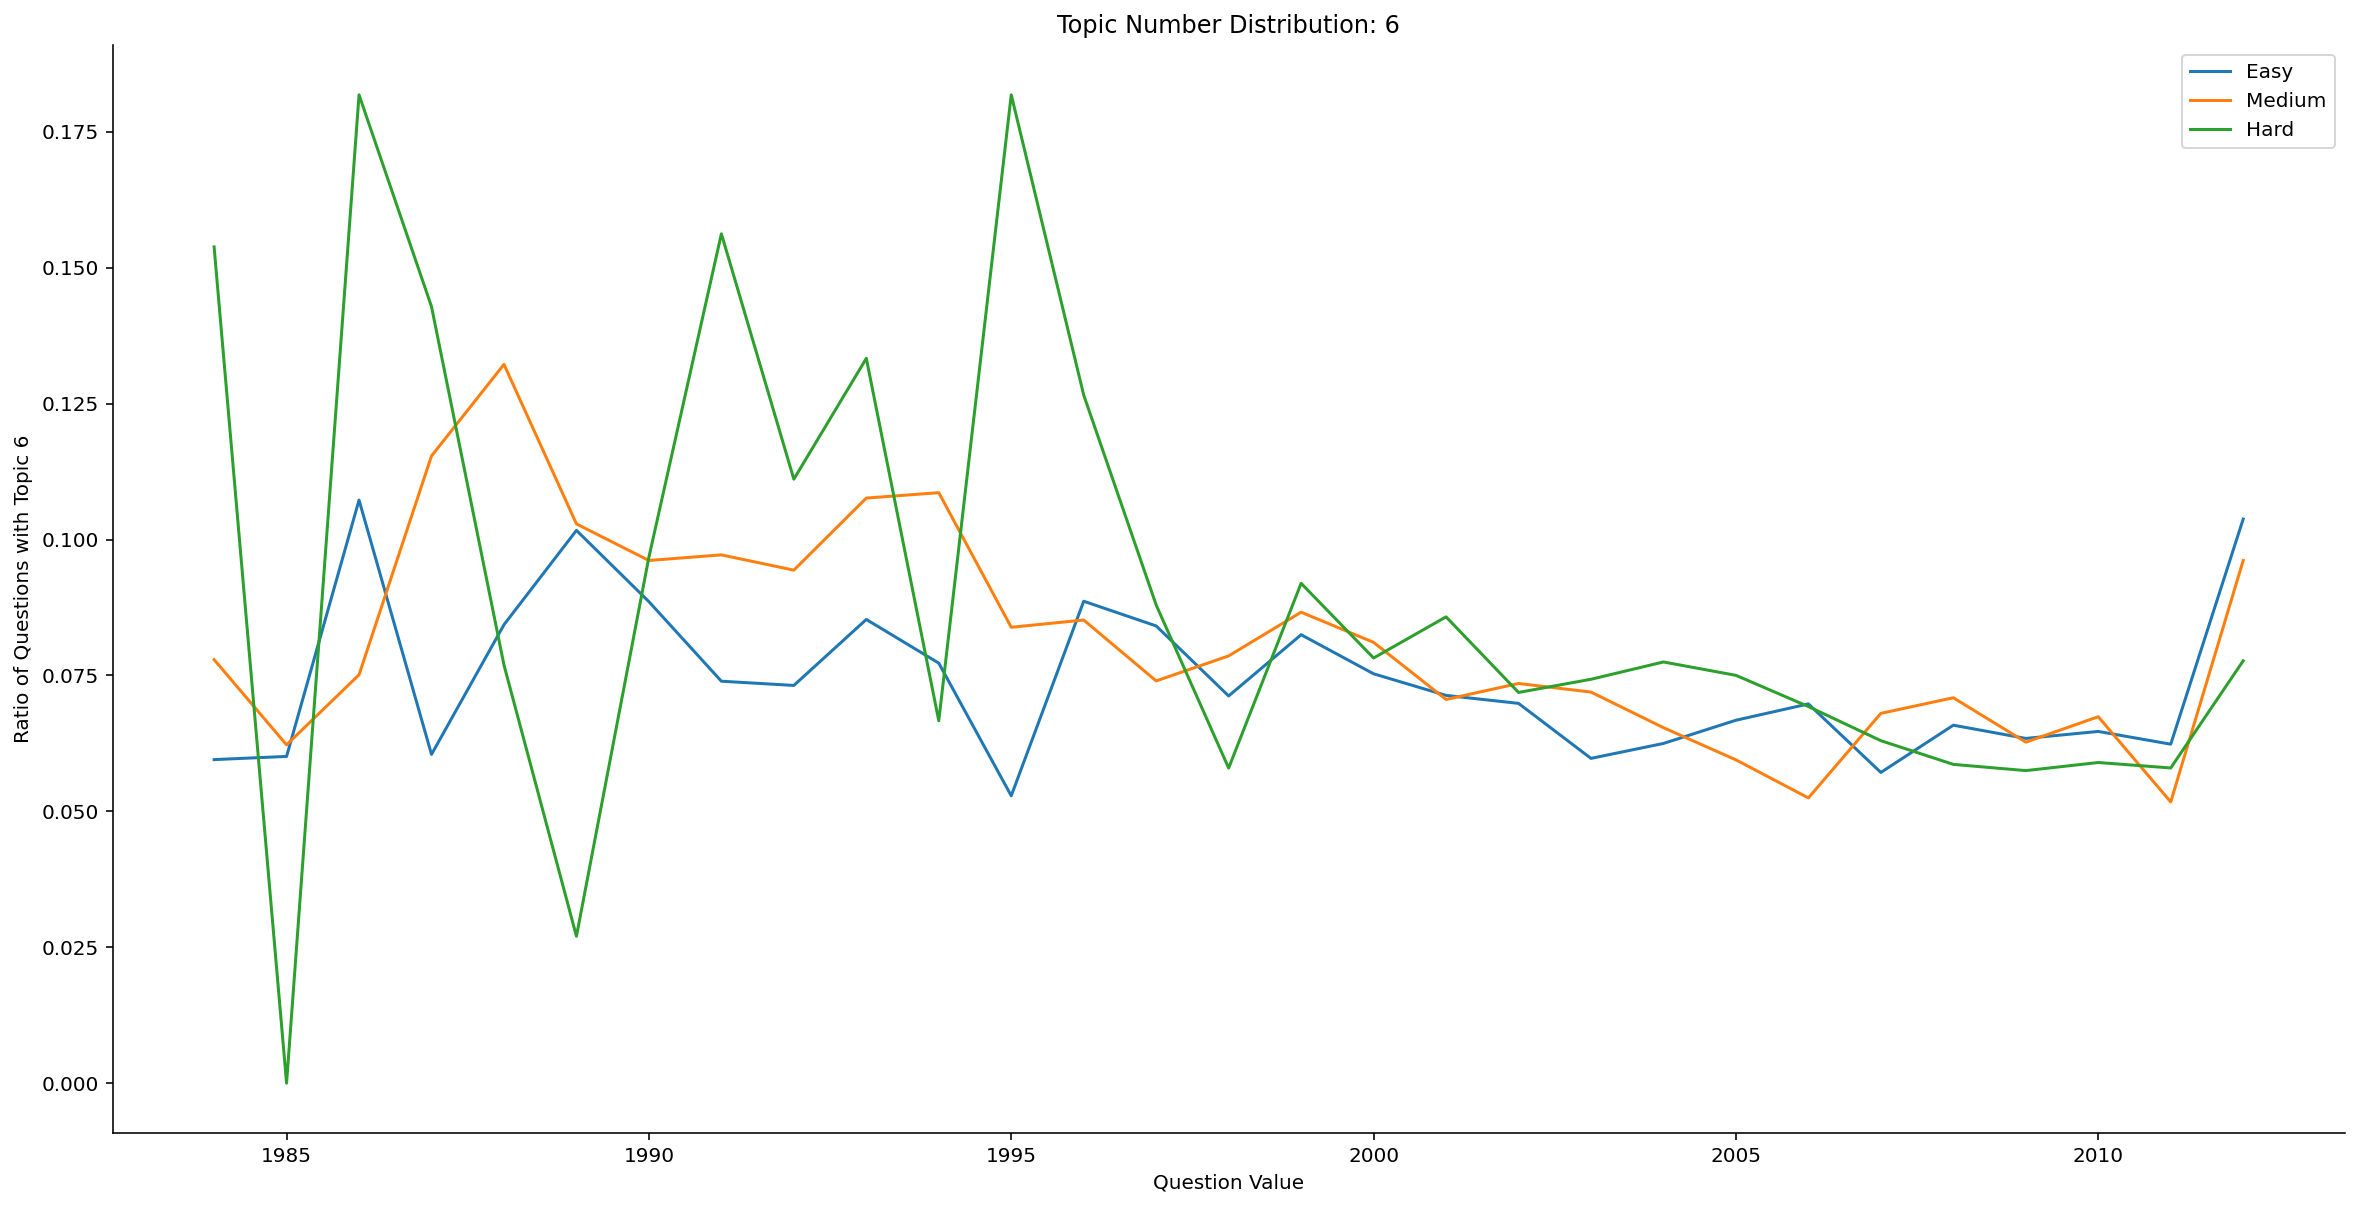

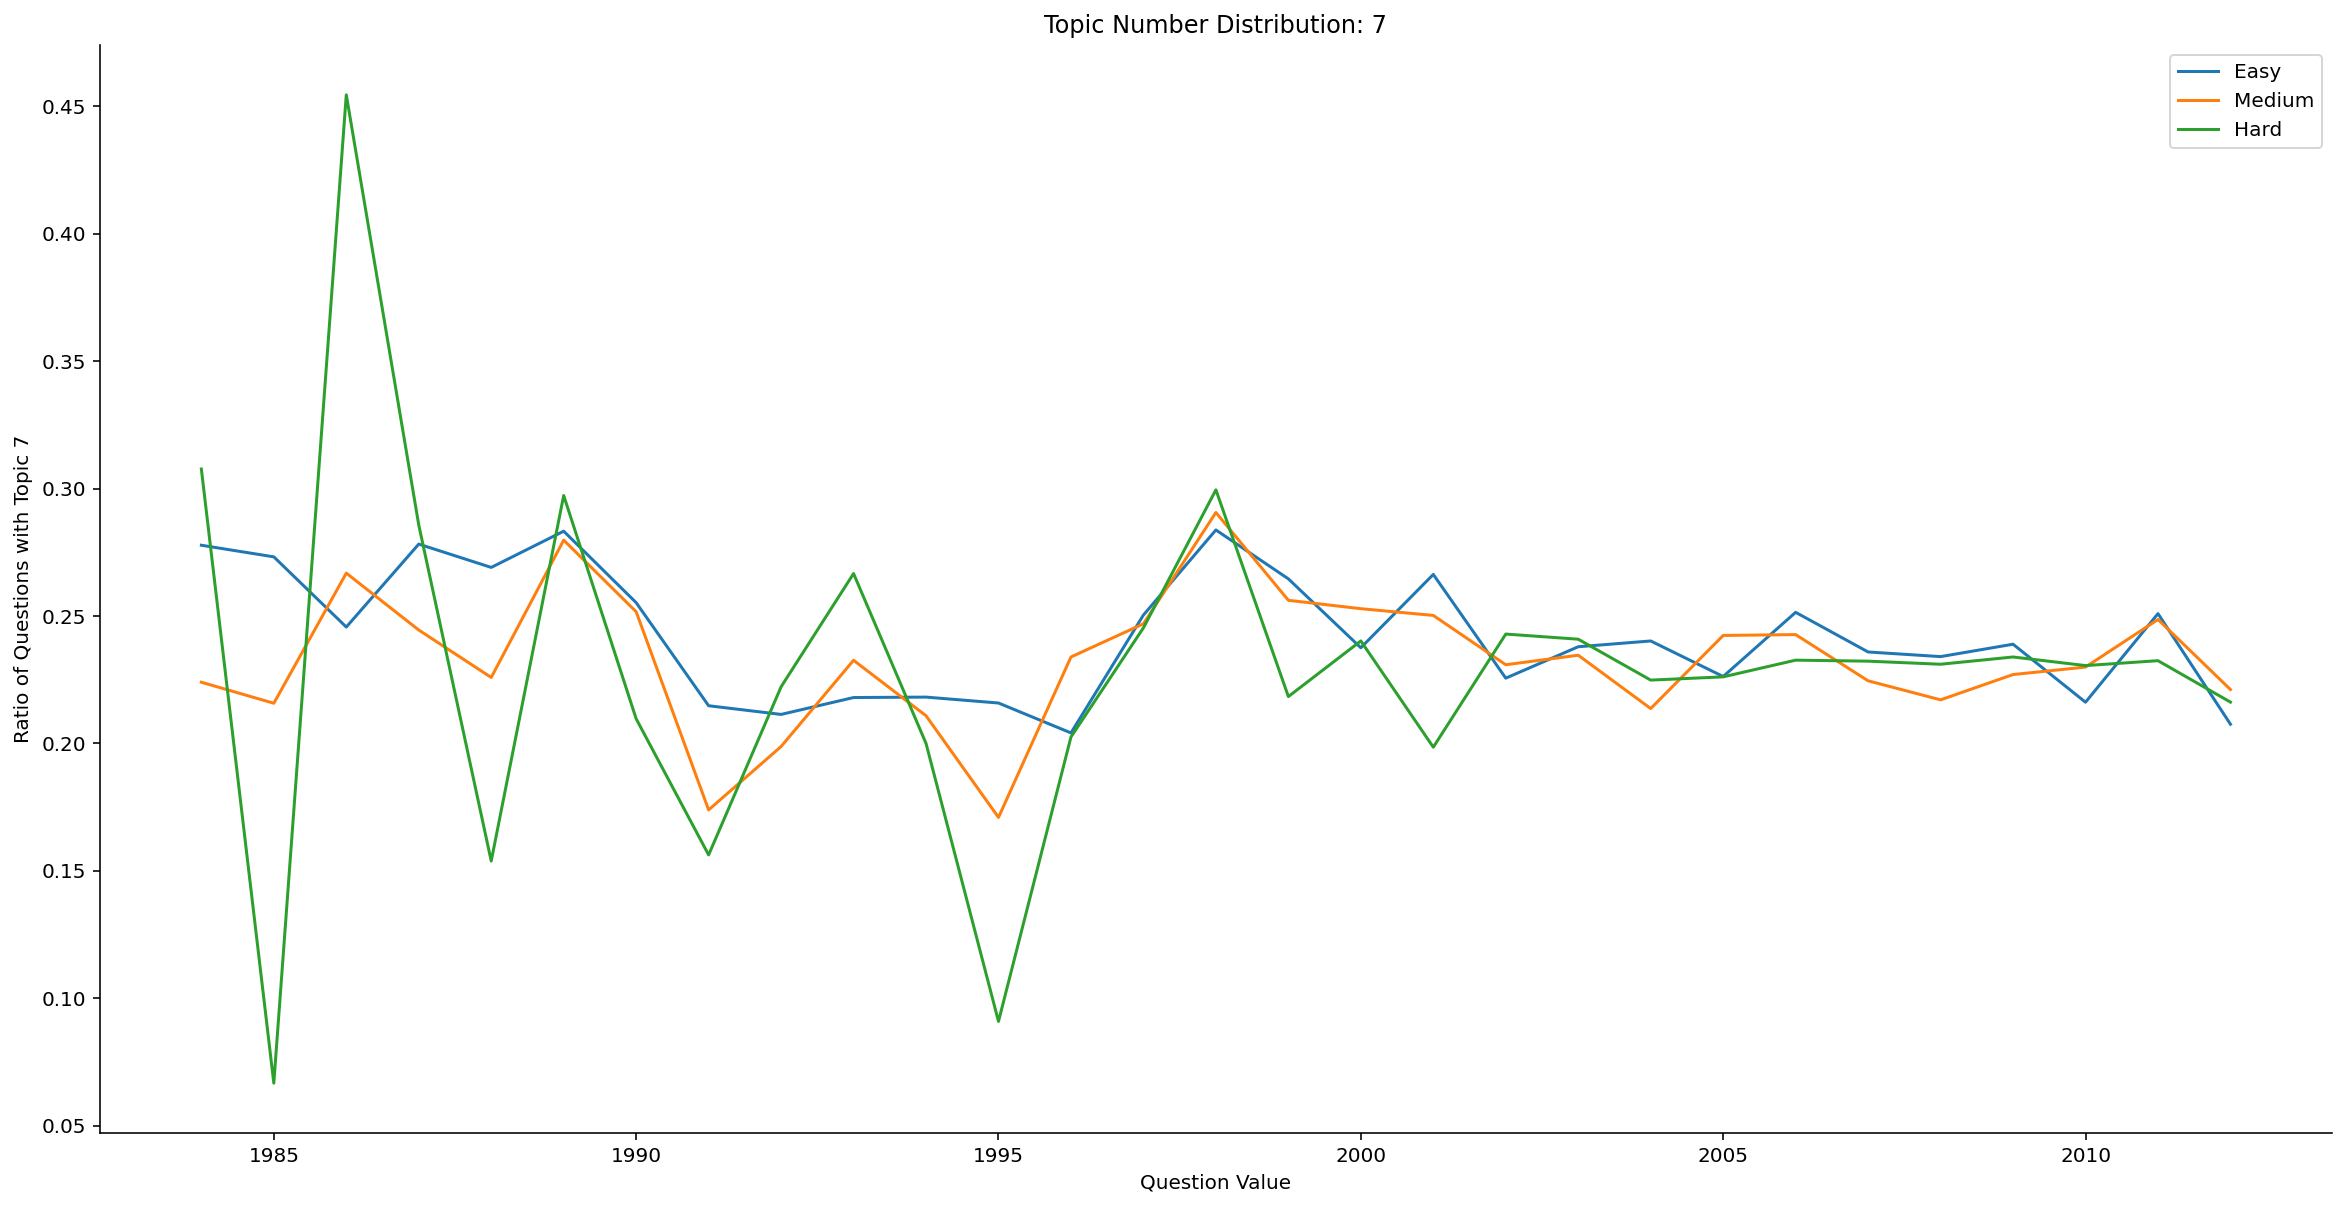

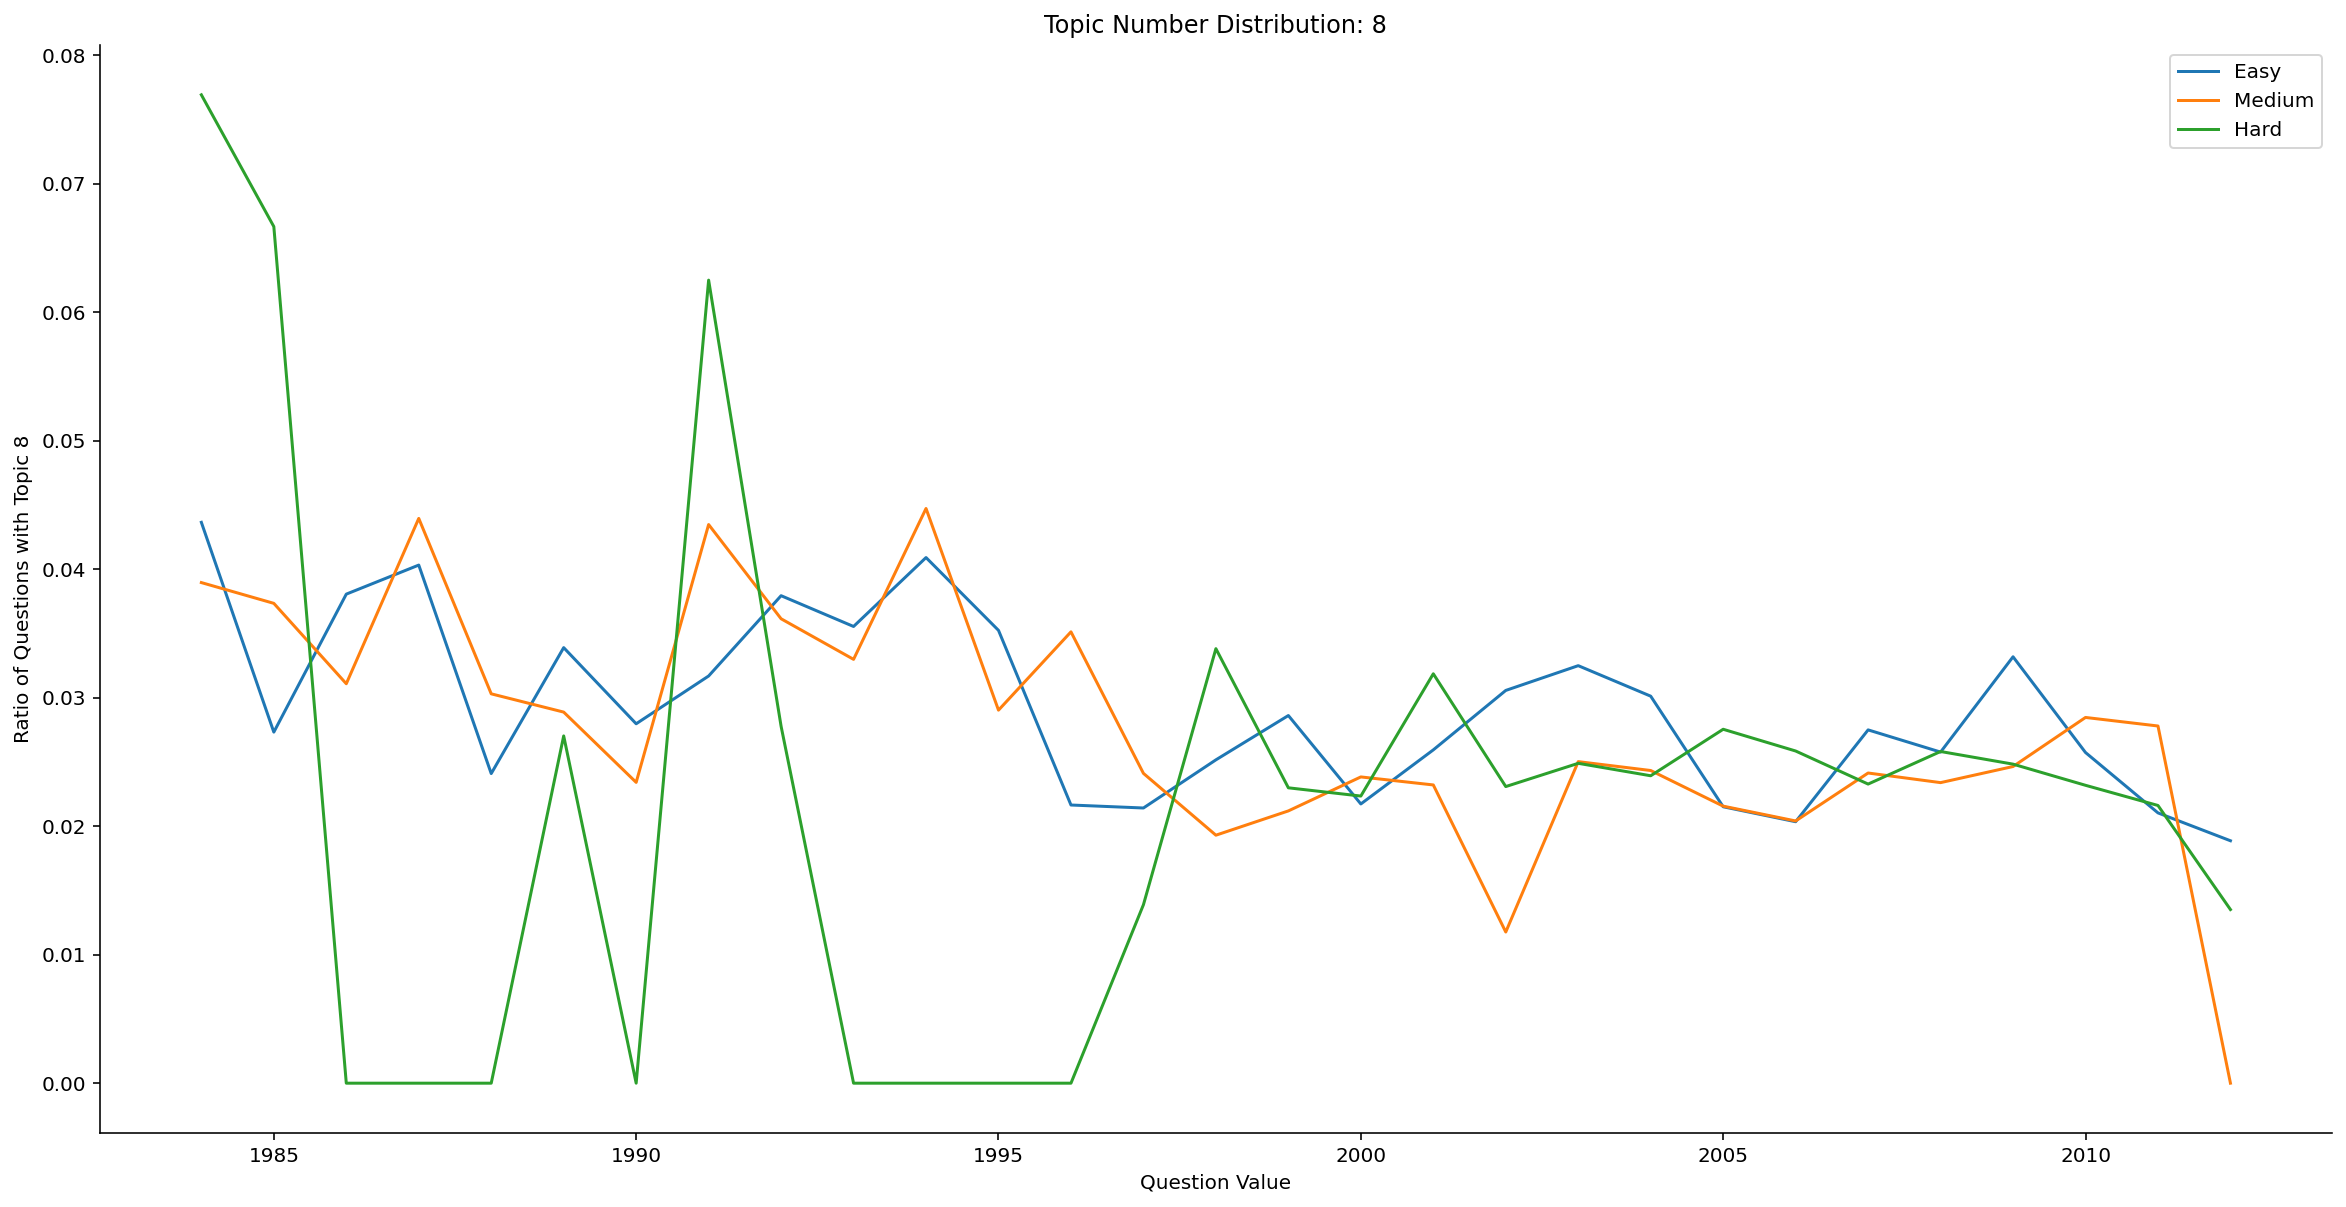

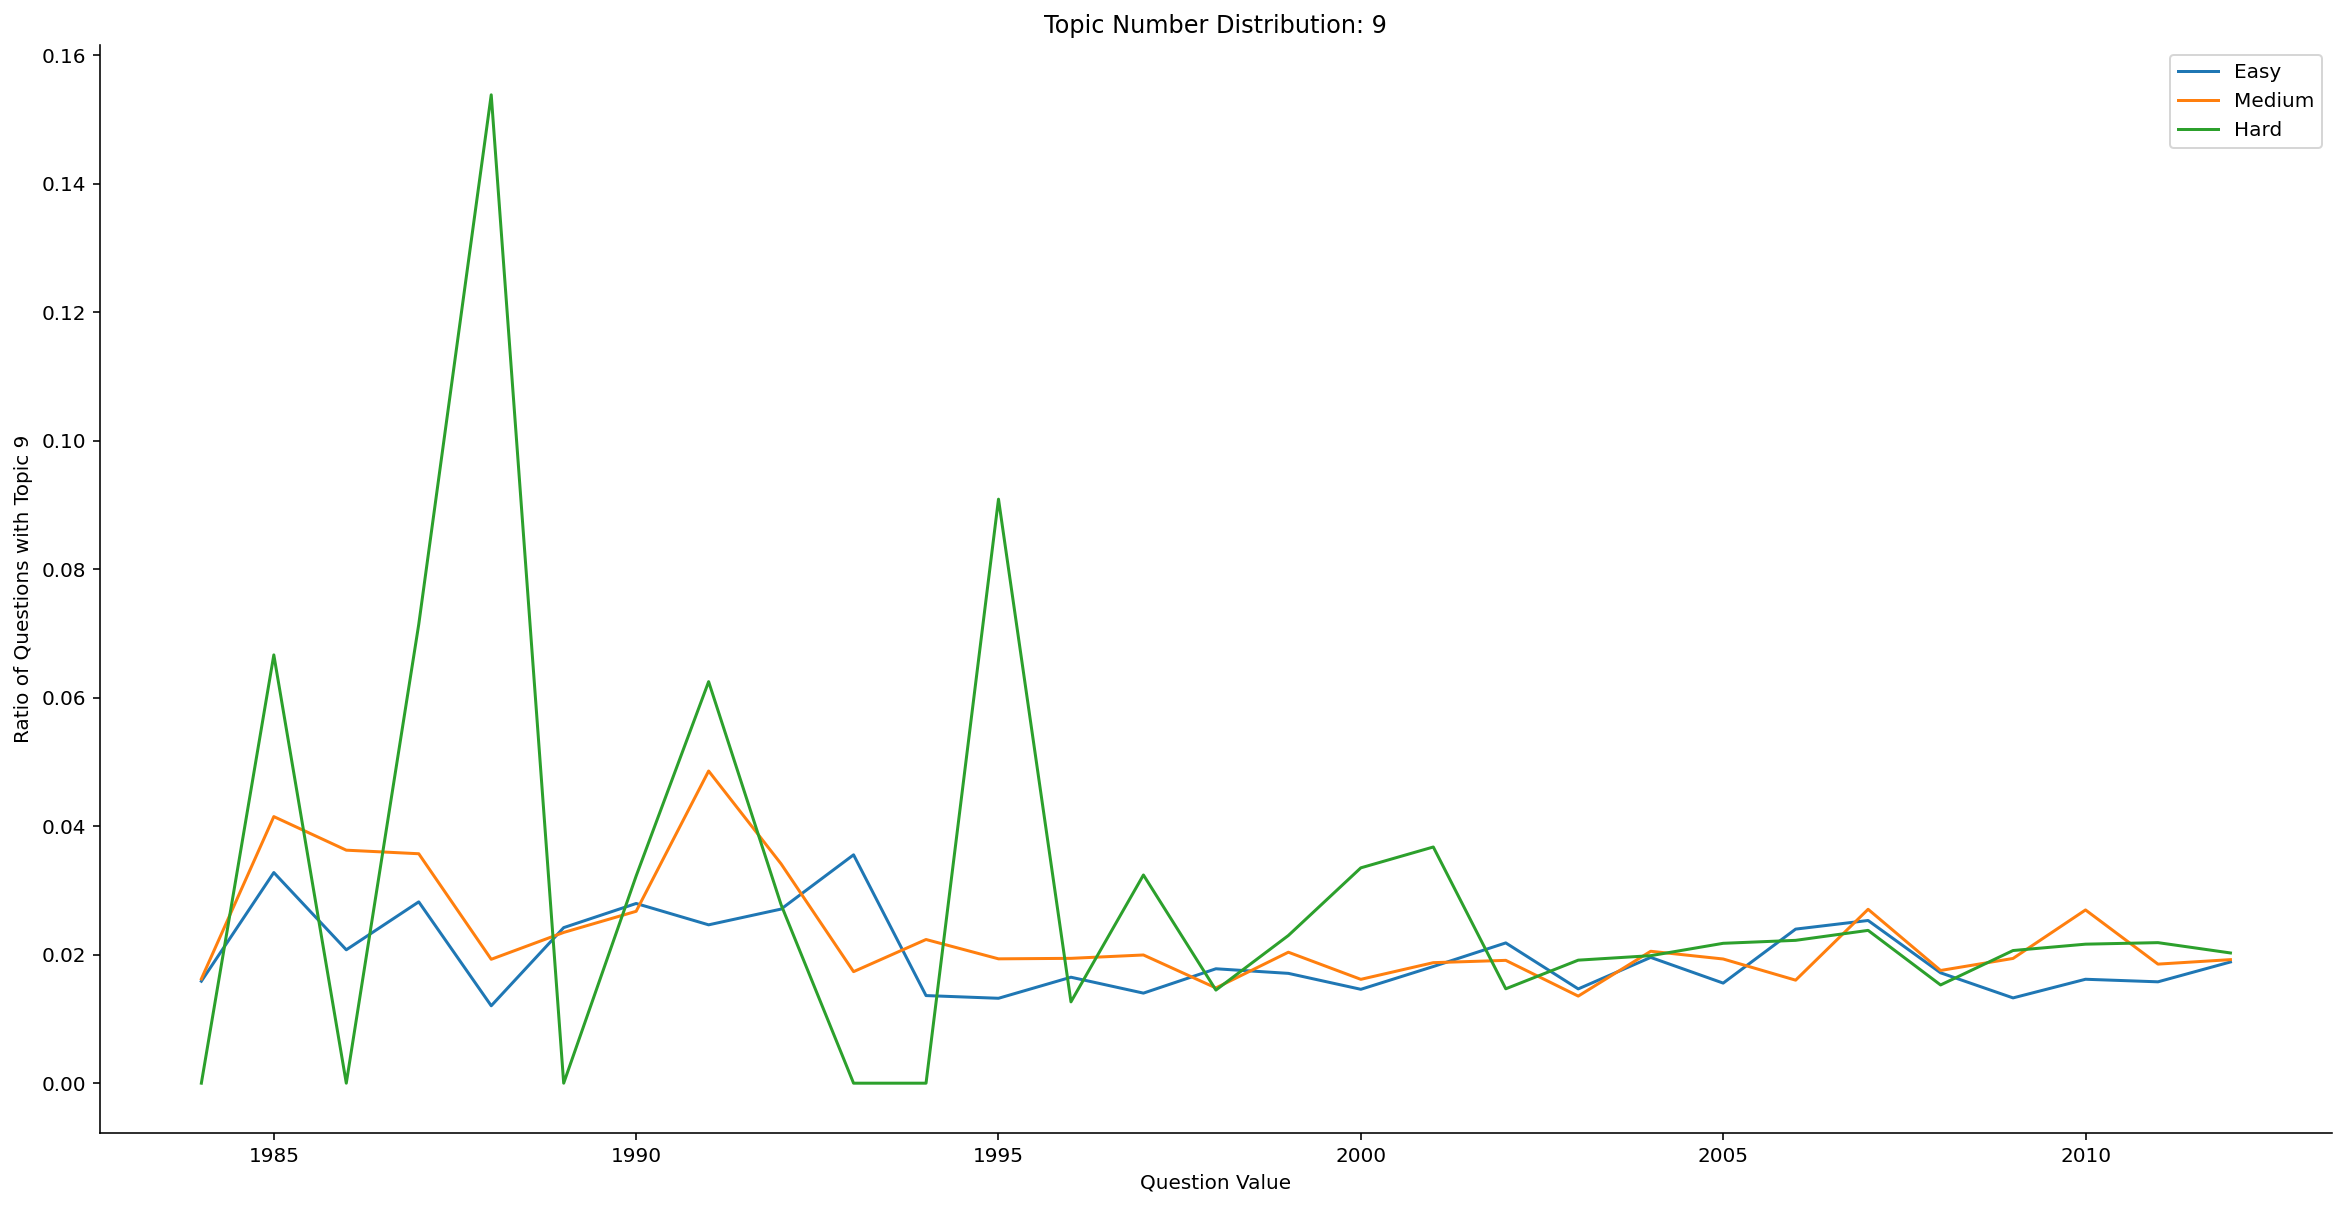

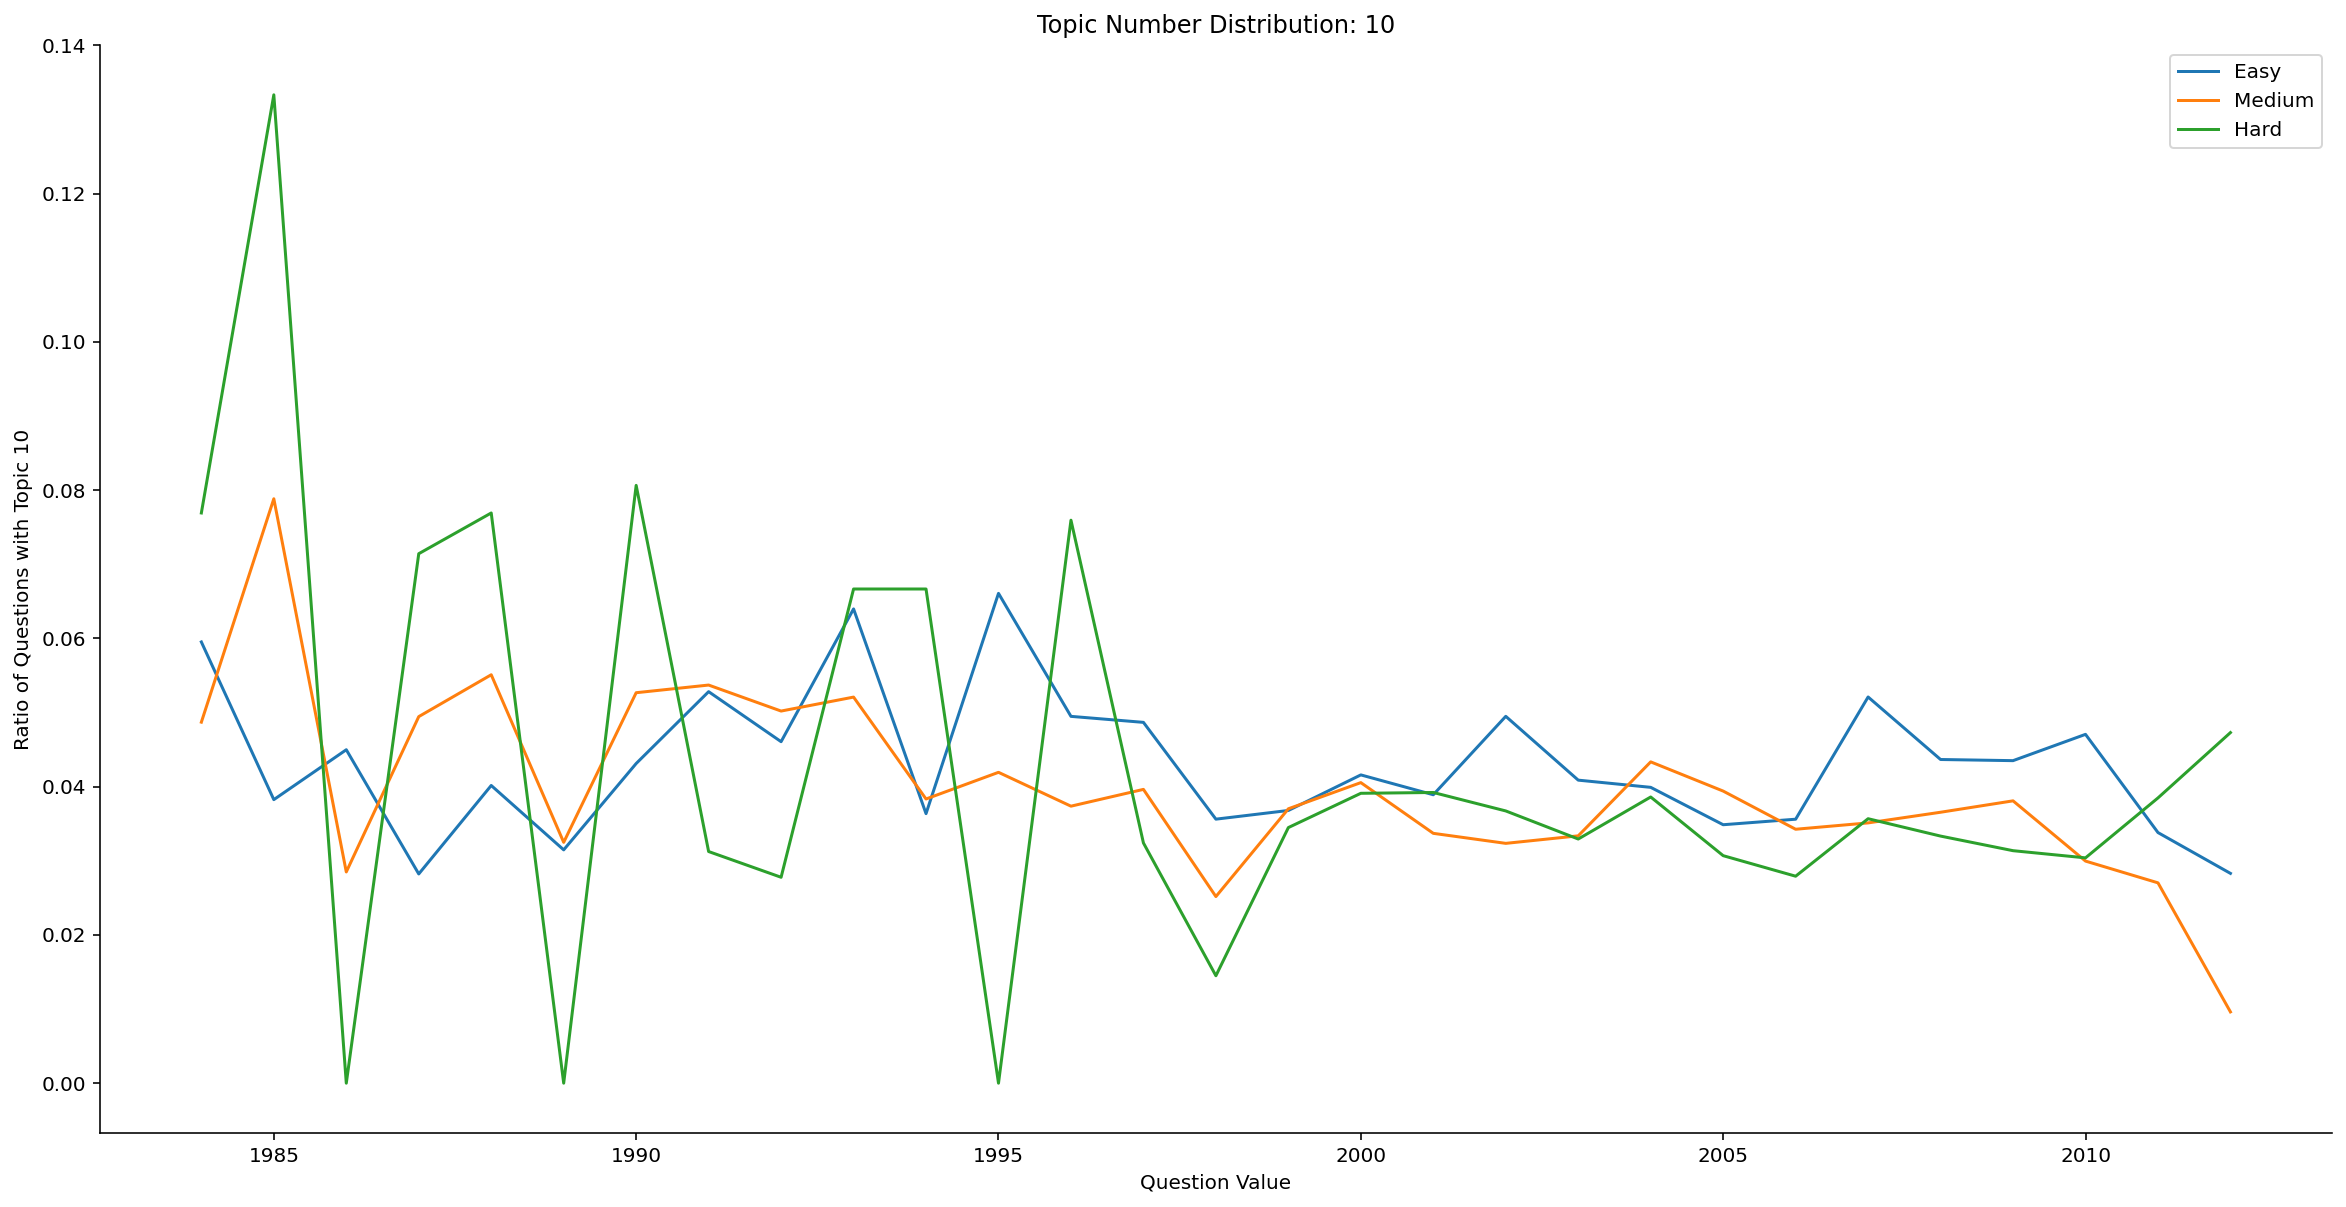

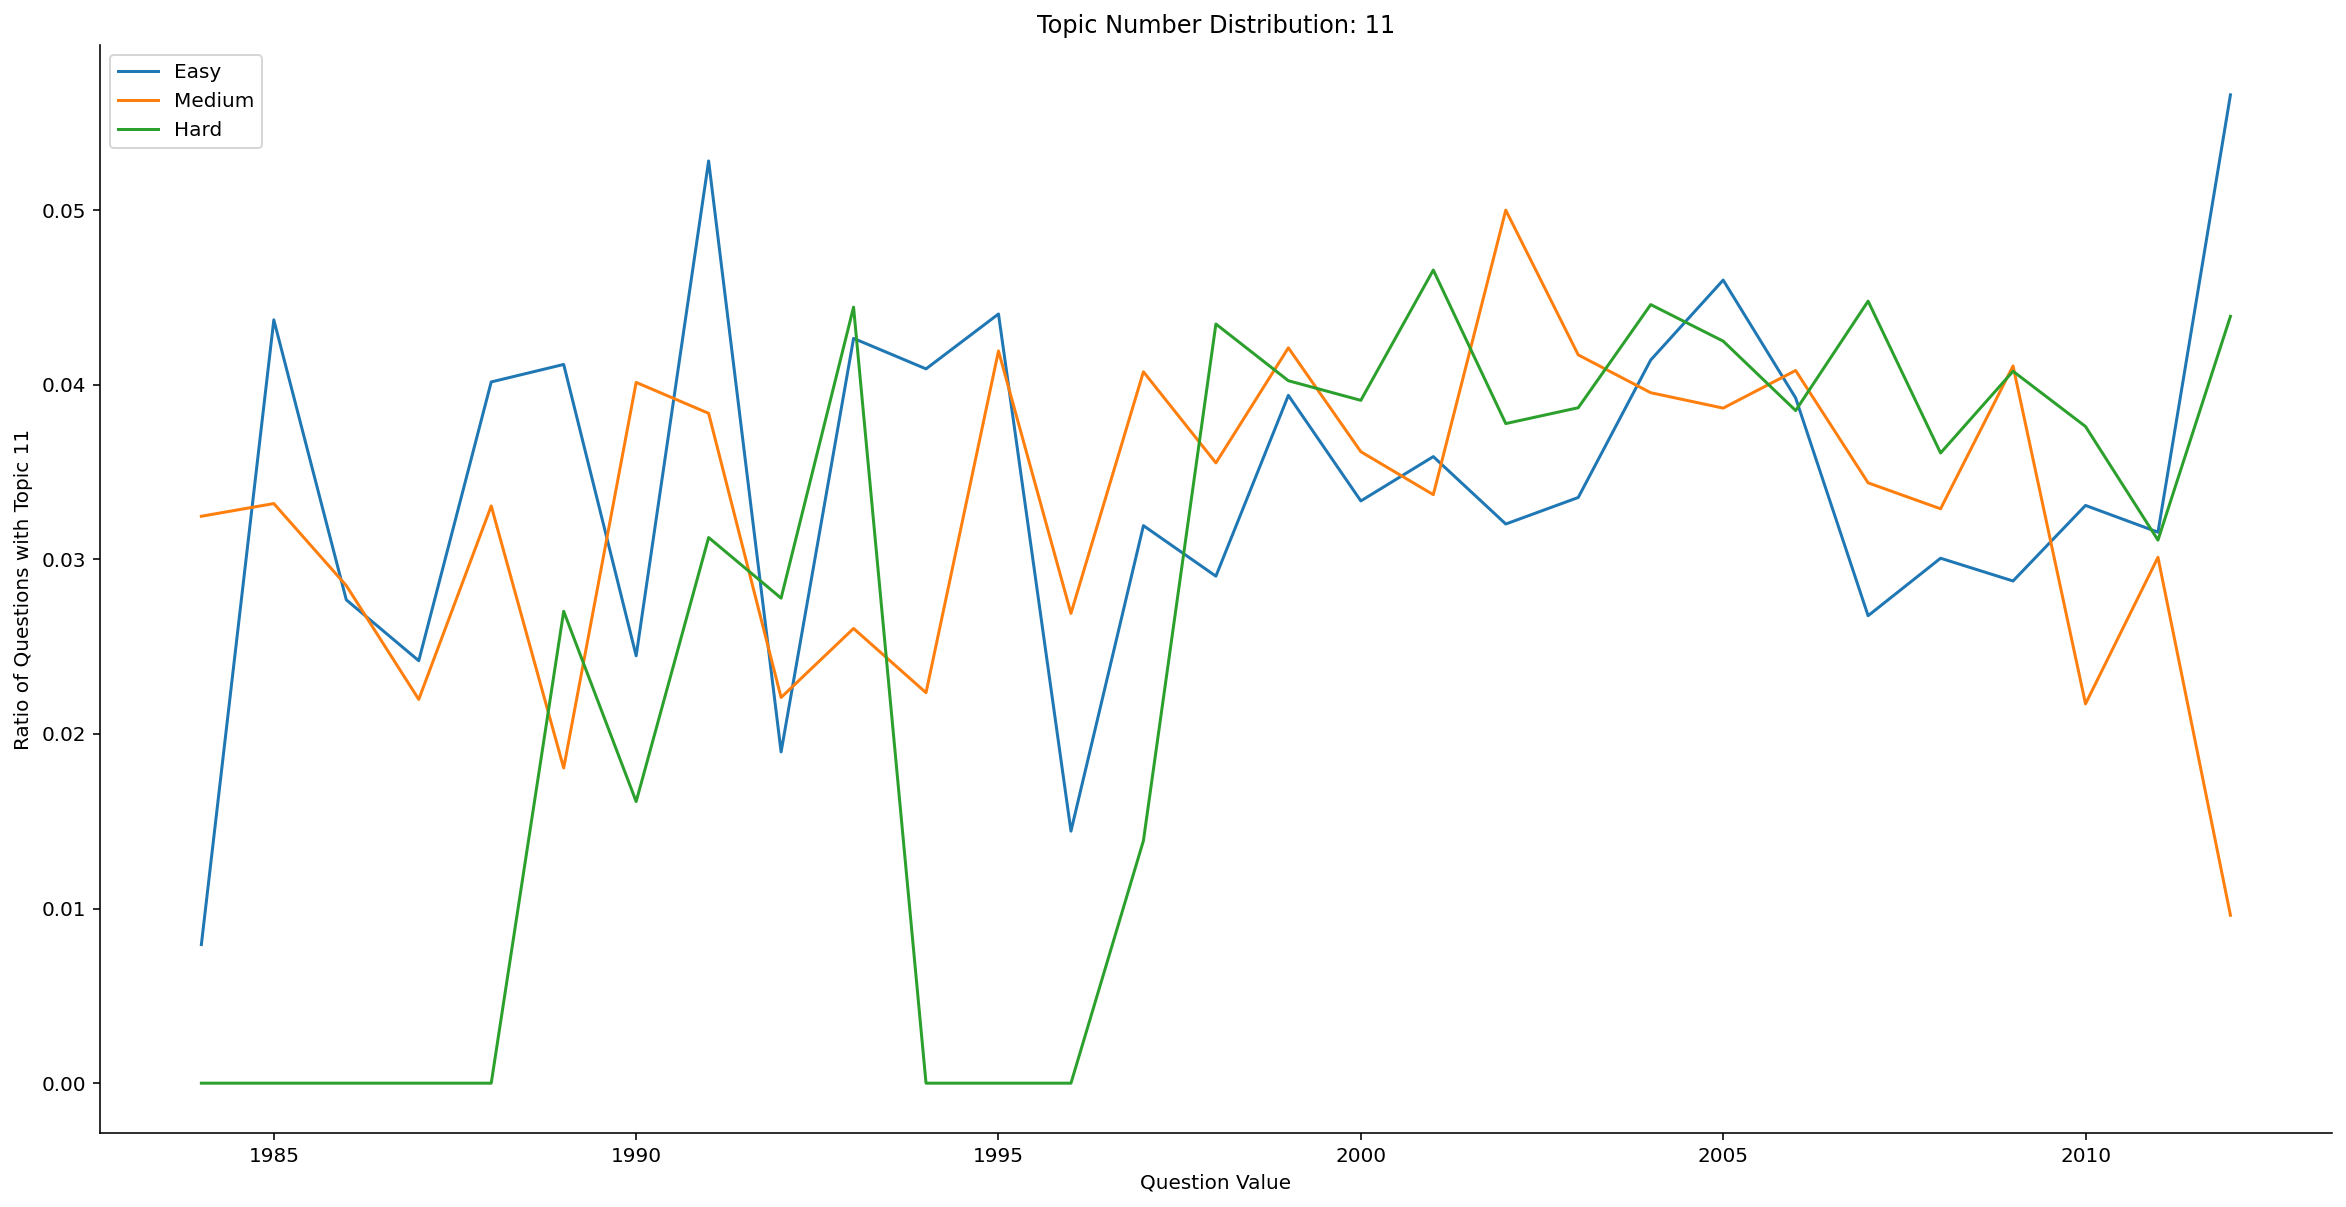

In [105]:
topics_across_time(dub_jeopardy, years, low=[100, 600, 1200], high=[600, 1200, 3001])

In double jeopardy, some topics show certain questions with some values that are consistent throughout time but some of them have sharp spikes and drop with discontinuity throughout time. Topics number 0, 5 and 7 are consistent throughout time both in the simple and difficult questions with minor spikes. Topic number 6, related to ancient history, started to be asked more in easy, medium, and hard questions around 2010.Topic number 1 which is about painting, was as asked as an easy question around 1995 but around 2011 it was not asked that much as a hard question, but it is increasingly being asked as an easy and medium question. 

Since most of the questions in the clusters are coherent with some overlap, we have some  interesting parts of double Jeopardy to recommend to contestants. For someone who is preparing for the questions, we would recommend to focus on topics like number 0, 5 and 7 since these topics are consistently asked throughout time. Topics number 11 are also being asked recently a lot both in easy and difficult questions, so that is recommended to be studied by contestants. Questions in topic 6 are increasingly being asked for all sorts of problems (easy, medium, and hard) and should be prepared as much as possible. Questions related to topics 8 and 9 about war and American presidents respectively are asked less frequently and not recommended to spend much time on these topics. In summary, we can analyse the values and the frequency changes of questions in their respective topics over time to make  predictions and recommendations for contestants. 


---